# Part 3 - Manual Multiple Video Analysis for Detected Emotions

### In Notebook2 we concluded that automatic person identification is not possible with the data that is available.

### In this notebook we aim to do manual person identification through multiple video sources to analyse the detected emotions. We target only single and two person scenes and discard panorama scenes due to the great variability of these scenes.

### The code is quite extensive because we had to hand-pick the number of clusters that suited our task and to manually identify the person belonging to each cluster for all 28 debates.

### To analyse the summarization of all the results consider jumping to the [Emotion Analysis section](#section4). To analyse a certain debate in more detail consider selecting one of the debates listed down below in the Table of Contents.

## Table of Contents
1. [Import Data](#section1)  
2. [Definition of Methods used](#section2)                 
3. [Debate Analysis](#section3)  
    &nbsp;&nbsp;&nbsp;&nbsp;3.1 [AD-BE](#section3.1)  
    &nbsp;&nbsp;&nbsp;&nbsp;3.2 [AD-CDU](#section3.2)  
    &nbsp;&nbsp;&nbsp;&nbsp;3.3 [AD-CHEGA](#section3.3)  
    &nbsp;&nbsp;&nbsp;&nbsp;3.4 [AD-IL](#section3.4)  
    &nbsp;&nbsp;&nbsp;&nbsp;3.5 [AD-LIVRE](#section3.5)  
    &nbsp;&nbsp;&nbsp;&nbsp;3.6 [AD-PAN](#section3.6)  
    &nbsp;&nbsp;&nbsp;&nbsp;3.7 [AD-PS](#section3.7)  
    &nbsp;&nbsp;&nbsp;&nbsp;3.8 [BE-PS](#section3.8)  
    &nbsp;&nbsp;&nbsp;&nbsp;3.9 [CDU-BE](#section3.9)  
    &nbsp;&nbsp;&nbsp;&nbsp;3.10 [CDU-PS](#section3.10)  
    &nbsp;&nbsp;&nbsp;&nbsp;3.11 [CHEGA-BE](#section3.11)  
    &nbsp;&nbsp;&nbsp;&nbsp;3.12 [CHEGA-CDU](#section3.12)  
    &nbsp;&nbsp;&nbsp;&nbsp;3.13 [CHEGA-IL](#section3.13)  
    &nbsp;&nbsp;&nbsp;&nbsp;3.14 [CHEGA-PS](#section3.14)  
    &nbsp;&nbsp;&nbsp;&nbsp;3.15 [IL-BE](#section3.15)  
    &nbsp;&nbsp;&nbsp;&nbsp;3.16 [IL-CDU](#section3.16)  
    &nbsp;&nbsp;&nbsp;&nbsp;3.17 [IL-PS](#section3.17)  
    &nbsp;&nbsp;&nbsp;&nbsp;3.18 [LIVRE-BE](#section3.18)  
    &nbsp;&nbsp;&nbsp;&nbsp;3.19 [LIVRE-CDU](#section3.19)  
    &nbsp;&nbsp;&nbsp;&nbsp;3.20 [LIVRE-CHEGA](#section3.20)  
    &nbsp;&nbsp;&nbsp;&nbsp;3.21 [LIVRE-IL](#section3.21)  
    &nbsp;&nbsp;&nbsp;&nbsp;3.22 [LIVRE-PS](#section3.22)  
    &nbsp;&nbsp;&nbsp;&nbsp;3.23 [PAN-BE](#section3.23)  
    &nbsp;&nbsp;&nbsp;&nbsp;3.24 [PAN-CDU](#section3.24)  
    &nbsp;&nbsp;&nbsp;&nbsp;3.25 [PAN-CHEGA](#section3.25)  
    &nbsp;&nbsp;&nbsp;&nbsp;3.26 [PAN-IL](#section3.26)  
    &nbsp;&nbsp;&nbsp;&nbsp;3.27 [PAN-LIVRE](#section3.27)  
    &nbsp;&nbsp;&nbsp;&nbsp;3.28 [PAN-PS](#section3.28)  
4. [Emotion Analysis](#section4)  
    &nbsp;&nbsp;&nbsp;&nbsp;4.1 [Barplot of most frequent emotions per party](#section4.1)  
    &nbsp;&nbsp;&nbsp;&nbsp;4.2 [Barplot of least frequent emotion per party](#section4.2)  
    &nbsp;&nbsp;&nbsp;&nbsp;4.3 [Barplot of emotions per political ideology](#section4.3)  
    &nbsp;&nbsp;&nbsp;&nbsp;4.4 [Barplot of most frequent emotions per Moderator](#section4.4)  
    &nbsp;&nbsp;&nbsp;&nbsp;4.5 [Pie chart of Moderator appearances](#section4.5)  
    

<a id="section1"></a>

# 1. Import Data

In [1]:
import numpy as np
import pandas as pd
import math
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from collections import defaultdict
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import random
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist
from collections import Counter
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import copy
from scipy.stats import pearsonr
from umap import UMAP
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering
from sklearn.manifold import Isomap

In [2]:
# Set global seed
random_seed = 0
np.random.seed(random_seed)

In [3]:
videos = [f for f in os.listdir('videos')]
print(videos)

dfs = defaultdict(pd.DataFrame)
for video in videos:
    if video != ".DS_Store":     
        df = pd.read_pickle(os.path.join('pickles', video + '.pkl'))
        df = df.sort_values(by='filename').reset_index(drop=True)
        dfs[video] = df

['ad-be', 'ad-cdu', 'ad-chega', 'ad-il', 'ad-livre', 'ad-pan', 'ad-ps', 'be-ps', 'cdu-be', 'cdu-ps', 'chega-be', 'chega-cdu', 'chega-il', 'chega-ps', 'il-be', 'il-cdu', 'il-ps', 'livre-be', 'livre-cdu', 'livre-chega', 'livre-il', 'livre-ps', 'pan-be', 'pan-cdu', 'pan-chega', 'pan-il', 'pan-livre', 'pan-ps']


In [4]:
debates = ['be-ps', 'ad-cdu', 'ad-ps', 'chega-be', 'cdu-be', 'livre-ps', 'chega-cdu', 'pan-il', 'il-cdu', 'ad-il', 'ad-pan', 'livre-il', 'il-ps', 'livre-be', 'cdu-ps', 'chega-ps', 'ad-be', 'livre-cdu', 'pan-cdu', 'pan-be', 'il-be', 'pan-chega', 'ad-livre', 'chega-il']

In [5]:
party = 'ad'
dfs_party = defaultdict(pd.DataFrame)
for key, df in dfs.items():
    if party in key:
        dfs_party[key] = df

dfs_party.keys()

dict_keys(['ad-be', 'ad-cdu', 'ad-chega', 'ad-il', 'ad-livre', 'ad-pan', 'ad-ps'])

In [6]:
def view_frame(video,df_plot,index):
    frame_id = df_plot.iloc[index]['filename']
    img = Image.open(os.path.join('videos', video, frame_id))
    plt.figure(figsize=(3, 2)) 
    plt.imshow(img)
    plt.show()

<a id="section2"></a>

# 2. Methods used
### The model we use includes UMAP and K-Means with image embeddings.

<a id="section2.1"></a>

In [7]:
def UMAP_with_kmeans(dfs, debate, random_seed, num_clusters):
    # Load embeddings and scale them
    embeddings = [emb for emb in dfs[debate]['embedding']]
    scaler = StandardScaler()
    embeddings = scaler.fit_transform(embeddings)
                                  
    # Reduce dimensionality using UMAP
    umap = UMAP(n_components=2, random_state=random_seed)
    embeddings_umap = umap.fit_transform(embeddings)

    # Clustering Algorithm
    kmeans = KMeans(n_clusters=num_clusters, random_state=random_seed)
    cluster_labels = kmeans.fit_predict(embeddings_umap)
    
    return embeddings_umap, cluster_labels

<a id="plot-function"></a>

In [8]:
def plot_clusters(embeddings_umap, cluster_labels, num_clusters):
    # Plot the clustering
#     plt.figure(figsize=(8, 6))
#     for i in range(num_clusters):
#         plt.scatter(embeddings_umap[cluster_labels == i, 0], embeddings_umap[cluster_labels == i, 1], label=f'Cluster {i+1}')
#     plt.title('Clusters of Embeddings (UMAP)')
#     plt.xlabel('UMAP Component 1')
#     plt.ylabel('UMAP Component 2')
#     plt.legend()
#     plt.show()

    # Create a list of lists where each list contains the indices of the frames in a cluster
    C1 = [[] for _ in range(num_clusters)]
    for index, label in enumerate(cluster_labels):
        C1[label].append(index)
    
    return C1


In [9]:
def plot_specific_cluster(cluster, C1, debate, jump):
    """Plot a specific cluster of frames. Prints one image per 'jump' in the cluster. To avoid having to check every single image."""
    print(f'Cluster {cluster+1}')
    arr = C1[cluster]
    print(arr)
    a = 0
    while a < len(C1[cluster]):
        frame = C1[cluster][a]
        view_frame(debate, dfs[debate], frame)
        a += jump

In [10]:
def get_location_for_frame(df, print_locations=False):
    # Extract locations for all frames
    all_locations = []
    for frame in df['fer']:
        frame_locations = [person['location'] for person in frame]
        all_locations.append(frame_locations)

    if print_locations:
        # Display the extracted locations
        for i, locations in enumerate(all_locations):
            print(f"Frame {i+1}:")
            for j, location in enumerate(locations):
                print(f"  Person {j+1} location: {location}")

    return all_locations

def get_location_for_each_candidate(df):
    # Initialize lists to hold the categorized locations
    left_person = []
    right_person = []

    # Extract and categorize locations for all frames
    for frame in df['fer']:
        # Sort the locations by x1 (the first element of the location list)
        sorted_frame = sorted(frame, key=lambda x: x['location'][0])

        # Ensure there are at least two people in the frame
        if len(sorted_frame) >= 2:
            left_person.append(sorted_frame[0])
            right_person.append(sorted_frame[1])
        else:
            # Handle cases with fewer than two people (optional: append None or skip)
            left_person.append(None)
            right_person.append(None)

    return left_person, right_person

In [11]:
# Get emotion for each person in 1v1 types of frames
def get_emotion_for_person_in_1v1(person, person_emotions):
    for values in person:
        if values is not None:  # Skip None values
            person_emotions[values['emotion']] += 1
    return person_emotions

def get_emotions(df, df_1v1, flag):
    emotions = defaultdict(int)
    if flag == 0:
        get_emotion_for_person_in_1v1(df_1v1, emotions)
    for frame in df['fer']:
        for person in frame:
            emotions[person['emotion']] += 1
    return emotions

In [12]:
def plot_emotions(person_name, emotions, color):
    """
    Plots a bar chart of emotions for a given person.

    Parameters:
    person_name (str): The name of the person whose emotions are being plotted.
    emotions (dict): A dictionary with emotions as keys and their counts as values.
    color (str): The color of the bars in the bar chart.
    """
    # Extract data for plotting
    labels = list(emotions.keys())
    values = list(emotions.values())

    # Plotting the bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(labels, values, color=color, alpha=0.7)
    plt.title(f'{person_name} Emotions')
    plt.xlabel('Emotions')
    plt.ylabel('Count')
    plt.ylim(0, max(values) + 50)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [13]:
def remove_translator1v1(df):
    for frame_index in df.index:
        frame = df.at[frame_index, 'fer']
        min_diff = float('inf')
        min_index = -1
        
        for i, person in enumerate(frame):
            location = person['location']
            diff = location[1] - location[0]
            if diff < min_diff:
                min_diff = diff
                min_index = i
        
        if min_index != -1 and len(frame)>2:
            df.at[frame_index, 'fer'].pop(min_index)
    return df

def remove_translator(df):
    for frame_index in df.index:
        frame = df.at[frame_index, 'fer']
        min_diff = float('inf')
        min_index_ = -1
        
        for i, person in enumerate(frame):
            location = person['location']
            diff = location[1] - location[0]
            if diff < min_diff:
                min_diff = diff
                min_index_ = i
        
        if min_index_ != -1 and len(frame)>1:
            df.at[frame_index, 'fer'].pop(min_index_)
    return df

def remove_translators(df):
    for frame_index in df.index:
        frame = df.at[frame_index, 'fer']
        
        if len(frame) > 3:
            diffs = [(i, person['location'][1] - person['location'][0]) for i, person in enumerate(frame)]
            
            diffs_sorted = sorted(diffs, key=lambda x: x[1])
            
            indices_to_remove = [diffs_sorted[0][0], diffs_sorted[1][0]]
            
            # Remove the items with the two smallest differences
            for index in sorted(indices_to_remove, reverse=True):
                df.at[frame_index, 'fer'].pop(index)
                
    return df


In [14]:
def remove_clusters(C1_modified, cluster_names, clusters_to_remove):
    # Get the indices of the clusters to remove
    indices_to_remove = [index - 1 for index, name in cluster_names.items() if name in clusters_to_remove]

    # Filter out the clusters by indices
    C1_modified = [cluster for i, cluster in enumerate(C1_modified) if i not in indices_to_remove]

    return C1_modified

<a id="section3"></a>

# 3. Debate Analysis

### The number of clusters chosen is dependent on the degree of scene variability. In some videos, 5 clusters are sufficient, while in others up to 9 clusters are needed.

### When present, the embeddings corresponding to the translators are discarded.

### For run time purposes, we omit the plot of the clustering for each debate. To show the plot uncomment the figure inside the [plot_clusters method](#plot-function).

In [15]:
# data structure used to store the emotions of each person
emotions = defaultdict(lambda: defaultdict(int))

<a id="section3.1"></a>

## 3.1 AD-BE

In [16]:
debate = 'ad-be'

num_clusters = 5
embeddings_umap, cluster_labels = UMAP_with_kmeans(dfs, debate, random_seed, num_clusters)
C1 = plot_clusters(embeddings_umap, cluster_labels, num_clusters)

C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


In [17]:
# Find which cluster corresponds to which type of frame
# Our goal is to only use 1v1 and singular shots
cluster_to_plot = 3

# plot_specific_cluster(cluster_to_plot-1, _C1_modified, debate, 100)

cluster_names = {
    1: 'Mortágua vs Montenegro',
    2: 'Montenegro',
    3: 'Mortágua',
    4: 'Moderator',
    5: 'Panorama'
}

C1_modified = C1.copy()
# Remove the cluster that corresponds to the panorama
index = 5
if index < len(C1_modified):
    C1_modified.pop(index)

# Print which clusters still exist
existing_clusters = {i: name for i, name in cluster_names.items() if i < len(C1_modified)}
print("Existing clusters:")
for index, name in existing_clusters.items():
    print(f"Cluster {index}: {name}")

print(len(C1_modified[0]))

Existing clusters:
Cluster 1: Mortágua vs Montenegro
Cluster 2: Montenegro
Cluster 3: Mortágua
Cluster 4: Moderator
747


In [18]:
both_candidates_same_frame_index = C1_modified[0]
df_both_candidates_same_frame = dfs[debate].iloc[both_candidates_same_frame_index]

# Get the value from the database of the index obtained from the clustering
df_only_montenegro_index, df_only_mortagua_index, df_moderator_index = C1_modified[1], C1_modified[2], C1_modified[3]
df_only_montenegro, df_only_mortagua, df_moderator = dfs[debate].iloc[df_only_montenegro_index], dfs[debate].iloc[df_only_mortagua_index], dfs[debate].iloc[df_moderator_index]

# Get the box locations for each frame 1v1
all_locations = get_location_for_frame(df_both_candidates_same_frame, False)

# Through inference we can assume the left person is always Mortágua and the right person is always Montenegro
mortagua1v1, montenegro1v1 = get_location_for_each_candidate(df_both_candidates_same_frame)

mortagua_emotions = get_emotions(df_only_mortagua , mortagua1v1, 0)
montenegro_emotions = get_emotions(df_only_montenegro, montenegro1v1, 0)
moderator_emotions = get_emotions(df_moderator, df_moderator, 1)

print("Mortagua Emotions:", mortagua_emotions)
print("Montenegro Emotions:", montenegro_emotions)
print("Moderator Emotions:", moderator_emotions)

emotions[debate]['Montenegro']=montenegro_emotions
emotions[debate]['Mortagua']=mortagua_emotions
emotions[debate]['Sara Pinto']=moderator_emotions

Mortagua Emotions: defaultdict(<class 'int'>, {'Contempt': 207, 'Neutral': 221, 'Surprise': 520, 'Disgust': 51, 'Sadness': 44, 'Anger': 235, 'Fear': 7, 'Happiness': 12})
Montenegro Emotions: defaultdict(<class 'int'>, {'Surprise': 454, 'Anger': 308, 'Neutral': 113, 'Contempt': 273, 'Sadness': 48, 'Disgust': 33, 'Happiness': 3, 'Fear': 6})
Moderator Emotions: defaultdict(<class 'int'>, {'Contempt': 5, 'Disgust': 54, 'Surprise': 40, 'Happiness': 1, 'Neutral': 27, 'Sadness': 27, 'Fear': 1})


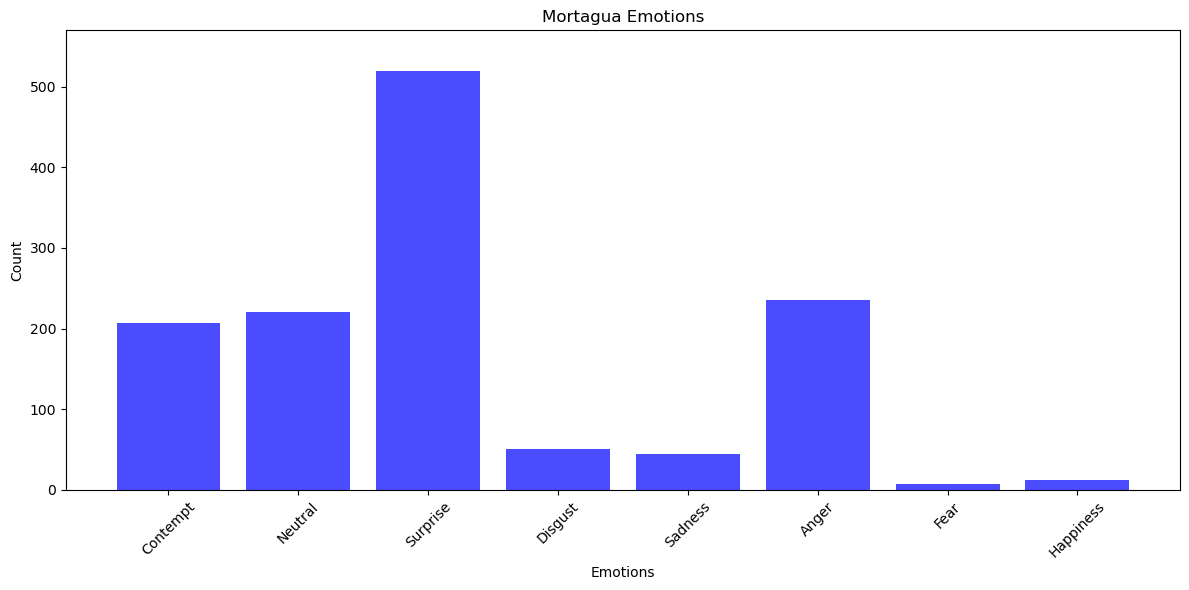

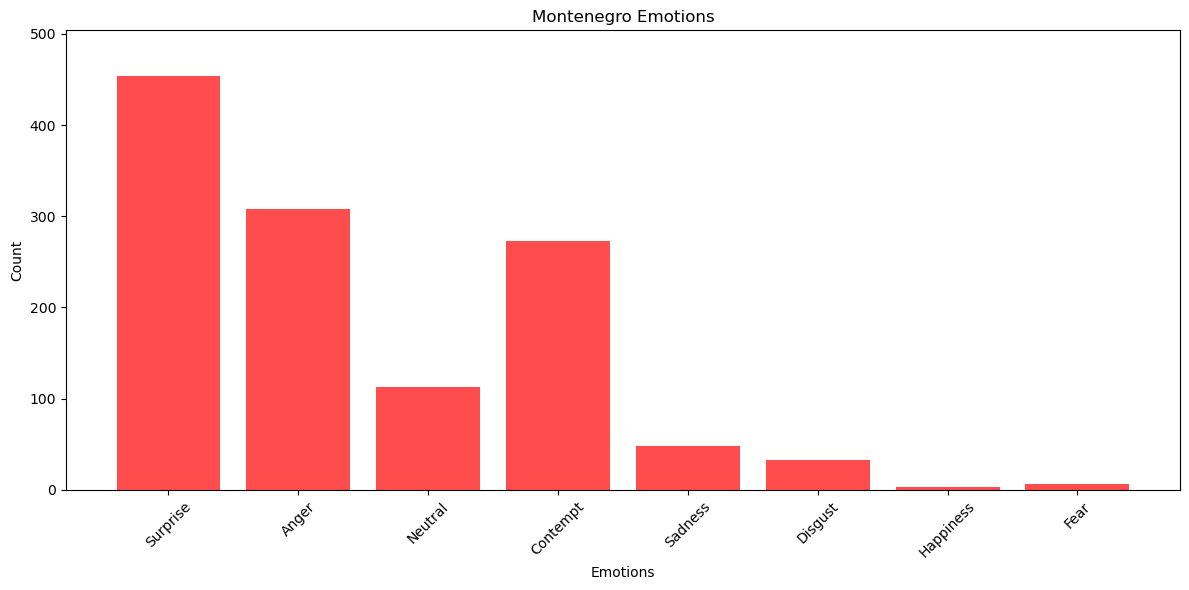

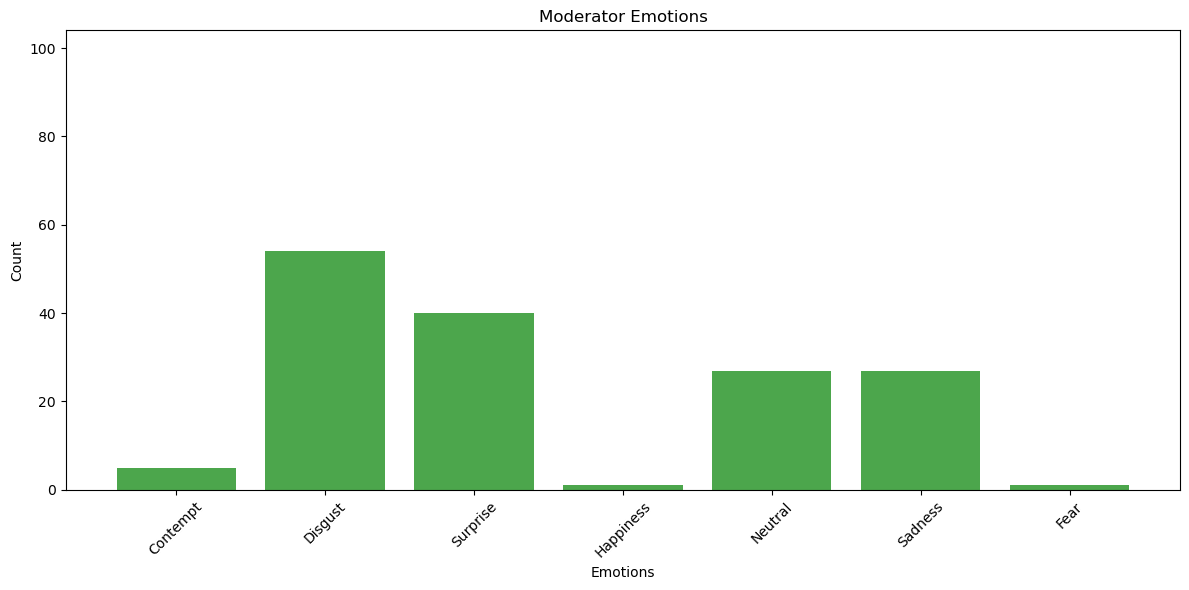

In [19]:
plot_emotions("Mortagua", mortagua_emotions, 'b')
plot_emotions("Montenegro", montenegro_emotions, 'r')
plot_emotions("Moderator", moderator_emotions, 'g')

<a id="section3.2"></a>

## 3.2 AD-CDU

In [20]:
debate = 'ad-cdu'

num_clusters = 6
embeddings_umap, cluster_labels = UMAP_with_kmeans(dfs, debate, random_seed, num_clusters)
C1 = plot_clusters(embeddings_umap, cluster_labels, num_clusters)

C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


In [21]:
C1_modified = C1.copy()
cluster_to_plot = 4

# Remove outliers from moderator 
del C1_modified[4][0:9]
del C1_modified[4][109:]

# Plot specific cluster (if needed)
# plot_specific_cluster(cluster_to_plot-1, C1_modified, debate, 100)

# Define cluster names
cluster_names = {
    1: 'Raimundo vs Montenegro',
    2: 'Montenegro',
    3: 'Raimundo', 
    4: 'Panorama',
    5: 'Moderator',
    6: 'Raimundo w/ Moderator',
}

# Remove the irrelevant clusters 
C1_modified = remove_clusters(C1_modified, cluster_names, ['Panorama', 'Raimundo w/ Moderator'])

# Update cluster names
cluster_names = {
    1: 'Raimundo vs Montenegro',
    2: 'Montenegro',
    3: 'Raimundo', 
    4: 'Moderator'
}

Montenegro Emotions: defaultdict(<class 'int'>, {'Sadness': 917, 'Neutral': 577, 'Surprise': 305, 'Fear': 167, 'Disgust': 39, 'Happiness': 2, 'Contempt': 316, 'Anger': 213})
Raimundo Emotions: defaultdict(<class 'int'>, {'Anger': 271, 'Contempt': 38, 'Neutral': 355, 'Sadness': 367, 'Surprise': 282, 'Happiness': 6, 'Disgust': 64, 'Fear': 57})
Moderator Emotions: defaultdict(<class 'int'>, {'Happiness': 13, 'Sadness': 71, 'Contempt': 26, 'Disgust': 14, 'Surprise': 36, 'Neutral': 29, 'Anger': 4, 'Fear': 3})


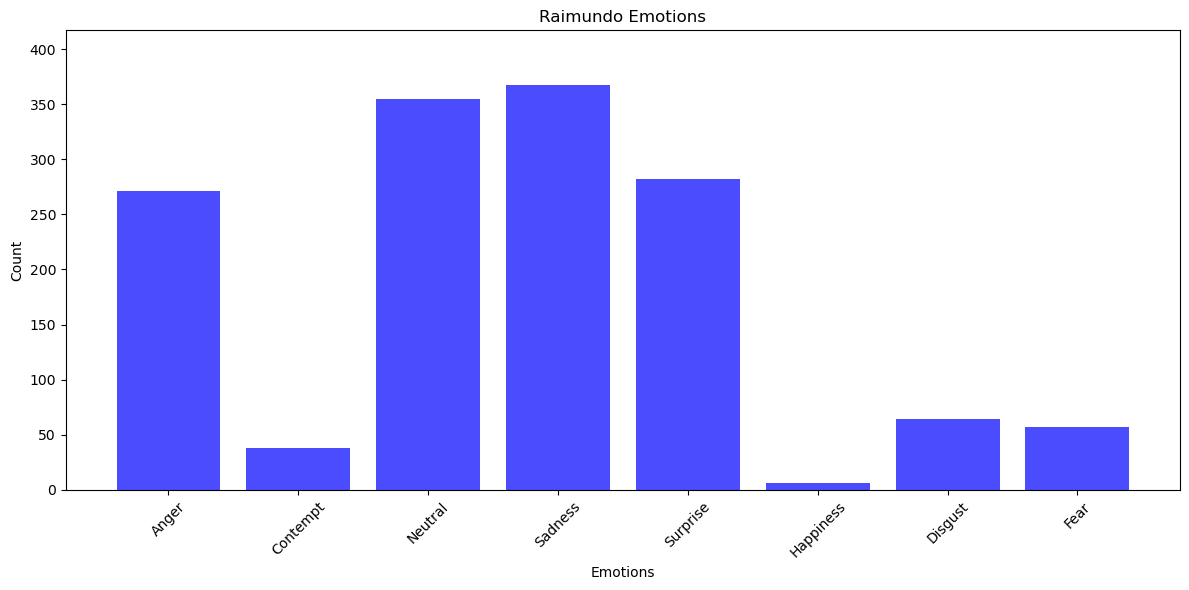

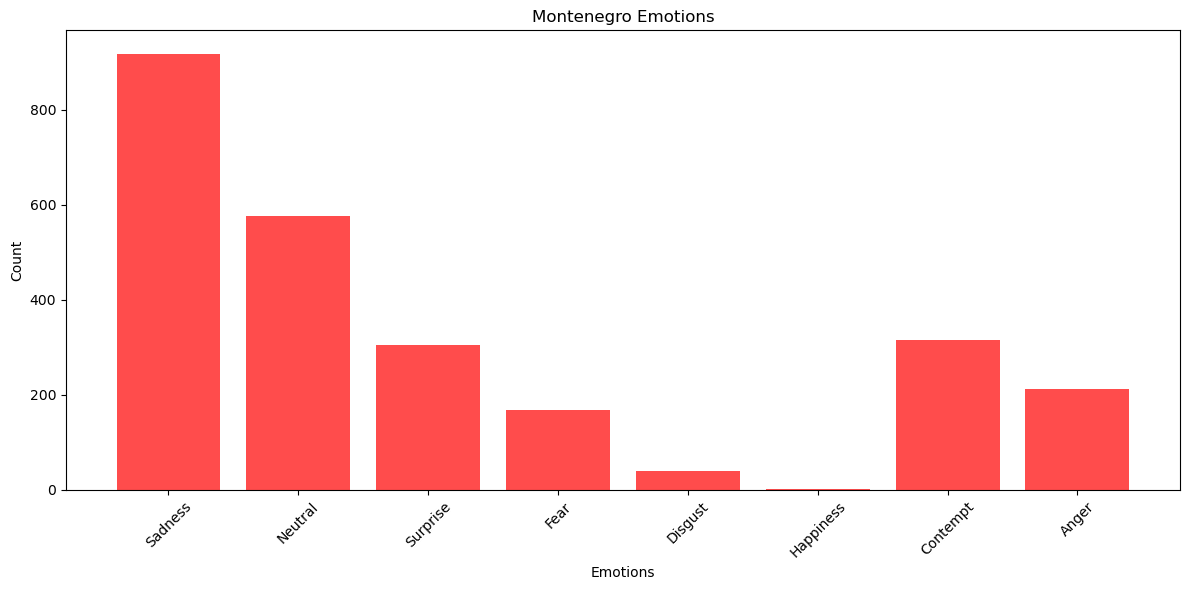

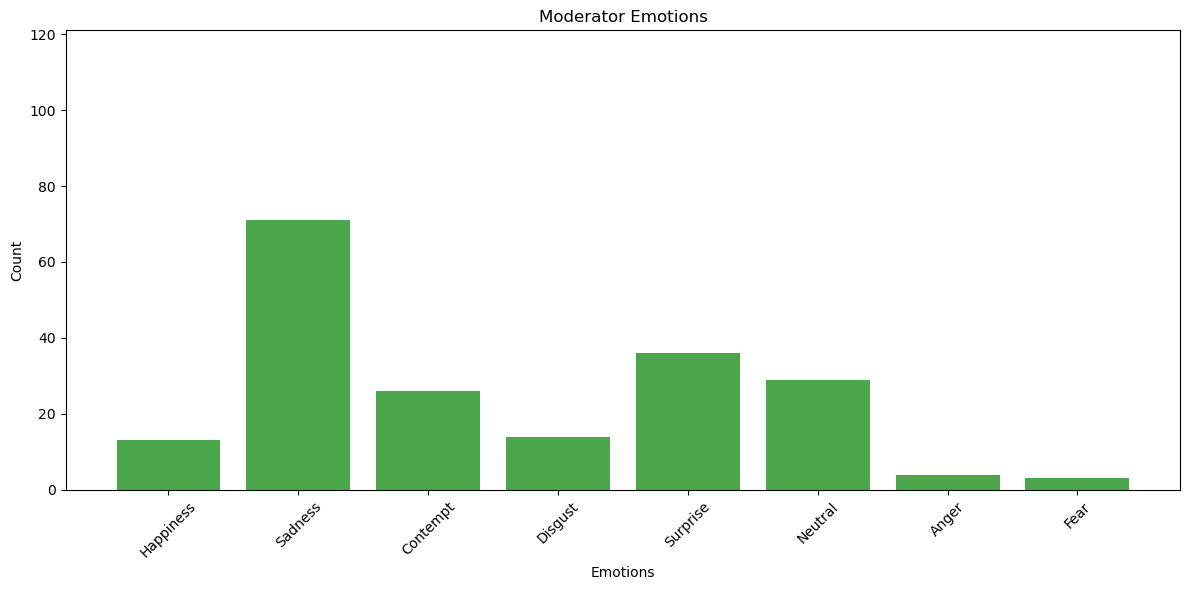

In [22]:
both_candidates_same_frame_index = C1_modified[0]
df_both_candidates_same_frame = dfs[debate].iloc[both_candidates_same_frame_index]

# Get the value from the database of the index obtained from the clustering
df_only_montenegro_index, df_only_raimundo_index, df_moderator_index = C1_modified[1], C1_modified[2], C1_modified[3]
df_only_montenegro, df_only_raimundo, df_moderator = dfs[debate].iloc[df_only_montenegro_index], dfs[debate].iloc[df_only_raimundo_index], dfs[debate].iloc[df_moderator_index]

# Get the box locations for each frame 1v1
all_locations = get_location_for_frame(df_both_candidates_same_frame, False)

# Through inference we can assume the left person is always Mortágua and the right person is always Montenegro
raimundo1v1, montenegro1v1 = get_location_for_each_candidate(df_both_candidates_same_frame)

raimundo_emotions = get_emotions(df_only_raimundo , raimundo1v1, 0)
montenegro_emotions = get_emotions(df_only_montenegro, montenegro1v1, 0)
moderator_emotions = get_emotions(df_moderator, df_moderator, 1)

print("Montenegro Emotions:", montenegro_emotions)
print("Raimundo Emotions:", raimundo_emotions)
print("Moderator Emotions:", moderator_emotions)

plot_emotions("Raimundo", raimundo_emotions, 'b')
plot_emotions("Montenegro", montenegro_emotions, 'r')
plot_emotions("Moderator", moderator_emotions, 'g')

emotions[debate]['Montenegro']=montenegro_emotions
emotions[debate]['Raimundo']=raimundo_emotions
emotions[debate]['Joao Adelino Faria']=moderator_emotions

<a id="section3.3"></a>

## 3.3 AD-CHEGA

In [23]:
debate = 'ad-chega'

num_clusters = 9
embeddings_umap, cluster_labels = UMAP_with_kmeans(dfs, debate, random_seed, num_clusters)
C1 = plot_clusters(embeddings_umap, cluster_labels, num_clusters)

C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


In [24]:
C1_modified = C1.copy()

cluster_to_plot = 4



print(len(C1_modified[cluster_to_plot-1]))

# Plot specific cluster (if needed)
# plot_specific_cluster(cluster_to_plot-1, C1_modified, debate, 100)

# Define cluster names
cluster_names = {
    1: 'Ventura',
    2: 'Montenegro vs Ventura',
    3: 'Montenegro', 
    4: 'Moderator',
    5: 'Panorama',
    6: 'Montenegro vs Ventura',
    7: 'Panorama2',
    8: 'Moderator',
    9: 'Montenegro',
}

# Merge clusters
merged_sorted_values = sorted(C1_modified[1] + C1_modified[5])
C1_modified[1] = merged_sorted_values
merged_sorted_values = sorted(C1_modified[2] + C1_modified[8])
C1_modified[2] = merged_sorted_values
merged_sorted_values = sorted(C1_modified[3] + C1_modified[7])
C1_modified[3] = merged_sorted_values


# Remove the irrelevant clusters 
C1_modified = remove_clusters(C1_modified, cluster_names, ['Panorama', 'Panorama2'])

# Update cluster names
cluster_names = {
    1: 'Ventura',
    2: 'Montenegro vs Ventura',
    3: 'Montenegro', 
    4: 'Moderator',
}

print(len(C1_modified[cluster_to_plot-1]))



165
211


Ventura Emotions: defaultdict(<class 'int'>, {'Contempt': 78, 'Happiness': 14, 'Neutral': 81, 'Sadness': 145, 'Surprise': 546, 'Disgust': 7, 'Anger': 2})
Montenegro Emotions: defaultdict(<class 'int'>, {'Disgust': 23, 'Contempt': 357, 'Anger': 500, 'Surprise': 163, 'Sadness': 45, 'Happiness': 41, 'Neutral': 122})
Moderator Emotions: defaultdict(<class 'int'>, {'Happiness': 11, 'Neutral': 212, 'Disgust': 92, 'Contempt': 41, 'Fear': 41, 'Sadness': 129, 'Anger': 61, 'Surprise': 52})


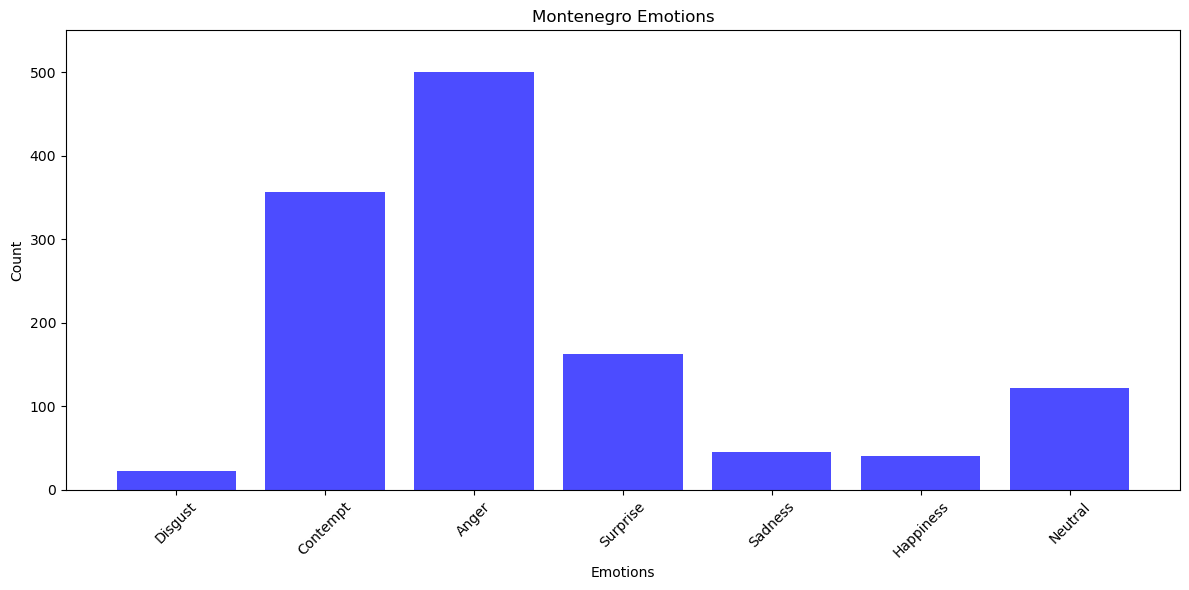

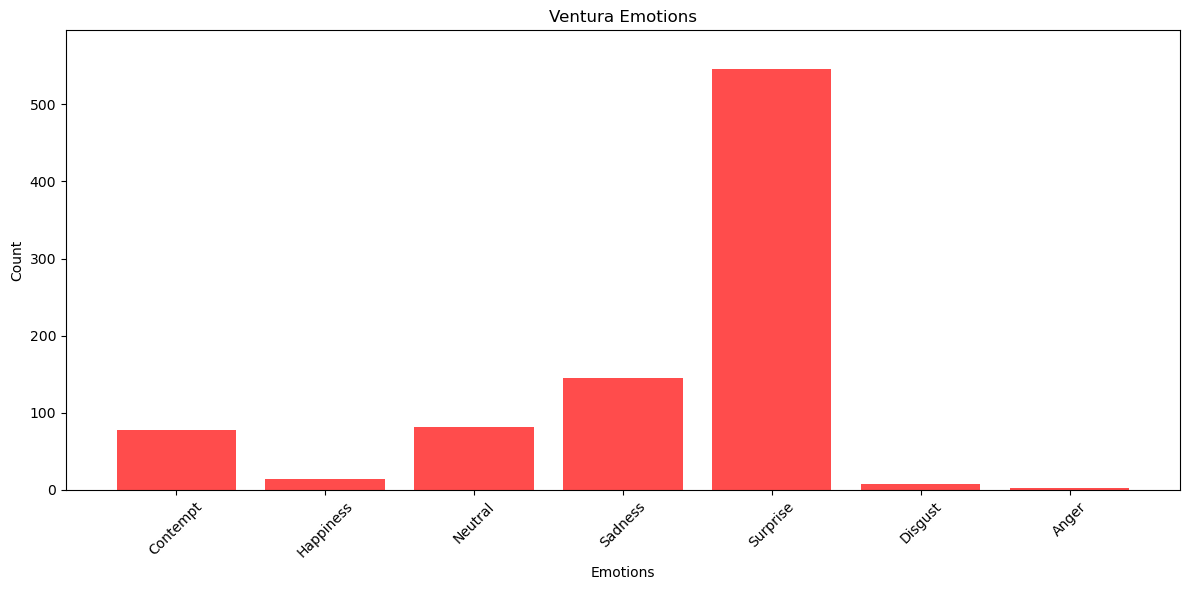

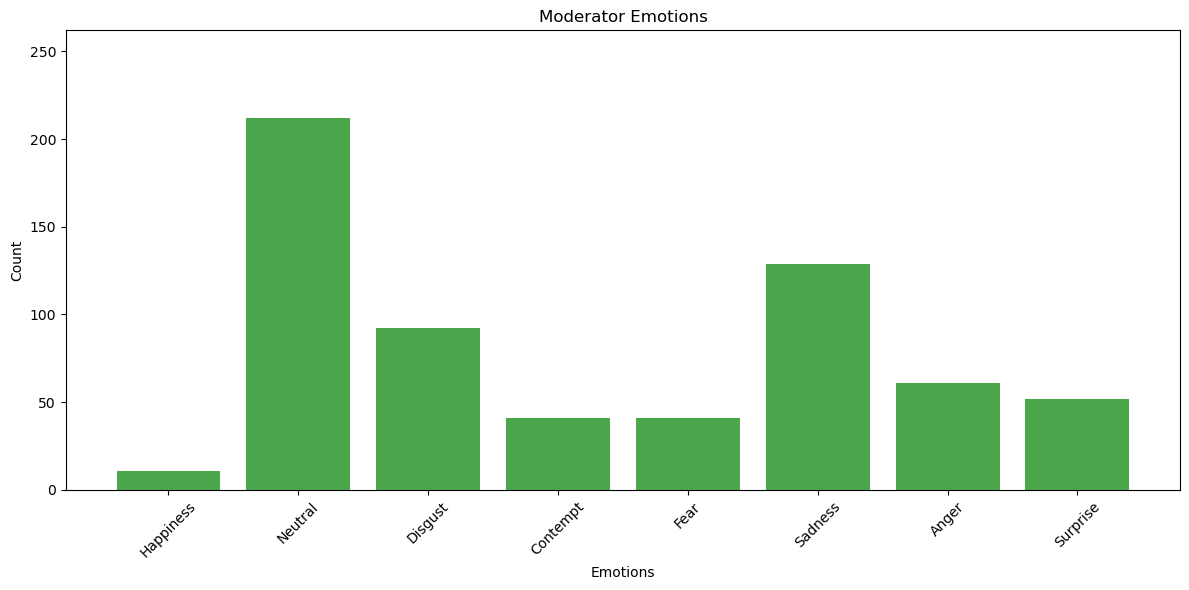

In [25]:
df_both_candidates_same_frame = dfs[debate].iloc[C1_modified[1]].copy()

# Get the value from the database of the index obtained from the clustering
df_only_ventura = dfs[debate].iloc[C1_modified[0]].copy()
df_only_montenegro = dfs[debate].iloc[C1_modified[2]].copy()
df_moderator = dfs[debate].iloc[C1_modified[3]].copy()

df_both_candidates_same_frame = remove_translator1v1(df_both_candidates_same_frame)
df_only_ventura = remove_translator(df_only_ventura)
df_only_montenegro = remove_translator(df_only_montenegro)
df_moderator = remove_translator(df_moderator)

montenegro1v1, ventura1v1 = get_location_for_each_candidate(df_both_candidates_same_frame)

montenegro_emotions = get_emotions(df_only_montenegro , montenegro1v1, 0)
ventura_emotions = get_emotions(df_only_ventura, ventura1v1, 0)
moderator_emotions = get_emotions(df_moderator, df_moderator, 1)

print("Ventura Emotions:", ventura_emotions)
print("Montenegro Emotions:", montenegro_emotions)
print("Moderator Emotions:", moderator_emotions)

plot_emotions("Montenegro", montenegro_emotions, 'b')
plot_emotions("Ventura", ventura_emotions, 'r')
plot_emotions("Moderator", moderator_emotions, 'g')

emotions[debate]['Ventura']=ventura_emotions
emotions[debate]['Montenegro']=montenegro_emotions
emotions[debate]['Joao Adelino Faria']=moderator_emotions

<a id="section3.4"></a>

## 3.4 AD-IL

In [26]:
debate = 'ad-il'

num_clusters = 5
embeddings_umap, cluster_labels = UMAP_with_kmeans(dfs, debate, random_seed, num_clusters)
C1 = plot_clusters(embeddings_umap, cluster_labels, num_clusters)

C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


In [27]:
C1_modified = C1.copy()

cluster_to_plot = 4

# Remove outliers
del C1_modified[1][0:5]
del C1_modified[4][0:4]

# Plot specific cluster (if needed)
# plot_specific_cluster(cluster_to_plot-1, C1_modified, debate, 100)


print(len(C1_modified[1]))
# Define cluster names
cluster_names = {
    1: 'Panorama',
    2: 'Rocha vs Montenegro',
    3: 'Montenegro', 
    4: 'Rocha',
    5: 'Moderator',
}

# Remove the irrelevant clusters 
C1_modified = remove_clusters(C1_modified, cluster_names, ['Panorama'])

# Update cluster names
cluster_names = {
    1: 'Rocha vs Montenegro',
    2: 'Montenegro', 
    3: 'Rocha',
    4: 'Moderator',
}

638


Montenegro Emotions: defaultdict(<class 'int'>, {'Sadness': 462, 'Disgust': 429, 'Surprise': 204, 'Neutral': 580, 'Happiness': 22, 'Contempt': 180, 'Anger': 24, 'Fear': 63})
Rocha Emotions: defaultdict(<class 'int'>, {'Surprise': 137, 'Sadness': 514, 'Neutral': 848, 'Fear': 96, 'Disgust': 181, 'Happiness': 8, 'Contempt': 5, 'Anger': 5})
Moderator Emotions: defaultdict(<class 'int'>, {'Contempt': 6, 'Disgust': 13, 'Neutral': 155, 'Surprise': 85, 'Sadness': 127, 'Fear': 13, 'Anger': 15})


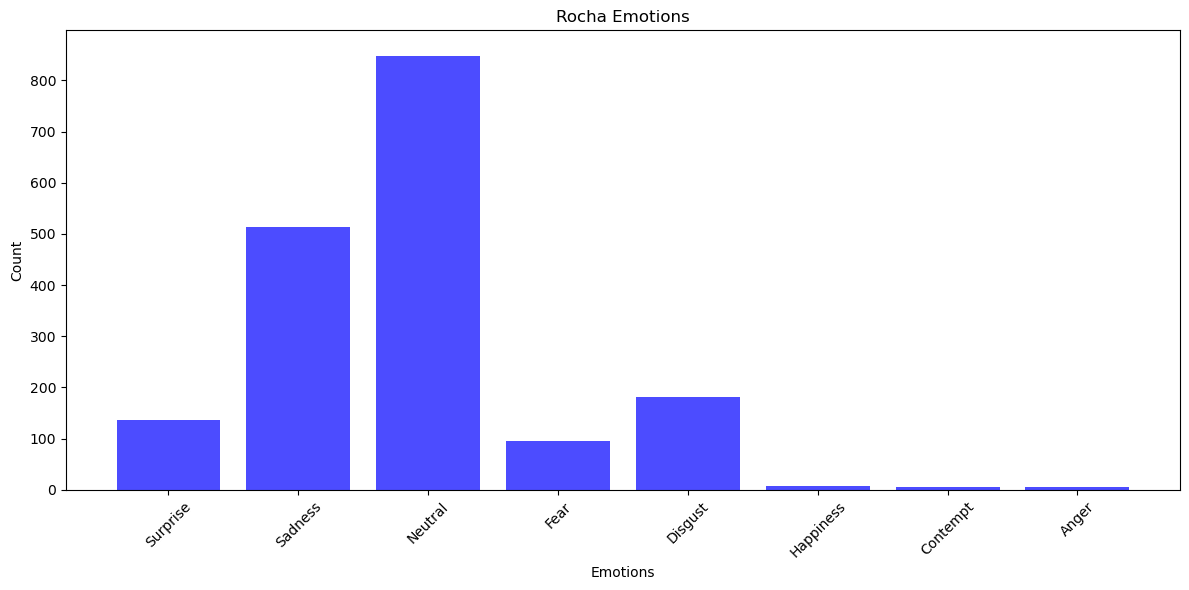

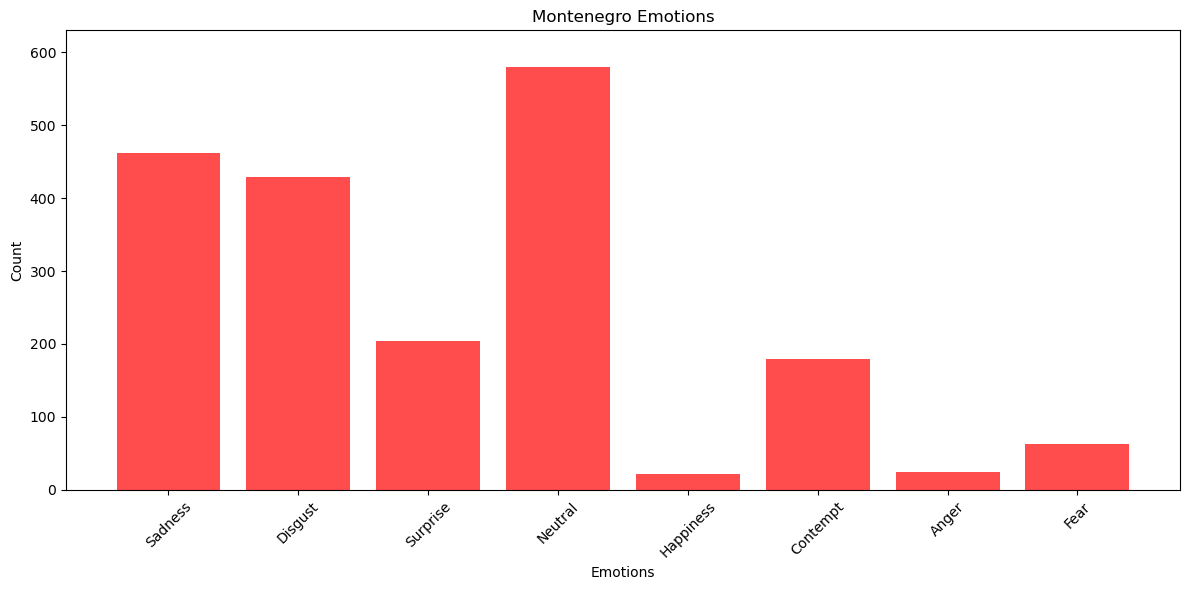

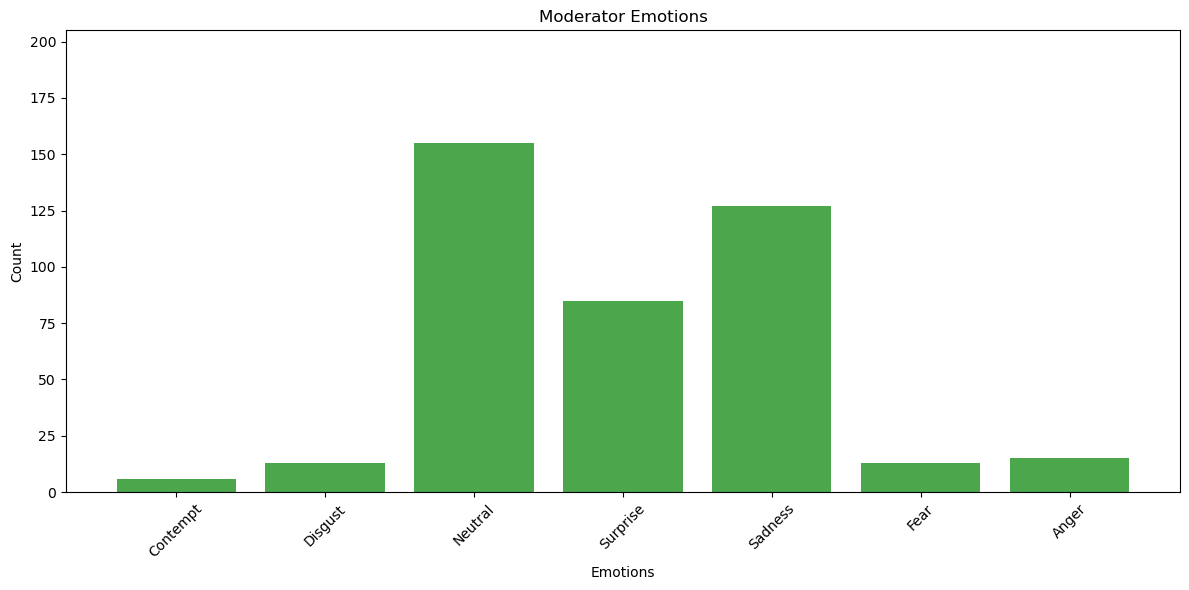

In [28]:
both_candidates_same_frame_index = C1_modified[0]
df_both_candidates_same_frame = dfs[debate].iloc[both_candidates_same_frame_index]

# Get the value from the database of the index obtained from the clustering
df_only_montenegro_index, df_only_rocha_index, df_moderator_index = C1_modified[1], C1_modified[2], C1_modified[3]
df_only_montenegro, df_only_rocha, df_moderator = dfs[debate].iloc[df_only_montenegro_index], dfs[debate].iloc[df_only_rocha_index], dfs[debate].iloc[df_moderator_index]

# Get the box locations for each frame 1v1
all_locations = get_location_for_frame(df_both_candidates_same_frame, False)

# Through inference we can assume the left person is always Mortágua and the right person is always Montenegro
rocha1v1, montenegro1v1 = get_location_for_each_candidate(df_both_candidates_same_frame)

rocha_emotions = get_emotions(df_only_rocha , rocha1v1, 0)
montenegro_emotions = get_emotions(df_only_montenegro, montenegro1v1, 0)
moderator_emotions = get_emotions(df_moderator, df_moderator, 1)

print("Montenegro Emotions:", montenegro_emotions)
print("Rocha Emotions:", rocha_emotions)
print("Moderator Emotions:", moderator_emotions)

plot_emotions("Rocha", rocha_emotions, 'b')
plot_emotions("Montenegro", montenegro_emotions, 'r')
plot_emotions("Moderator", moderator_emotions, 'g')

emotions[debate]['Montenegro']=montenegro_emotions
emotions[debate]['Rocha']=rocha_emotions
emotions[debate]['Joao Adelino Faria']=moderator_emotions

<a id="section3.5"></a>

## 3.5 AD-LIVRE

In [29]:
debate = 'ad-livre'

num_clusters = 5
embeddings_umap, cluster_labels = UMAP_with_kmeans(dfs, debate, random_seed, num_clusters)
C1 = plot_clusters(embeddings_umap, cluster_labels, num_clusters)

C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


In [30]:
C1_modified = C1.copy()
cluster_to_plot = 2

# Remove outliers
del C1_modified[0][0:7]
del C1_modified[0][262:]
del C1_modified[1][0:3]

# Plot specific cluster (if needed)
# plot_specific_cluster(cluster_to_plot-1, C1_modified, debate, 100)



print(len(C1_modified[1]))
# Define cluster names
cluster_names = {
    1: 'Tavares vs Montenegro',
    2: 'Montenegro',
    3: 'Tavares', 
    4: 'Moderator',
    5: 'Panorama',
}

# Remove the irrelevant clusters 
C1_modified = remove_clusters(C1_modified, cluster_names, ['Panorama'])

# Update cluster names
cluster_names = {
    1: 'Tavares vs Montenegro',
    2: 'Montenegro',
    3: 'Tavares', 
    4: 'Moderator',
}

273


Montenegro Emotions: defaultdict(<class 'int'>, {'Sadness': 91, 'Anger': 186, 'Neutral': 208, 'Surprise': 187, 'Fear': 31, 'Disgust': 36, 'Contempt': 32, 'Happiness': 15})
Tavares Emotions: defaultdict(<class 'int'>, {'Neutral': 137, 'Surprise': 311, 'Anger': 368, 'Disgust': 5, 'Fear': 3, 'Happiness': 4, 'Contempt': 22, 'Sadness': 45})
Moderator Emotions: defaultdict(<class 'int'>, {'Sadness': 34, 'Neutral': 288, 'Disgust': 49, 'Anger': 51, 'Surprise': 50, 'Fear': 35, 'Contempt': 1})


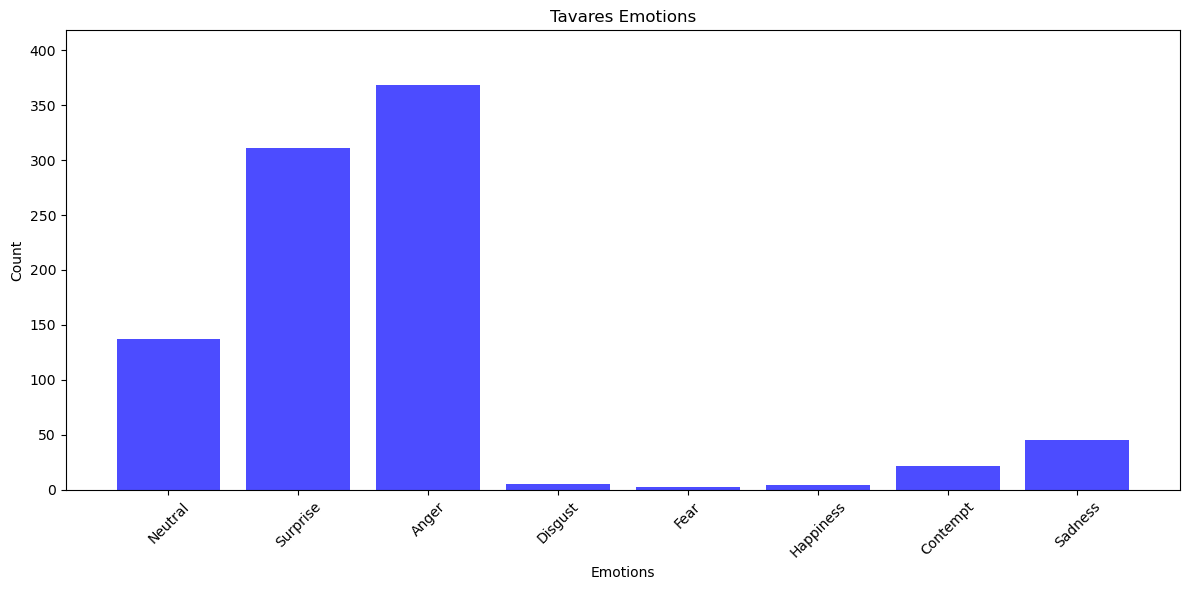

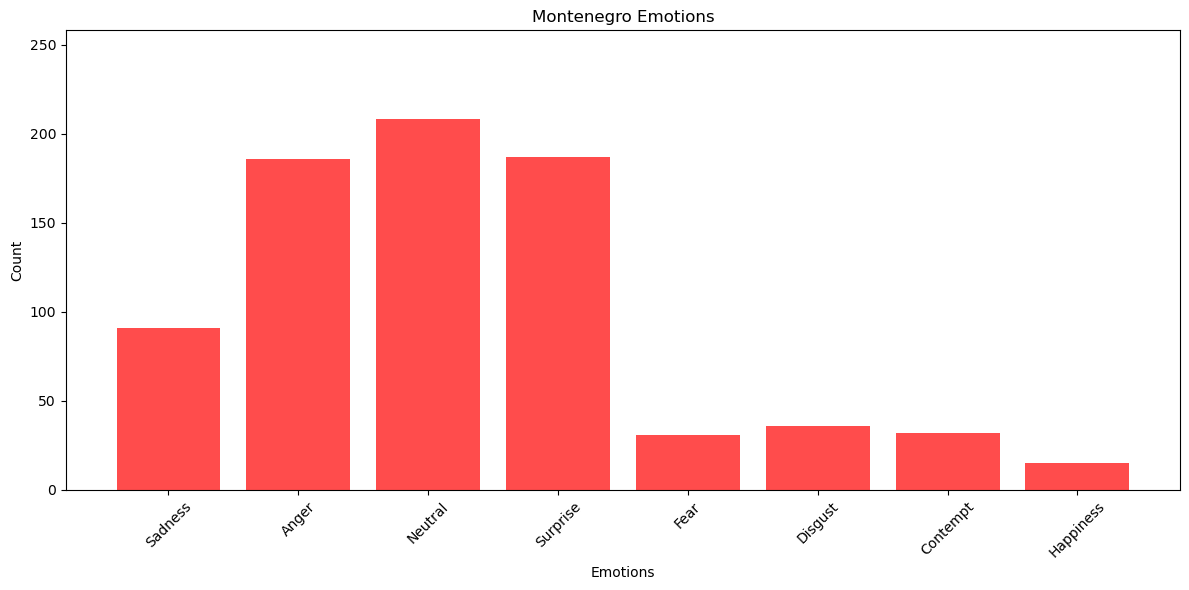

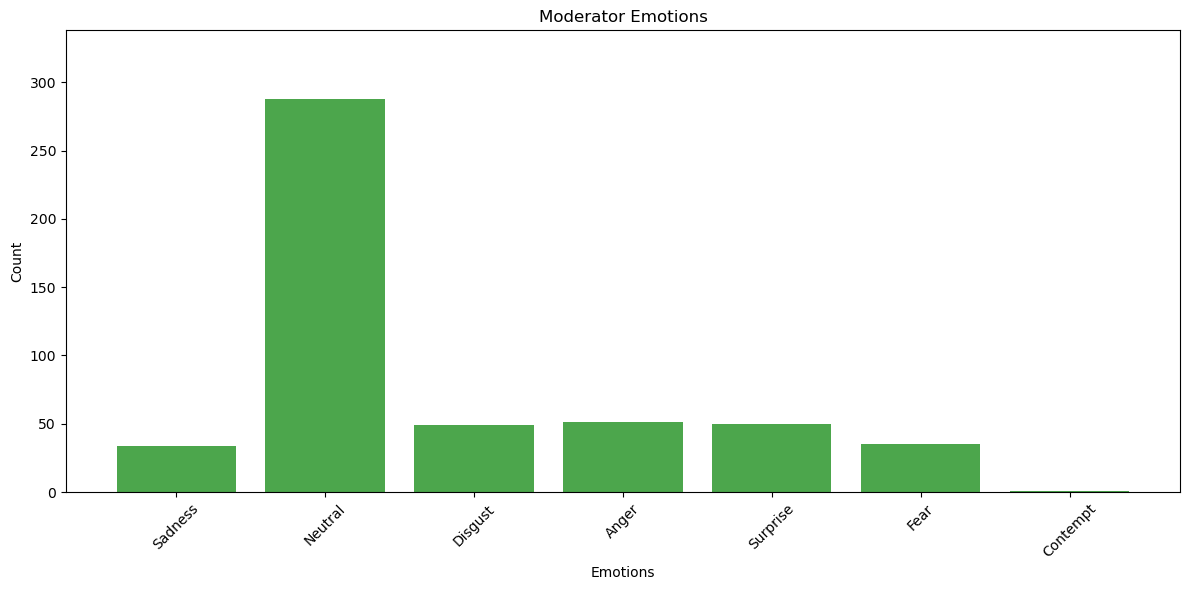

In [31]:
df_both_candidates_same_frame = dfs[debate].iloc[C1_modified[0]].copy()

# Get the value from the database of the index obtained from the clustering
df_only_montenegro = dfs[debate].iloc[C1_modified[1]].copy()
df_only_tavares = dfs[debate].iloc[C1_modified[2]].copy()
df_moderator = dfs[debate].iloc[C1_modified[3]].copy()

df_both_candidates_same_frame = remove_translator1v1(df_both_candidates_same_frame)
df_only_montenegro = remove_translator(df_only_montenegro)
df_only_tavares = remove_translator(df_only_tavares)
df_moderator = remove_translator(df_moderator)

tavares1v1, montenegro1v1 = get_location_for_each_candidate(df_both_candidates_same_frame)

tavares_emotions = get_emotions(df_only_tavares , tavares1v1, 0)
montenegro_emotions = get_emotions(df_only_montenegro, montenegro1v1, 0)
moderator_emotions = get_emotions(df_moderator, df_moderator, 1)

print("Montenegro Emotions:", montenegro_emotions)
print("Tavares Emotions:", tavares_emotions)
print("Moderator Emotions:", moderator_emotions)

plot_emotions("Tavares", tavares_emotions, 'b')
plot_emotions("Montenegro", montenegro_emotions, 'r')
plot_emotions("Moderator", moderator_emotions, 'g')

emotions[debate]['Montenegro']=montenegro_emotions
emotions[debate]['Tavares']=tavares_emotions
emotions[debate]['Sara Pinto']=moderator_emotions

<a id="section3.6"></a>

## 3.6 AD-PAN

In [32]:
debate = 'ad-pan'

num_clusters = 6
embeddings_umap, cluster_labels = UMAP_with_kmeans(dfs, debate, random_seed, num_clusters)
C1 = plot_clusters(embeddings_umap, cluster_labels, num_clusters)

C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


In [33]:
C1_modified = C1.copy()
cluster_to_plot = 2

# Plot specific cluster (if needed)
# plot_specific_cluster(cluster_to_plot-1, C1_modified, debate, 100)

# Define cluster names
cluster_names = {
    1: 'Montenegro',
    2: 'Ines vs Montenegro',
    3: 'Ines', 
    4: 'Panorama',
    5: 'Moderator',
    6: 'Ines w/ Moderator',
}

# Remove the irrelevant clusters 
C1_modified = remove_clusters(C1_modified, cluster_names, ['Panorama', 'Ines w/ Moderator'])

# Update cluster names
cluster_names = {
    1: 'Montenegro',
    2: 'Ines vs Montenegro',
    3: 'Ines', 
    4: 'Moderator',
}

Montenegro Emotions: defaultdict(<class 'int'>, {'Disgust': 213, 'Anger': 127, 'Surprise': 181, 'Sadness': 29, 'Contempt': 69, 'Neutral': 79, 'Fear': 9, 'Happiness': 7})
Ines Emotions: defaultdict(<class 'int'>, {'Disgust': 144, 'Neutral': 424, 'Fear': 40, 'Surprise': 120, 'Sadness': 132, 'Anger': 12, 'Contempt': 3, 'Happiness': 3})
Moderator Emotions: defaultdict(<class 'int'>, {'Anger': 39, 'Surprise': 21, 'Neutral': 18, 'Contempt': 7, 'Sadness': 2, 'Disgust': 3})


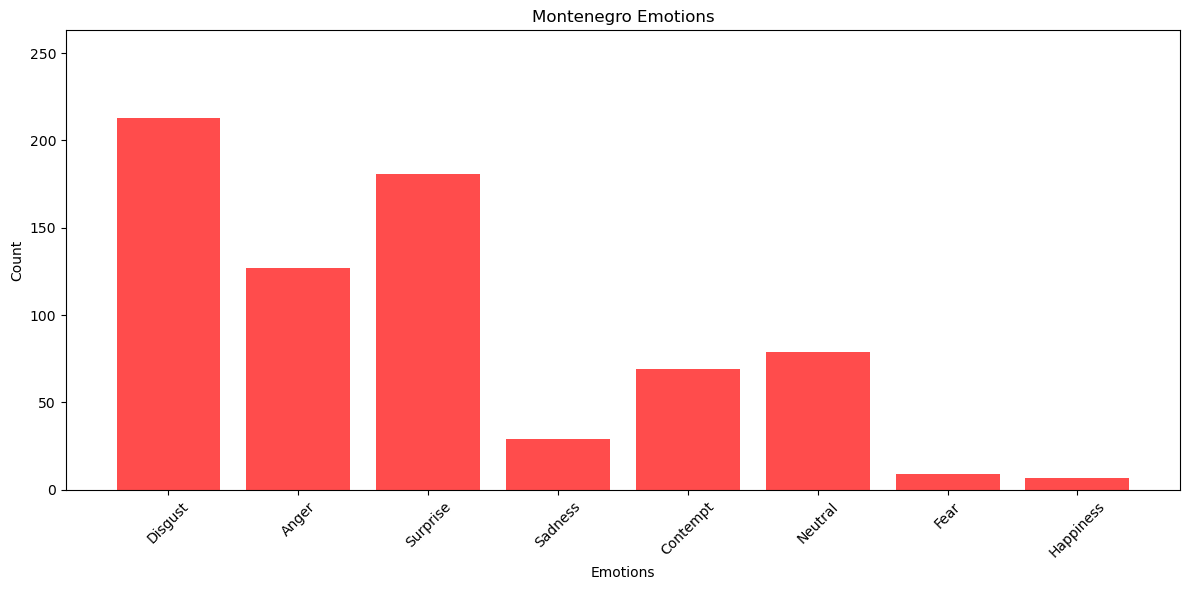

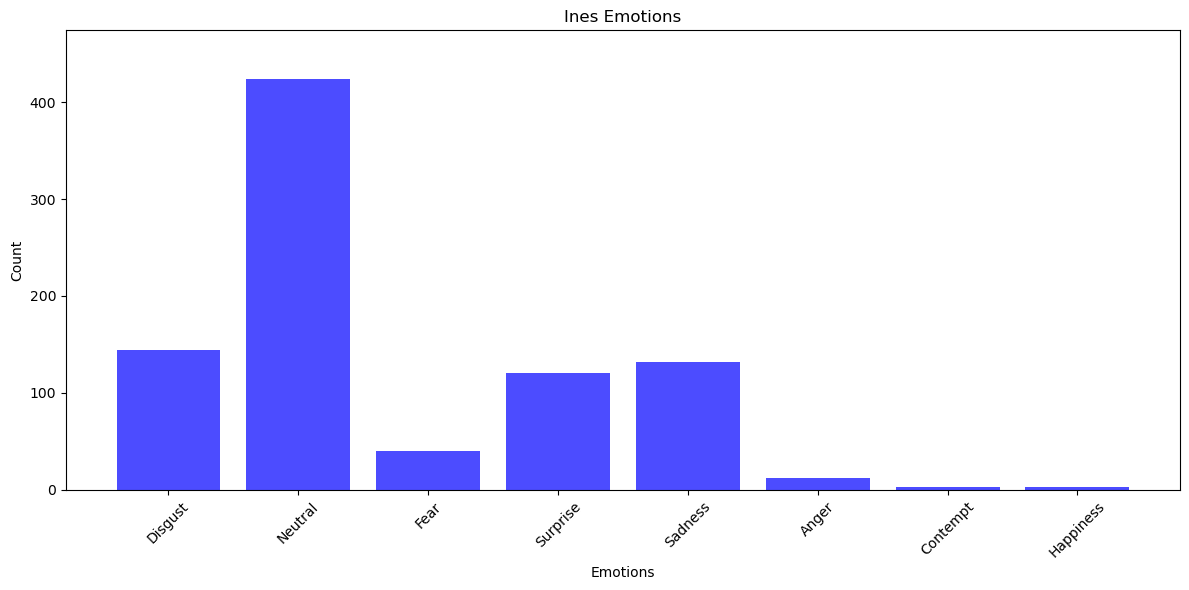

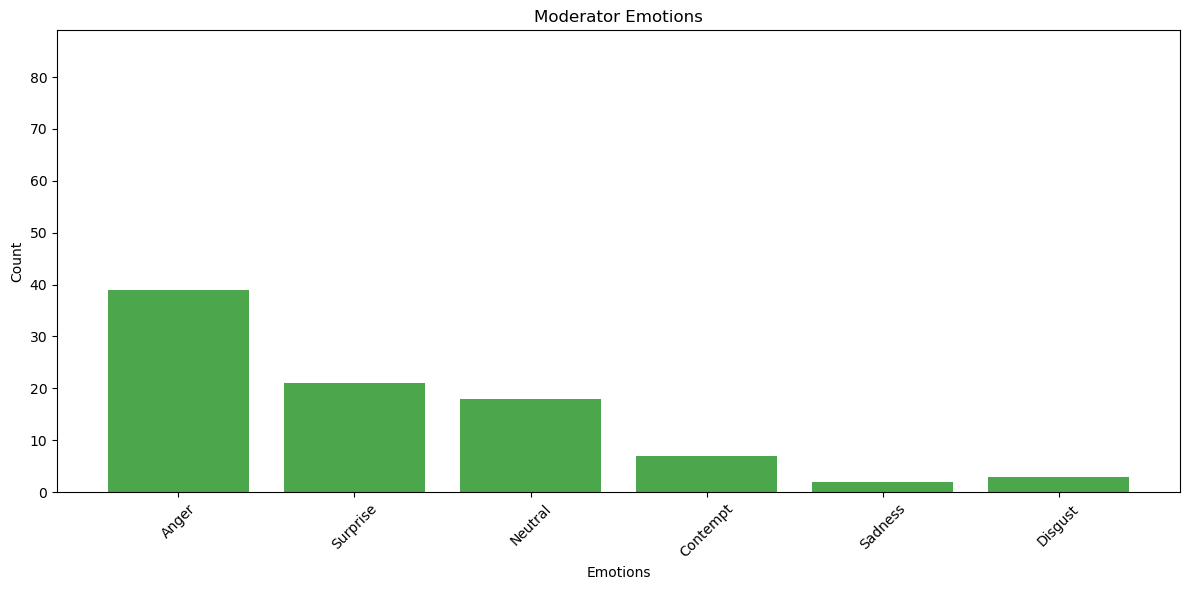

In [34]:
df_both_candidates_same_frame = dfs[debate].iloc[C1_modified[1]].copy()

# Get the value from the database of the index obtained from the clustering
df_only_montenegro, df_only_ines, df_moderator = dfs[debate].iloc[C1_modified[0]], dfs[debate].iloc[C1_modified[2]], dfs[debate].iloc[C1_modified[3]]

ines1v1, montenegro1v1 = get_location_for_each_candidate(df_both_candidates_same_frame)

ines_emotions = get_emotions(df_only_ines , ines1v1, 0)
montenegro_emotions = get_emotions(df_only_montenegro, montenegro1v1, 0)
moderator_emotions = get_emotions(df_moderator, df_moderator, 1)

print("Montenegro Emotions:", montenegro_emotions)
print("Ines Emotions:", ines_emotions)
print("Moderator Emotions:", moderator_emotions)

plot_emotions("Montenegro", montenegro_emotions, 'r')
plot_emotions("Ines", ines_emotions, 'b')
plot_emotions("Moderator", moderator_emotions, 'g')

emotions[debate]['Montenegro']=montenegro_emotions
emotions[debate]['Ines']=ines_emotions
emotions[debate]['Clara de Sousa']=moderator_emotions

<a id="section3.7"></a>

## 3.7 AD-PS

In [35]:
debate = 'ad-ps'

num_clusters = 8
embeddings_umap, cluster_labels = UMAP_with_kmeans(dfs, debate, random_seed, num_clusters)
C1 = plot_clusters(embeddings_umap, cluster_labels, num_clusters)

C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [36]:
C1_modified = copy.deepcopy(C1)
cluster_to_plot = 8
print(len(C1_modified[cluster_to_plot-1]))

# Remove outliers
del C1_modified[3][0]
del C1_modified[7][0:10]
del C1_modified[7][217:]

# Plot specific cluster (if needed)
# plot_specific_cluster(cluster_to_plot-1, C1_modified, debate, 100)

# Define cluster names
cluster_names = {
    1: 'Montenegro',
    2: 'Pedro',
    3: 'SaraPinto', 
    4: 'Pedro vs Montenegro',
    5: 'ClaraDeSousa',
    6: 'Panorama',
    7: 'Irrelevant',
    8: 'JoaoAdelinoFaria',
}

# Remove the irrelevant clusters 
C1_modified = remove_clusters(C1_modified, cluster_names, ['Panorama', 'Irrelevant'])

# Update cluster names
cluster_names = {
    1: 'Montenegro',
    2: 'Pedro',
    3: 'SaraPinto', 
    4: 'Pedro vs Montenegro',
    5: 'ClaraDeSousa',
    6: 'JoaoAdelinoFaria'
}

173


Montenegro Emotions: defaultdict(<class 'int'>, {'Anger': 1021, 'Sadness': 67, 'Contempt': 235, 'Neutral': 472, 'Surprise': 558, 'Happiness': 10, 'Disgust': 43, 'Fear': 7})
Pedro Emotions: defaultdict(<class 'int'>, {'Neutral': 1664, 'Surprise': 338, 'Sadness': 165, 'Anger': 62, 'Contempt': 16, 'Disgust': 36, 'Fear': 4, 'Happiness': 2})
Sara Pinto Emotions: defaultdict(<class 'int'>, {'Neutral': 42, 'Contempt': 13, 'Disgust': 21, 'Surprise': 60, 'Sadness': 25, 'Anger': 4, 'Fear': 5})
Clara de Sousa Emotions: defaultdict(<class 'int'>, {'Sadness': 82, 'Disgust': 109, 'Fear': 155, 'Anger': 114, 'Neutral': 365, 'Surprise': 65, 'Happiness': 6})
Joao Adelino Faria Emotions: defaultdict(<class 'int'>, {'Neutral': 87, 'Surprise': 43, 'Contempt': 22, 'Anger': 6, 'Disgust': 1, 'Sadness': 3, 'Happiness': 1})


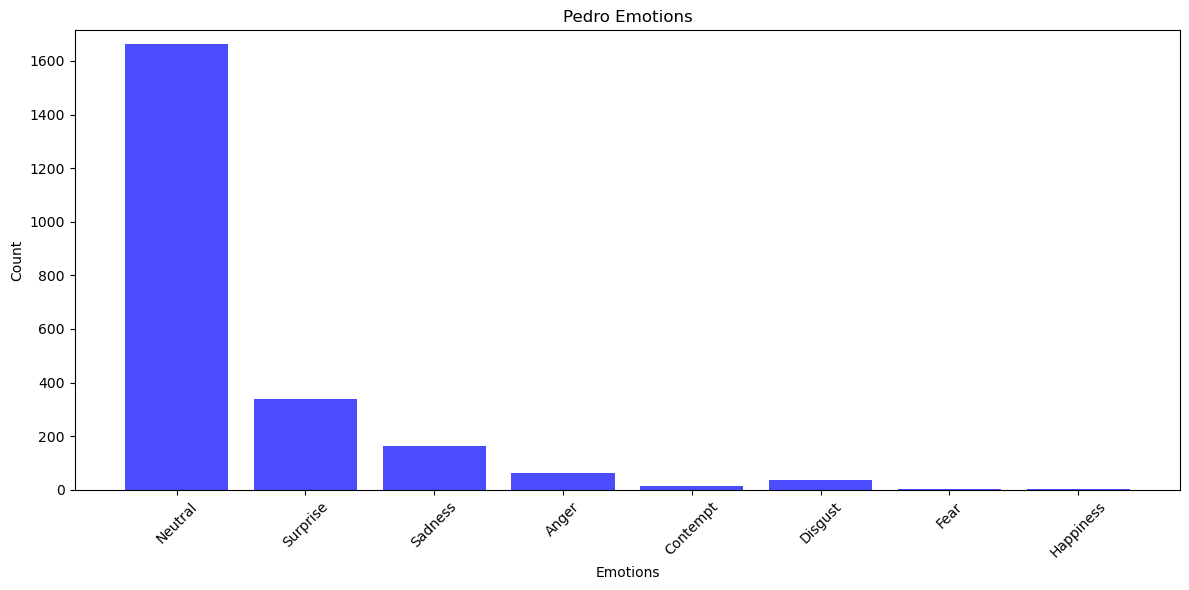

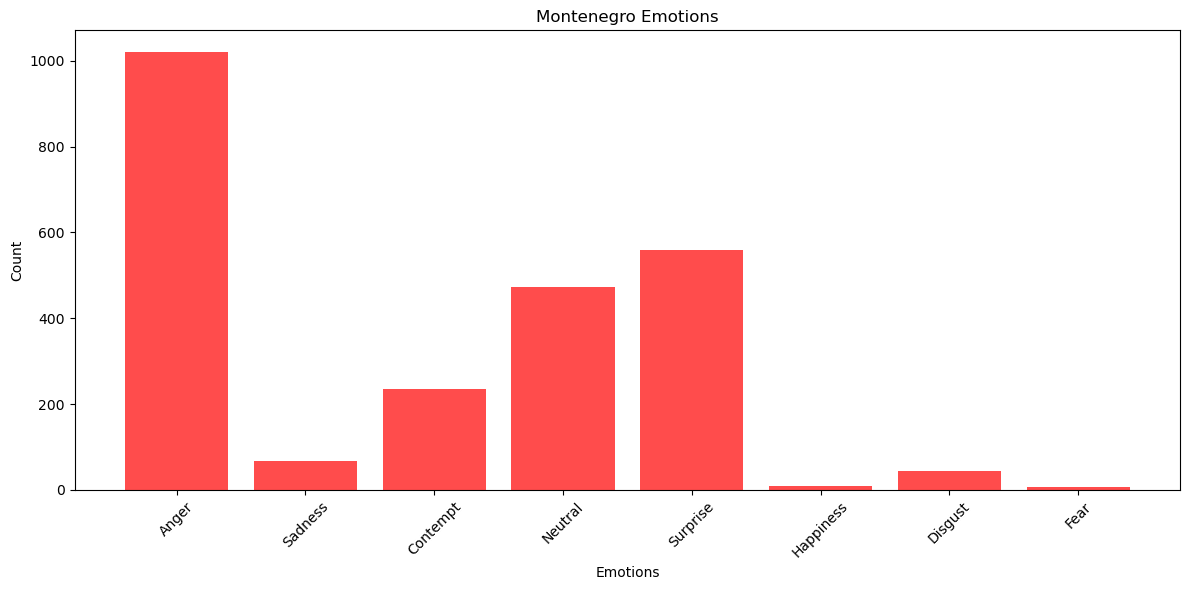

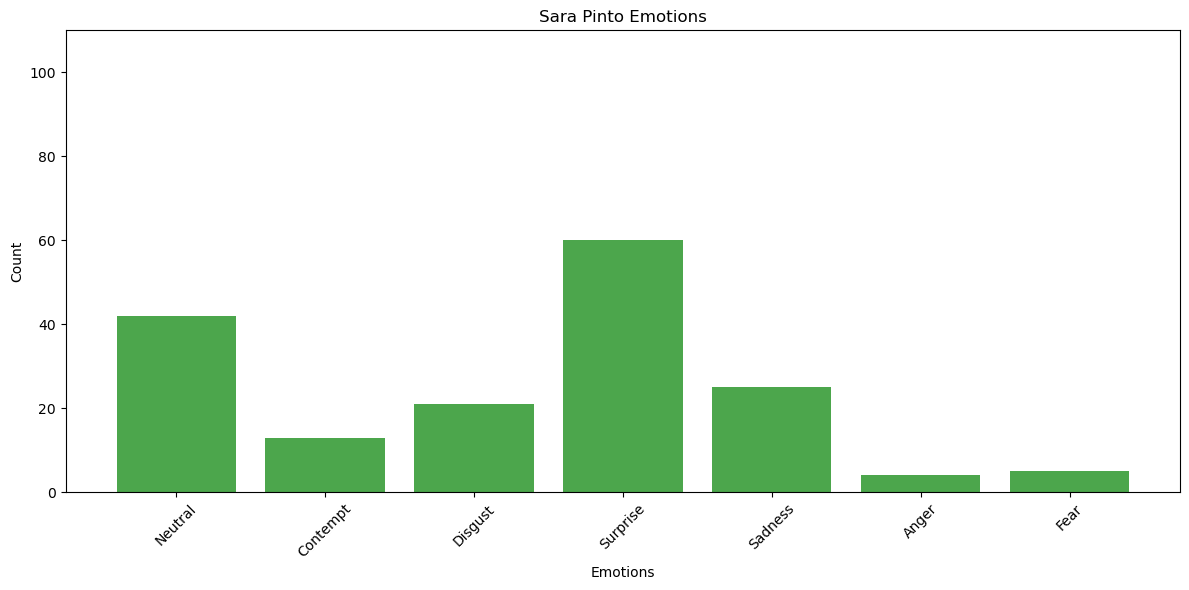

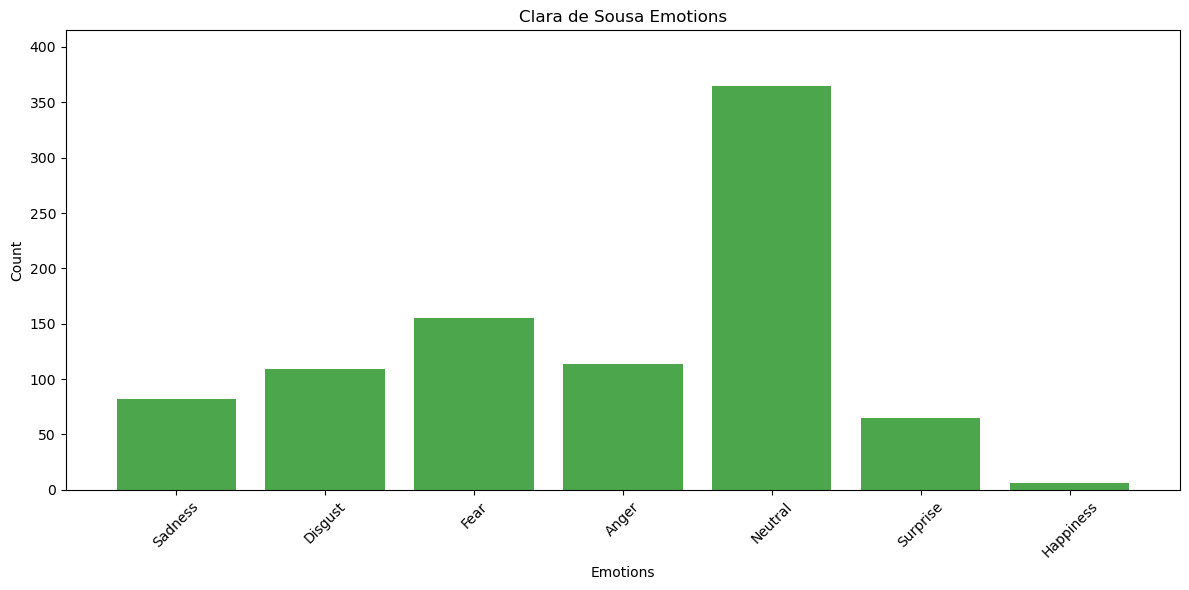

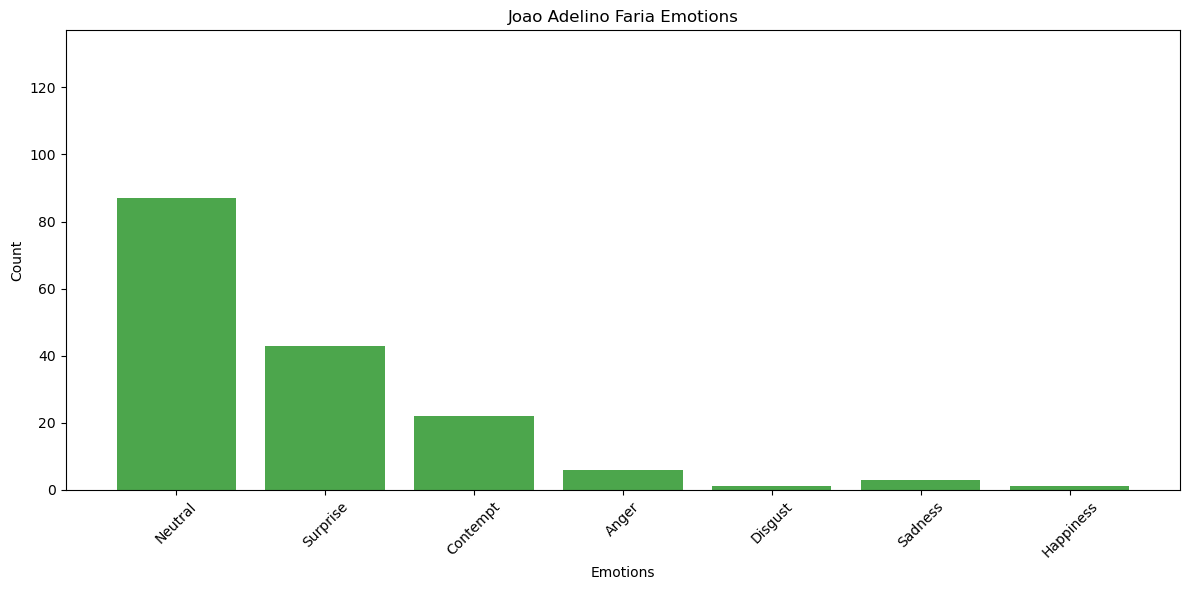

In [37]:
df_both_candidates_same_frame = copy.deepcopy(dfs[debate].iloc[C1_modified[3]])

# Get the value from the database of the index obtained from the clustering
df_only_montenegro = copy.deepcopy(dfs[debate].iloc[C1_modified[0]])
df_only_pedro = copy.deepcopy(dfs[debate].iloc[C1_modified[1]])

df_saraPinto = copy.deepcopy(dfs[debate].iloc[C1_modified[2]])
df_claraDeSousa = copy.deepcopy(dfs[debate].iloc[C1_modified[4]])
df_joaoAdelinoFaria = copy.deepcopy(dfs[debate].iloc[C1_modified[5]])

df_both_candidates_same_frame = remove_translator1v1(df_both_candidates_same_frame)
df_only_montenegro = remove_translator(df_only_montenegro)
df_only_pedro = remove_translator(df_only_pedro)

df_saraPinto = remove_translator(df_saraPinto)
df_claraDeSousa = remove_translator(df_claraDeSousa)
df_joaoAdelinoFaria = remove_translator(df_joaoAdelinoFaria)

pedro1v1, montenegro1v1 = get_location_for_each_candidate(df_both_candidates_same_frame)

pedro_emotions = get_emotions(df_only_pedro , pedro1v1, 0)
montenegro_emotions = get_emotions(df_only_montenegro, montenegro1v1, 0)

saraPinto_emotions = get_emotions(df_saraPinto, df_saraPinto, 1)
claraDeSousa_emotions = get_emotions(df_claraDeSousa, df_claraDeSousa, 1)
joaoAdelinoFaria_emotions = get_emotions(df_joaoAdelinoFaria, df_joaoAdelinoFaria, 1)

print("Montenegro Emotions:", montenegro_emotions)
print("Pedro Emotions:", pedro_emotions)

print("Sara Pinto Emotions:", saraPinto_emotions)
print("Clara de Sousa Emotions:", claraDeSousa_emotions)
print("Joao Adelino Faria Emotions:", joaoAdelinoFaria_emotions)

plot_emotions("Pedro", pedro_emotions, 'b')
plot_emotions("Montenegro", montenegro_emotions, 'r')

plot_emotions("Sara Pinto", saraPinto_emotions, 'g')
plot_emotions("Clara de Sousa", claraDeSousa_emotions, 'g')
plot_emotions("Joao Adelino Faria", joaoAdelinoFaria_emotions, 'g')

emotions[debate]['Montenegro']=montenegro_emotions
emotions[debate]['Pedro']=pedro_emotions
emotions[debate]['Clara de Sousa']=claraDeSousa_emotions
emotions[debate]['Sara Pinto']=saraPinto_emotions
emotions[debate]['Joao Adelino Faria']=joaoAdelinoFaria_emotions

<a id="section3.8"></a>

## 3.8 BE-PS

In [38]:
debate = 'be-ps'

num_clusters = 5
embeddings_umap, cluster_labels = UMAP_with_kmeans(dfs, debate, random_seed, num_clusters)
C1 = plot_clusters(embeddings_umap, cluster_labels, num_clusters)

C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


In [39]:
C1_modified = copy.deepcopy(C1)
cluster_to_plot = 5
print(len(C1_modified[cluster_to_plot-1]))

# Remove outliers
del C1_modified[2][512:]
del C1_modified[2][0:9]

# Plot specific cluster (if needed)
# plot_specific_cluster(cluster_to_plot-1, C1_modified, debate, 100)

# Define cluster names
cluster_names = {
    1: 'Mortágua vs Montenegro',
    2: 'Pedro',
    3: 'Mortágua', 
    4: 'Panorama',
    5: 'Moderator',
}

# Remove the irrelevant clusters 
C1_modified = remove_clusters(C1_modified, cluster_names, ['Panorama'])

# Update cluster names
cluster_names = {
    1: 'Mortágua vs Montenegro',
    2: 'Pedro',
    3: 'Mortágua', 
    4: 'Moderator',
}

230


Pedro Emotions: defaultdict(<class 'int'>, {'Neutral': 1168, 'Surprise': 82, 'Contempt': 17, 'Disgust': 1, 'Sadness': 54, 'Anger': 1})
Mortagua Emotions: defaultdict(<class 'int'>, {'Happiness': 4, 'Contempt': 254, 'Neutral': 162, 'Surprise': 807, 'Sadness': 36, 'Disgust': 4, 'Anger': 1, 'Fear': 10})
Moderator Emotions: defaultdict(<class 'int'>, {'Disgust': 43, 'Neutral': 214, 'Fear': 80, 'Surprise': 56, 'Sadness': 164, 'Anger': 20, 'Happiness': 1, 'Contempt': 6})


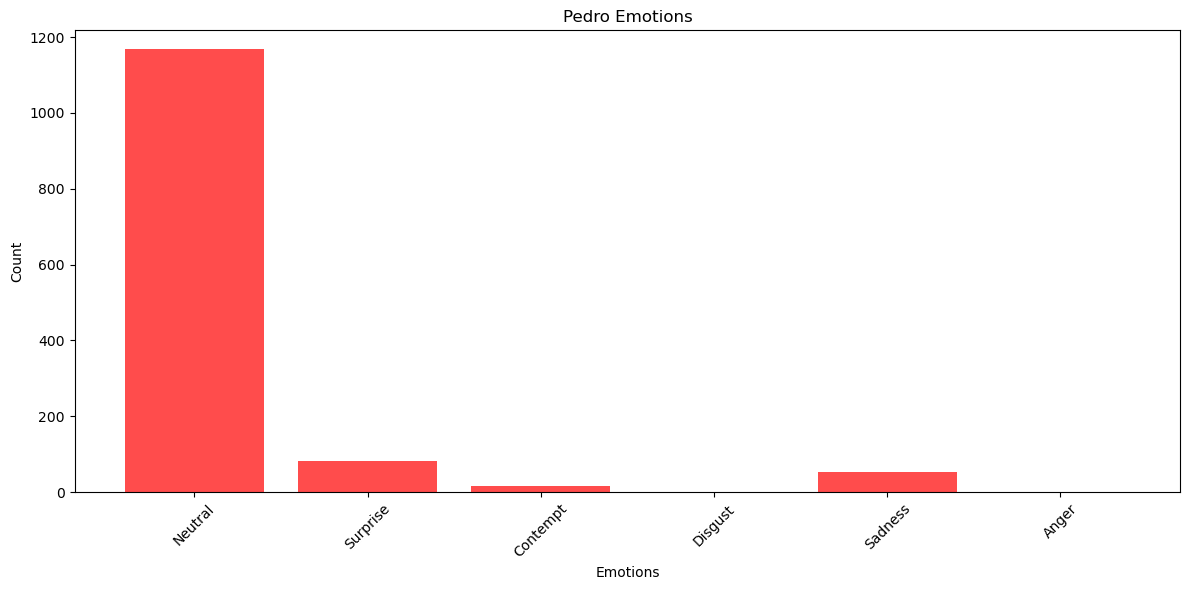

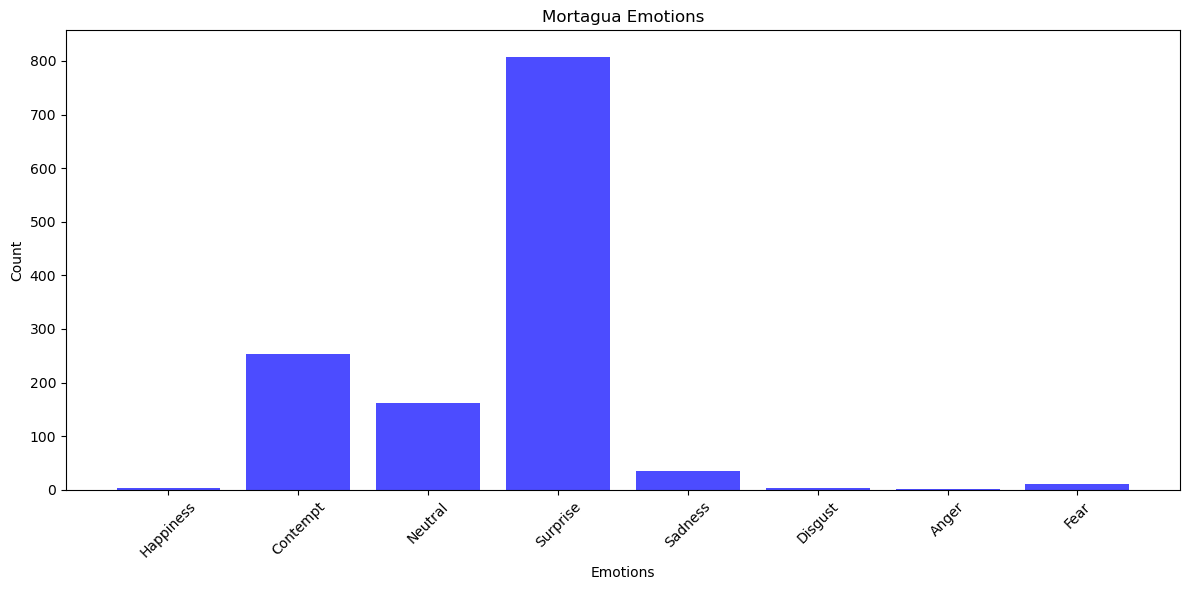

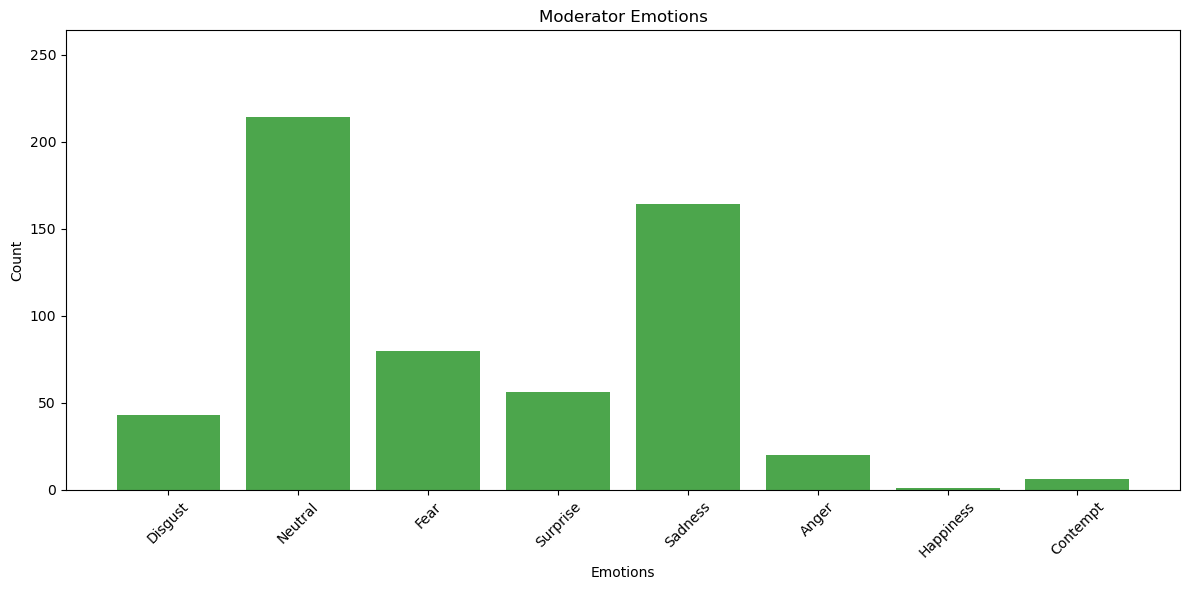

In [40]:
df_both_candidates_same_frame = copy.deepcopy(dfs[debate].iloc[C1_modified[0]])

# Get the value from the database of the index obtained from the clustering
df_only_pedro = copy.deepcopy(dfs[debate].iloc[C1_modified[1]])
df_only_mortagua = copy.deepcopy(dfs[debate].iloc[C1_modified[2]])
df_moderator = copy.deepcopy(dfs[debate].iloc[C1_modified[3]])

df_both_candidates_same_frame = remove_translator1v1(df_both_candidates_same_frame)
df_only_pedro = remove_translator(df_only_pedro)
df_only_mortagua = remove_translator(df_only_mortagua)
df_moderator = remove_translator(df_moderator)

mortagua1v1, pedro1v1 = get_location_for_each_candidate(df_both_candidates_same_frame)

mortagua_emotions = get_emotions(df_only_mortagua , mortagua1v1, 0)
pedro_emotions = get_emotions(df_only_pedro, pedro1v1, 0)
moderator_emotions = get_emotions(df_moderator, df_moderator, 1)

print("Pedro Emotions:", pedro_emotions)
print("Mortagua Emotions:", mortagua_emotions)
print("Moderator Emotions:", moderator_emotions)

plot_emotions("Pedro", pedro_emotions, 'r')
plot_emotions("Mortagua", mortagua_emotions, 'b')
plot_emotions("Moderator", moderator_emotions, 'g')

emotions[debate]['Pedro']=pedro_emotions
emotions[debate]['Mortagua']=mortagua_emotions
emotions[debate]['Joao Adelino Faria']=moderator_emotions

<a id="section3.9"></a>

## 3.9 CDU-BE

In [41]:
debate = 'cdu-be'

num_clusters = 5
embeddings_umap, cluster_labels = UMAP_with_kmeans(dfs, debate, random_seed, num_clusters)
C1 = plot_clusters(embeddings_umap, cluster_labels, num_clusters)

C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


In [42]:
C1_modified = copy.deepcopy(C1)
cluster_to_plot = 5

print(len(C1_modified[cluster_to_plot-1]))

# Remove outliers
del C1_modified[1][0]
del C1_modified[2][0:2]

# Plot specific cluster (if needed)
# plot_specific_cluster(cluster_to_plot-1, C1_modified, debate, 100)

# Define cluster names
cluster_names = {
    1: 'Raimundo',
    2: 'Mortágua',
    3: 'Mortágua vs Raimundo', 
    4: 'Panorama',
    5: 'Moderator',
}

# Remove the irrelevant clusters 
C1_modified = remove_clusters(C1_modified, cluster_names, ['Panorama'])

# Update cluster names
cluster_names = {
    1: 'Raimundo',
    2: 'Mortágua',
    3: 'Mortágua vs Raimundo', 
    4: 'Moderator',
}

82


Raimundo Emotions: defaultdict(<class 'int'>, {'Sadness': 441, 'Neutral': 212, 'Disgust': 141, 'Surprise': 211, 'Anger': 13, 'Fear': 7})
Mortagua Emotions: defaultdict(<class 'int'>, {'Sadness': 203, 'Contempt': 58, 'Neutral': 583, 'Surprise': 605, 'Disgust': 22, 'Happiness': 11, 'Fear': 12, 'Anger': 25})
Moderator Emotions: defaultdict(<class 'int'>, {'Contempt': 10, 'Disgust': 23, 'Surprise': 10, 'Sadness': 21, 'Neutral': 10, 'Anger': 6, 'Fear': 1, 'Happiness': 1})


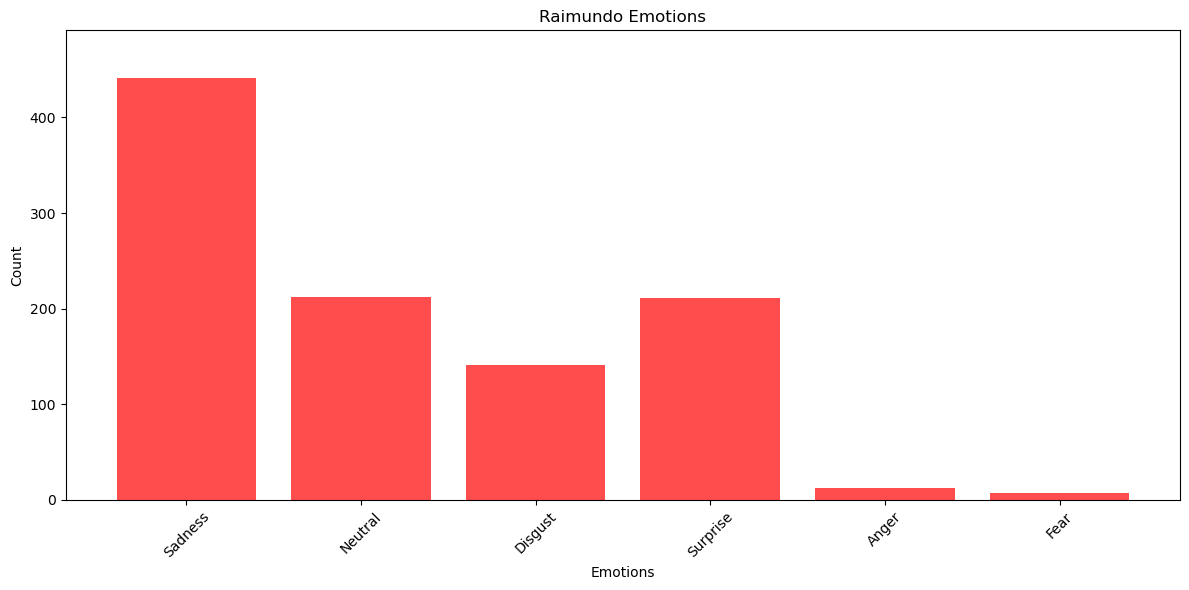

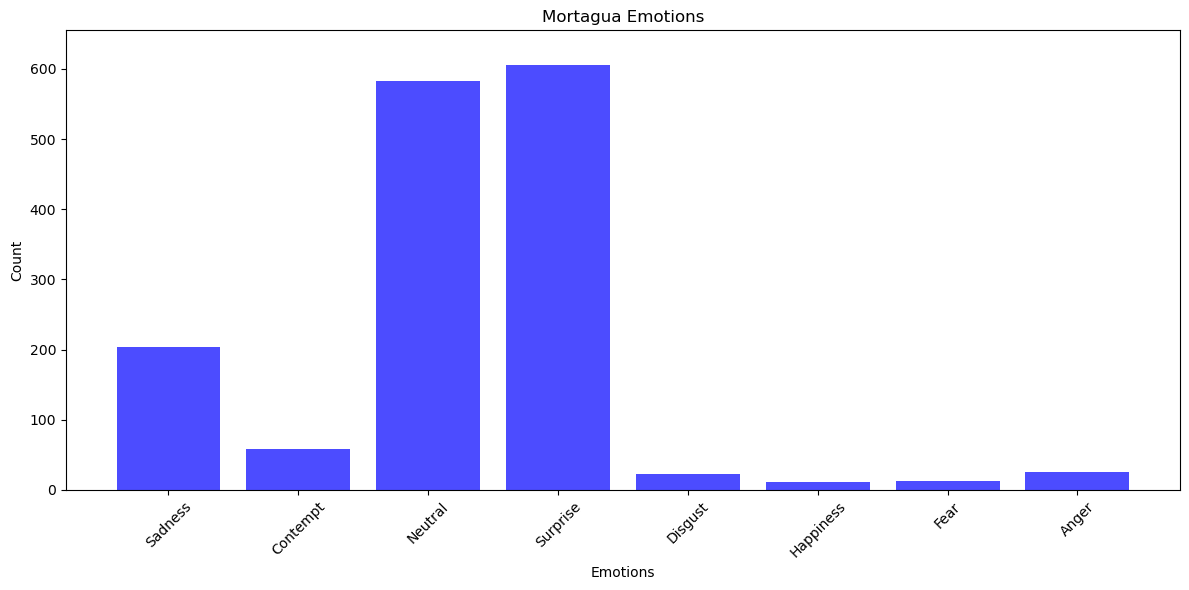

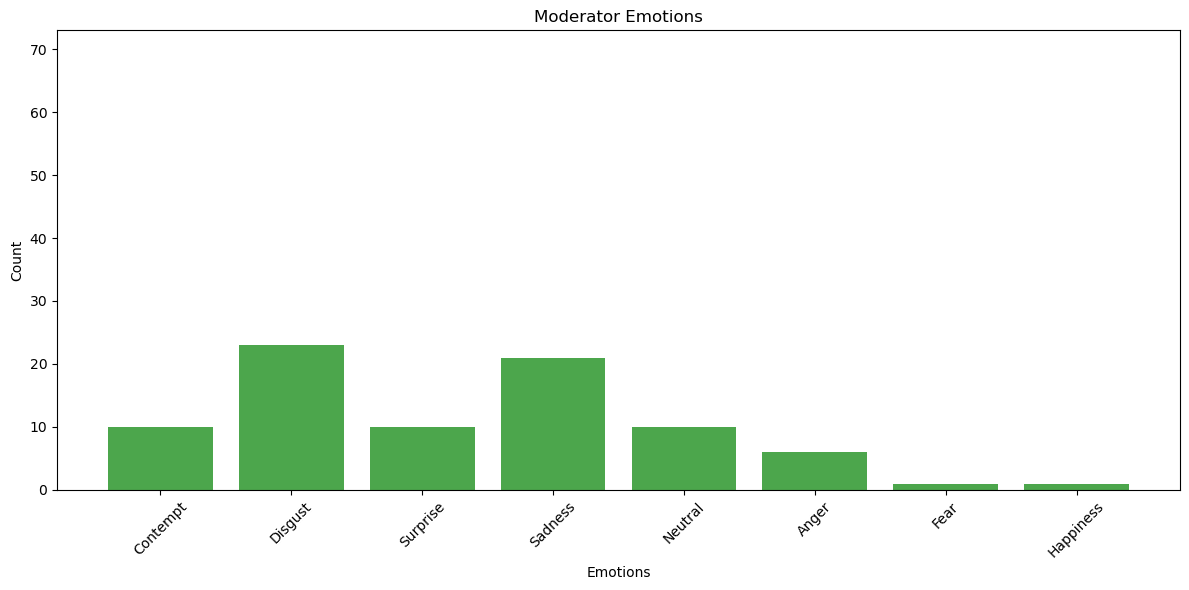

In [43]:
df_both_candidates_same_frame = copy.deepcopy(dfs[debate].iloc[C1_modified[2]])

# Get the value from the database of the index obtained from the clustering
df_only_raimundo = copy.deepcopy(dfs[debate].iloc[C1_modified[0]])
df_only_mortagua = copy.deepcopy(dfs[debate].iloc[C1_modified[1]])
df_moderator = copy.deepcopy(dfs[debate].iloc[C1_modified[3]])

df_both_candidates_same_frame = remove_translator1v1(df_both_candidates_same_frame)
df_only_raimundo = remove_translator(df_only_raimundo)
df_only_mortagua = remove_translator(df_only_mortagua)
df_moderator = remove_translator(df_moderator)

mortagua1v1, raimundo1v1 = get_location_for_each_candidate(df_both_candidates_same_frame)

mortagua_emotions = get_emotions(df_only_mortagua , mortagua1v1, 0)
raimundo_emotions = get_emotions(df_only_raimundo, raimundo1v1, 0)
moderator_emotions = get_emotions(df_moderator, df_moderator, 1)

print("Raimundo Emotions:", raimundo_emotions)
print("Mortagua Emotions:", mortagua_emotions)
print("Moderator Emotions:", moderator_emotions)

plot_emotions("Raimundo", raimundo_emotions, 'r')
plot_emotions("Mortagua", mortagua_emotions, 'b')
plot_emotions("Moderator", moderator_emotions, 'g')

emotions[debate]['Raimundo']=raimundo_emotions
emotions[debate]['Mortagua']=mortagua_emotions
emotions[debate]['Rosa Pinto']=moderator_emotions

<a id="section3.10"></a>

## 3.10 CDU-PS

In [44]:
debate = 'cdu-ps'

num_clusters = 5
embeddings_umap, cluster_labels = UMAP_with_kmeans(dfs, debate, random_seed, num_clusters)
C1 = plot_clusters(embeddings_umap, cluster_labels, num_clusters)

C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


In [45]:
C1_modified = copy.deepcopy(C1)
cluster_to_plot = 1

print(len(C1_modified[cluster_to_plot-1]))

# Remove outliers
del C1_modified[3][0:9]

# Plot specific cluster (if needed)
# plot_specific_cluster(cluster_to_plot-1, C1_modified, debate, 100)

# Define cluster names
cluster_names = {
    1: 'Raimundo vs Pedro',
    2: 'Pedro',
    3: 'Raimundo', 
    4: 'Moderator',
    5: 'Panorama',
}

# Remove the irrelevant clusters 
C1_modified = remove_clusters(C1_modified, cluster_names, ['Panorama'])

# Update cluster names
cluster_names = {
    1: 'Raimundo vs Pedro',
    2: 'Pedro',
    3: 'Raimundo', 
    4: 'Moderator',
}

463


Pedro Emotions: defaultdict(<class 'int'>, {'Anger': 116, 'Neutral': 426, 'Fear': 75, 'Surprise': 140, 'Sadness': 72, 'Disgust': 44, 'Contempt': 4})
Raimundo Emotions: defaultdict(<class 'int'>, {'Neutral': 978, 'Sadness': 453, 'Disgust': 80, 'Surprise': 535, 'Fear': 55, 'Anger': 18, 'Contempt': 8})
Moderator Emotions: defaultdict(<class 'int'>, {'Contempt': 9, 'Anger': 17, 'Disgust': 6, 'Neutral': 63, 'Surprise': 49, 'Happiness': 1, 'Sadness': 1, 'Fear': 1})


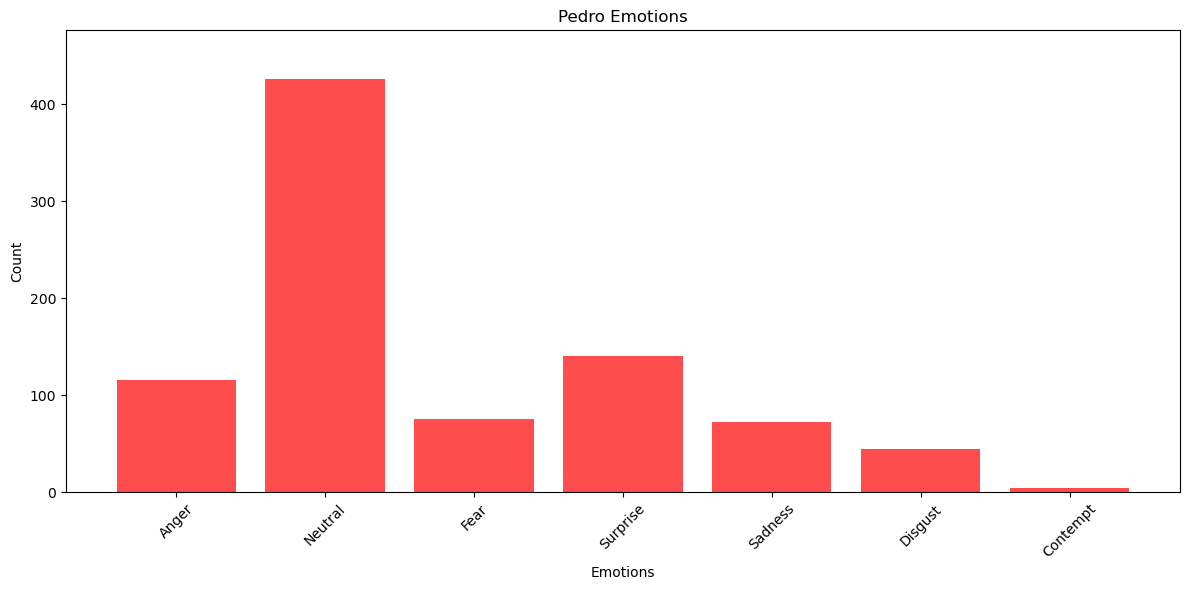

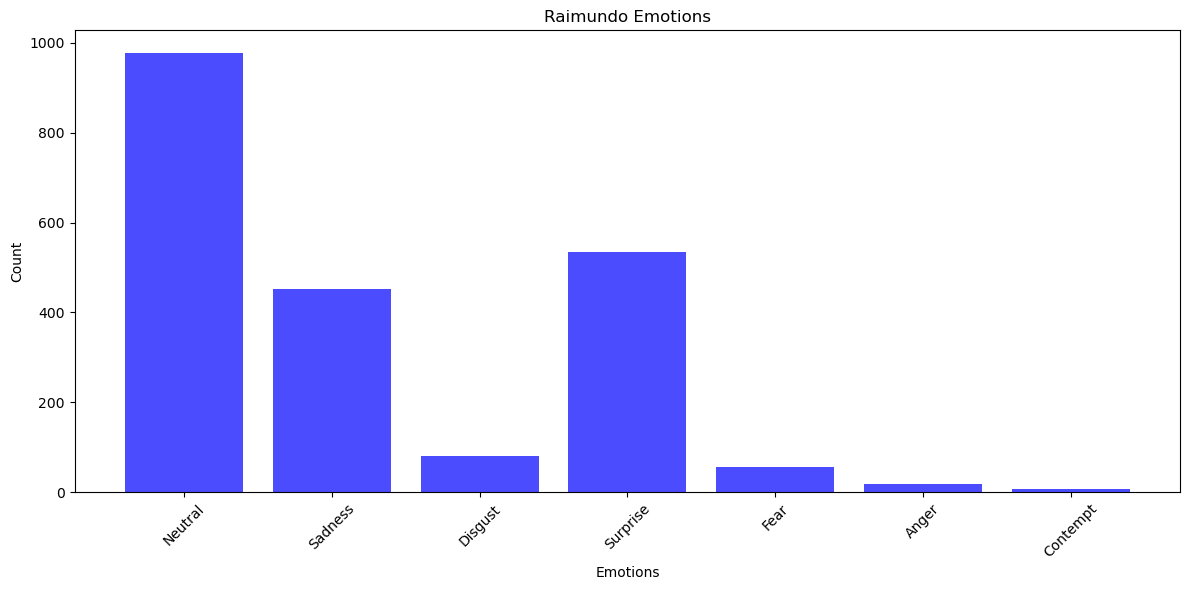

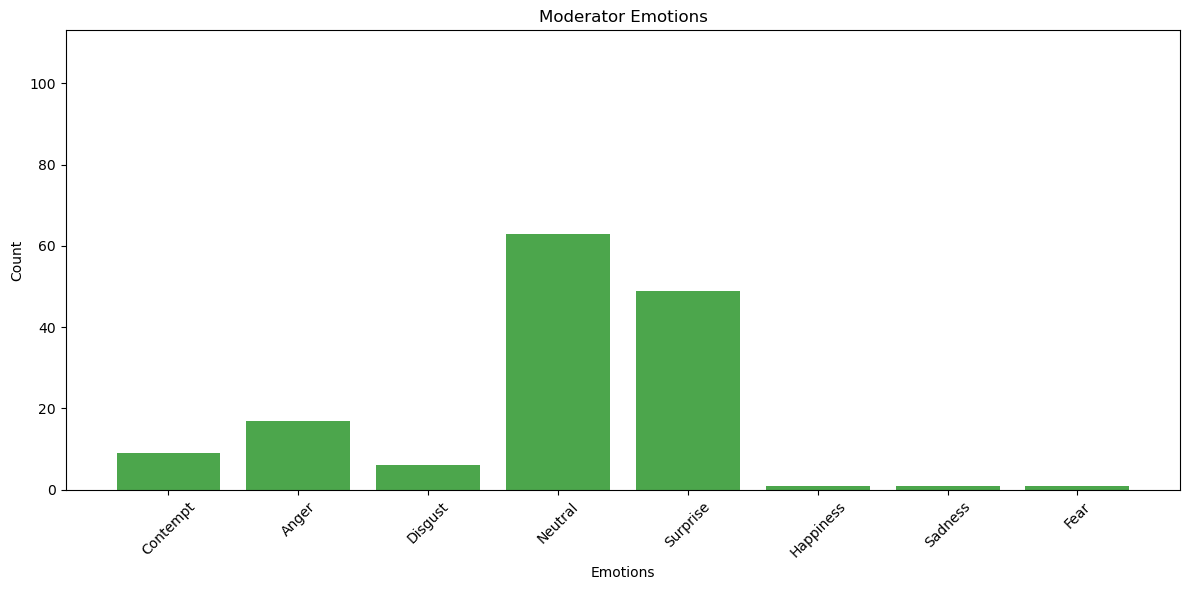

In [46]:
df_both_candidates_same_frame = copy.deepcopy(dfs[debate].iloc[C1_modified[0]])

# Get the value from the database of the index obtained from the clustering
df_only_pedro = copy.deepcopy(dfs[debate].iloc[C1_modified[1]])
df_only_raimundo = copy.deepcopy(dfs[debate].iloc[C1_modified[2]])
df_moderator = copy.deepcopy(dfs[debate].iloc[C1_modified[3]])

df_both_candidates_same_frame = remove_translator1v1(df_both_candidates_same_frame)
df_only_pedro = remove_translator(df_only_pedro)
df_only_raimundo = remove_translator(df_only_raimundo)
df_moderator = remove_translator(df_moderator)

raimundo1v1, pedro1v1 = get_location_for_each_candidate(df_both_candidates_same_frame)

raimundo_emotions = get_emotions(df_only_raimundo , raimundo1v1, 0)
pedro_emotions = get_emotions(df_only_pedro, pedro1v1, 0)
moderator_emotions = get_emotions(df_moderator, df_moderator, 1)

print("Pedro Emotions:", pedro_emotions)
print("Raimundo Emotions:", raimundo_emotions)
print("Moderator Emotions:", moderator_emotions)

plot_emotions("Pedro", pedro_emotions, 'r')
plot_emotions("Raimundo", raimundo_emotions, 'b')
plot_emotions("Moderator", moderator_emotions, 'g')

emotions[debate]['Raimundo']=raimundo_emotions
emotions[debate]['Pedro']=pedro_emotions
emotions[debate]['Clara de Sousa']=moderator_emotions

<a id="section3.11"></a>

## 3.11 CHEGA-BE

In [47]:
debate = 'chega-be'

num_clusters = 5
embeddings_umap, cluster_labels = UMAP_with_kmeans(dfs, debate, random_seed, num_clusters)
C1 = plot_clusters(embeddings_umap, cluster_labels, num_clusters)

C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


In [48]:
C1_modified = copy.deepcopy(C1)
cluster_to_plot = 5

print(len(C1_modified[cluster_to_plot-1]))

# Plot specific cluster (if needed)
# plot_specific_cluster(cluster_to_plot-1, C1_modified, debate, 100)

# Define cluster names
cluster_names = {
    1: 'Ventura',
    2: 'Mortágua vs Ventura',
    3: 'Mortágua', 
    4: 'Moderator',
    5: 'Panorama',
}

# Remove the irrelevant clusters 
C1_modified = remove_clusters(C1_modified, cluster_names, ['Panorama'])

# Update cluster names
cluster_names = {
    1: 'Ventura',
    2: 'Mortágua vs Ventura',
    3: 'Mortágua', 
    4: 'Moderator',
}

209


Ventura Emotions: defaultdict(<class 'int'>, {'Contempt': 231, 'Happiness': 29, 'Neutral': 227, 'Sadness': 238, 'Surprise': 561, 'Fear': 15, 'Disgust': 24, 'Anger': 7})
Mortagua Emotions: defaultdict(<class 'int'>, {'Contempt': 299, 'Happiness': 19, 'Surprise': 708, 'Neutral': 233, 'Sadness': 108, 'Fear': 12, 'Disgust': 24, 'Anger': 15})
Moderator Emotions: defaultdict(<class 'int'>, {'Contempt': 35, 'Surprise': 59, 'Disgust': 15, 'Neutral': 25, 'Sadness': 4, 'Anger': 2, 'Happiness': 6})


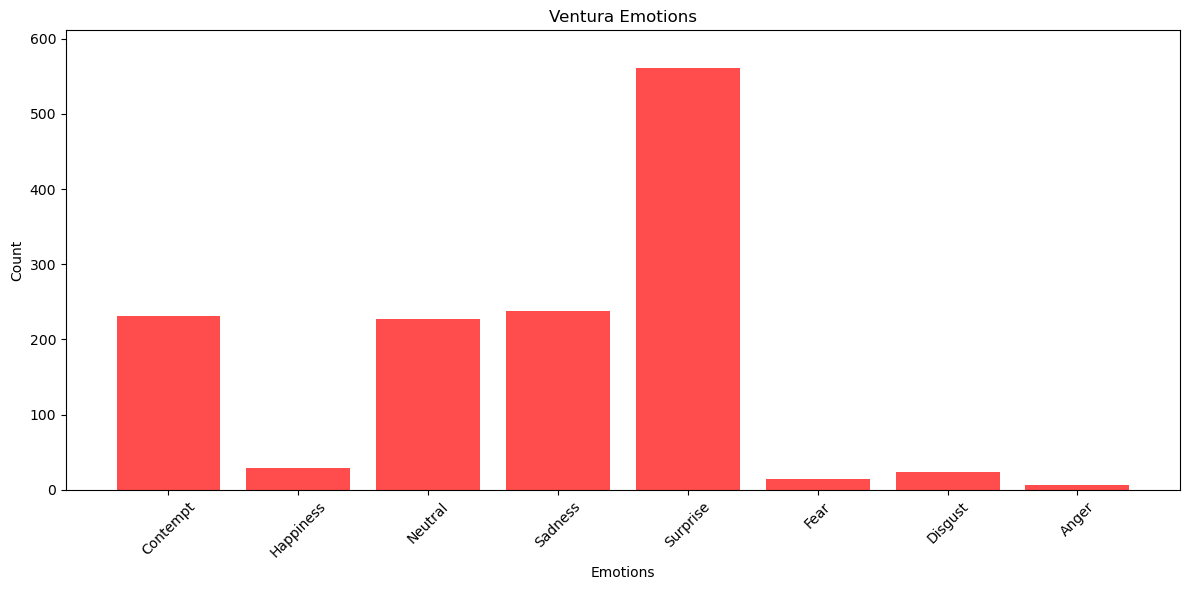

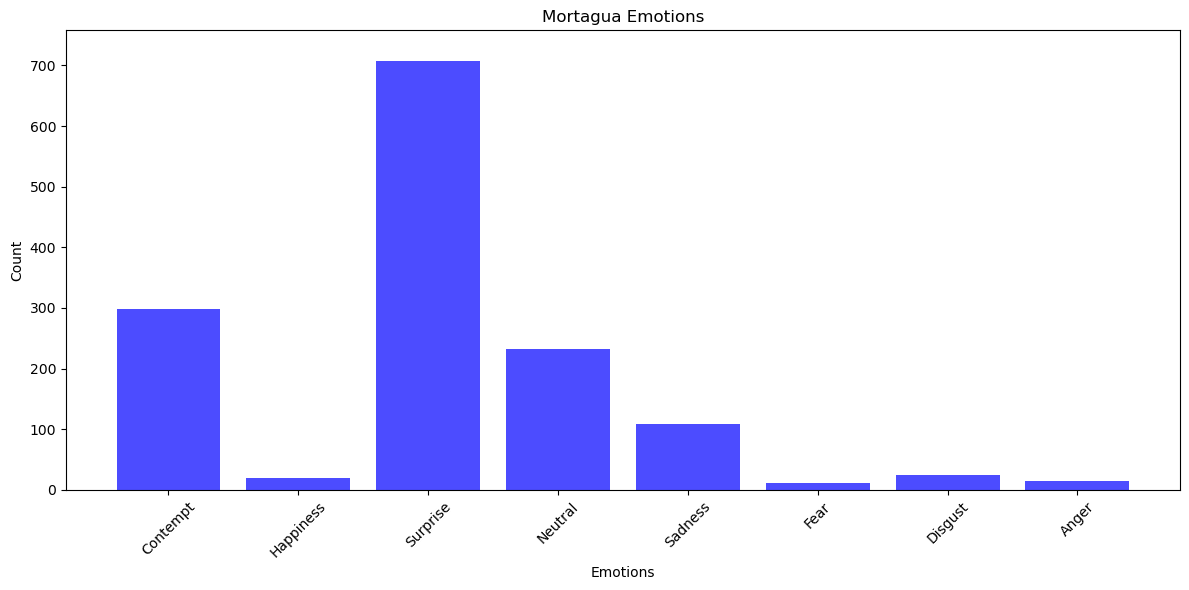

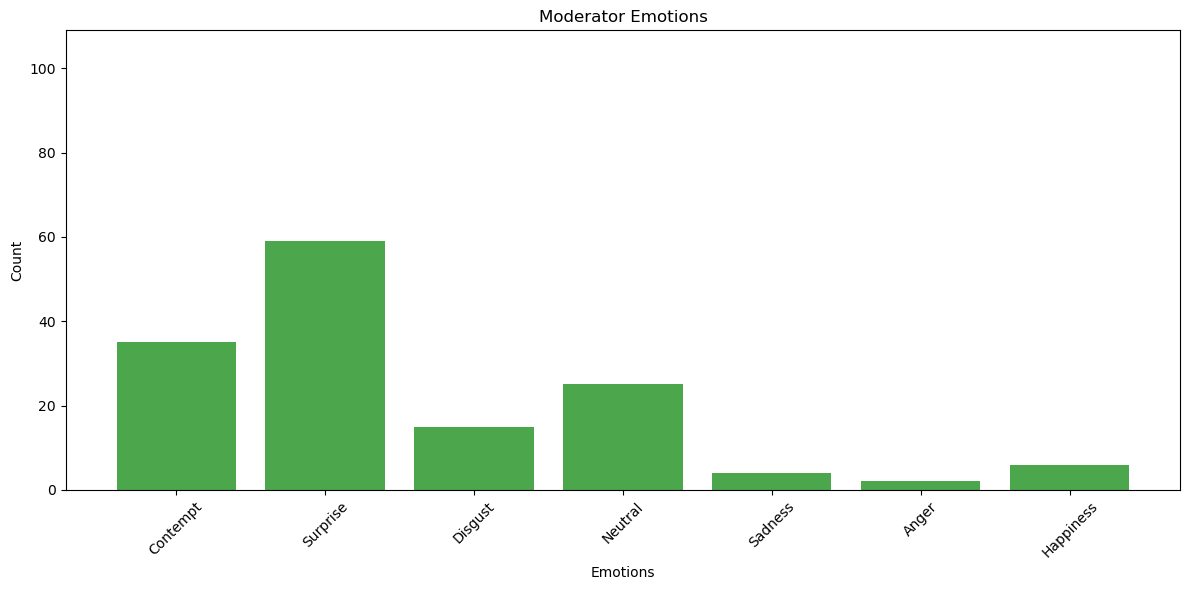

In [49]:
df_both_candidates_same_frame = copy.deepcopy(dfs[debate].iloc[C1_modified[1]])

# Get the value from the database of the index obtained from the clustering
df_only_ventura = copy.deepcopy(dfs[debate].iloc[C1_modified[0]])
df_only_mortagua = copy.deepcopy(dfs[debate].iloc[C1_modified[2]])
df_moderator = copy.deepcopy(dfs[debate].iloc[C1_modified[3]])

df_both_candidates_same_frame = remove_translator1v1(df_both_candidates_same_frame)
df_only_ventura = remove_translator(df_only_ventura)
df_only_mortagua = remove_translator(df_only_mortagua)
df_moderator = remove_translator(df_moderator)

mortagua1v1, ventura1v1 = get_location_for_each_candidate(df_both_candidates_same_frame)

mortagua_emotions = get_emotions(df_only_mortagua , mortagua1v1, 0)
ventura_emotions = get_emotions(df_only_ventura, ventura1v1, 0)
moderator_emotions = get_emotions(df_moderator, df_moderator, 1)

print("Ventura Emotions:", ventura_emotions)
print("Mortagua Emotions:", mortagua_emotions)
print("Moderator Emotions:", moderator_emotions)

plot_emotions("Ventura", ventura_emotions, 'r')
plot_emotions("Mortagua", mortagua_emotions, 'b')
plot_emotions("Moderator", moderator_emotions, 'g')

emotions[debate]['Ventura']=ventura_emotions
emotions[debate]['Mortagua']=mortagua_emotions
emotions[debate]['Joao Adelino Faria']=moderator_emotions

<a id="section3.12"></a>

## 3.12 CHEGA-CDU

In [50]:
debate = 'chega-cdu'

num_clusters = 5
embeddings_umap, cluster_labels = UMAP_with_kmeans(dfs, debate, random_seed, num_clusters)
C1 = plot_clusters(embeddings_umap, cluster_labels, num_clusters)

C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


In [51]:
C1_modified = copy.deepcopy(C1)
cluster_to_plot = 5

print(len(C1_modified[cluster_to_plot-1]))

# Plot specific cluster (if needed)
# plot_specific_cluster(cluster_to_plot-1, C1_modified, debate, 100)

# Define cluster names
cluster_names = {
    1: 'Raimundo vs Ventura',
    2: 'Ventura',
    3: 'Panorama', 
    4: 'Raimundo',
    5: 'Moderator',
}

# Remove the irrelevant clusters 
C1_modified = remove_clusters(C1_modified, cluster_names, ['Panorama'])

# Update cluster names
cluster_names = {
    1: 'Raimundo vs Ventura',
    2: 'Ventura',
    3: 'Raimundo',
    4: 'Moderator',
}

224


Ventura Emotions: defaultdict(<class 'int'>, {'Neutral': 174, 'Sadness': 268, 'Surprise': 621, 'Disgust': 15, 'Contempt': 28, 'Fear': 6, 'Anger': 19, 'Happiness': 7})
Raimundo Emotions: defaultdict(<class 'int'>, {'Surprise': 276, 'Neutral': 462, 'Sadness': 169, 'Anger': 78, 'Disgust': 24, 'Contempt': 1, 'Fear': 9})
Moderator Emotions: defaultdict(<class 'int'>, {'Sadness': 68, 'Surprise': 83, 'Disgust': 16, 'Neutral': 41, 'Anger': 19, 'Fear': 19})


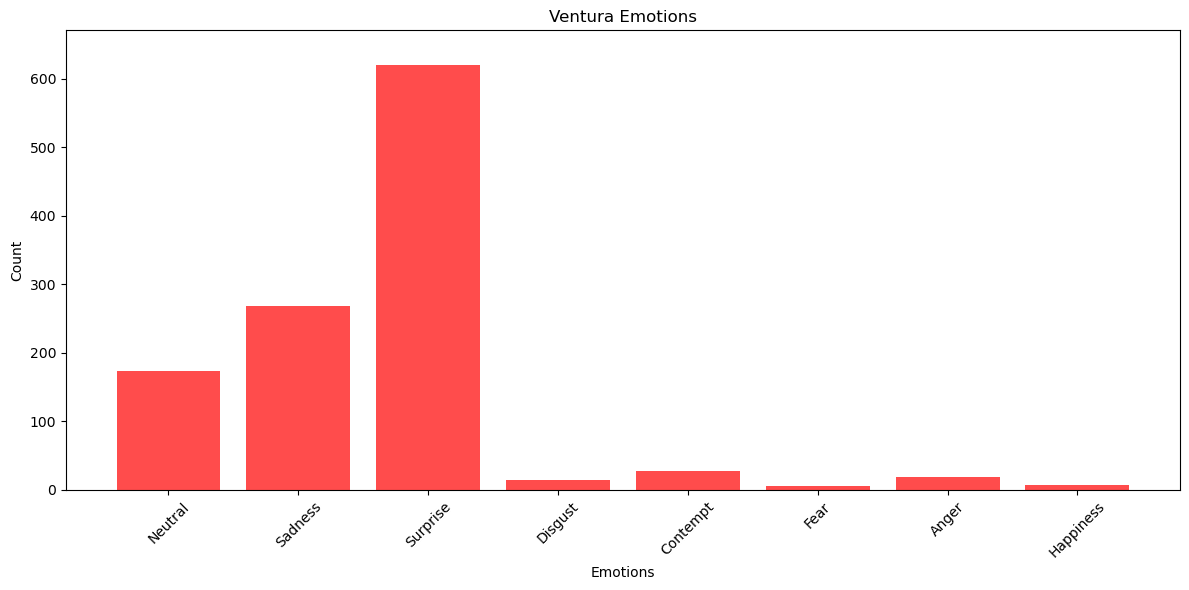

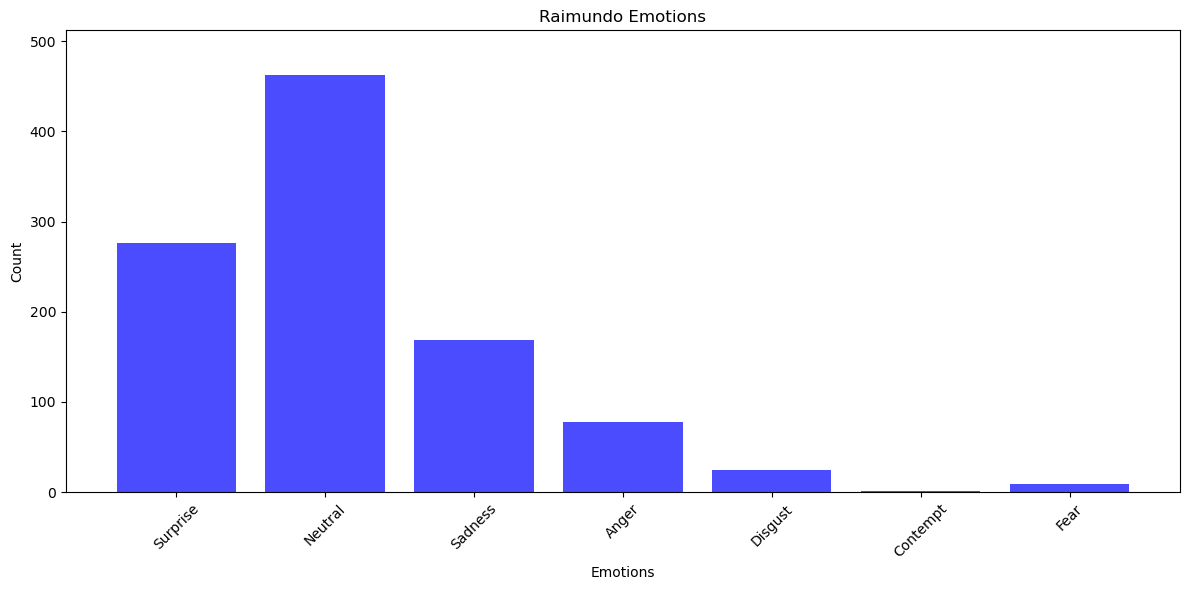

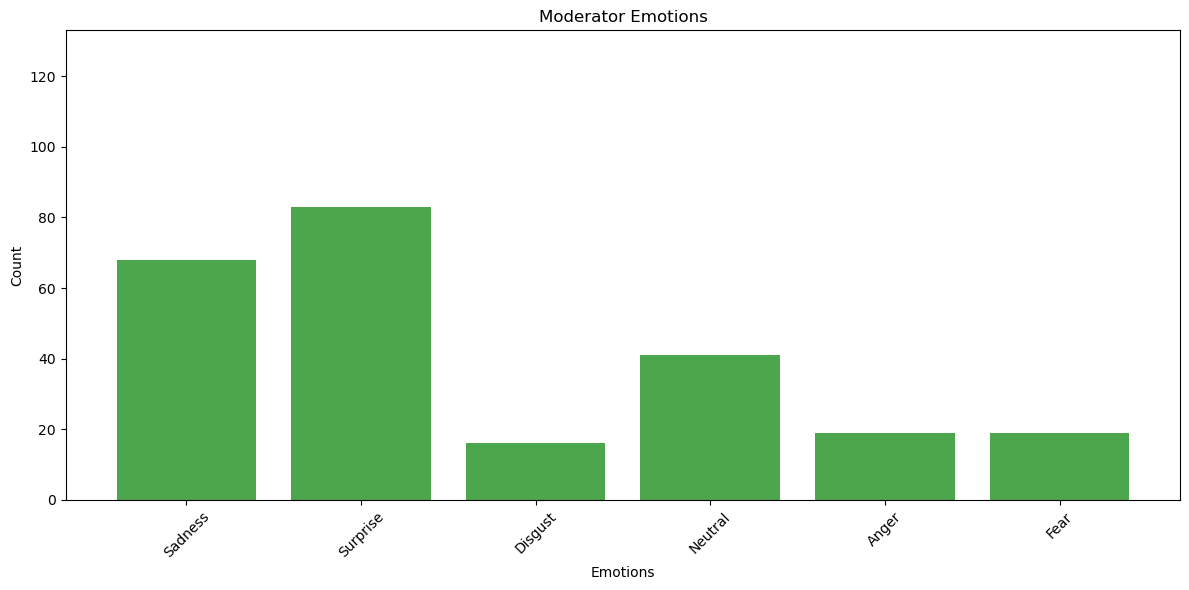

In [52]:
df_both_candidates_same_frame = copy.deepcopy(dfs[debate].iloc[C1_modified[0]])

# Get the value from the database of the index obtained from the clustering
df_only_ventura = copy.deepcopy(dfs[debate].iloc[C1_modified[1]])
df_only_raimundo = copy.deepcopy(dfs[debate].iloc[C1_modified[2]])
df_moderator = copy.deepcopy(dfs[debate].iloc[C1_modified[3]])

raimundo1v1, ventura1v1 = get_location_for_each_candidate(df_both_candidates_same_frame)

raimundo_emotions = get_emotions(df_only_raimundo , raimundo1v1, 0)
ventura_emotions = get_emotions(df_only_ventura, ventura1v1, 0)
moderator_emotions = get_emotions(df_moderator, df_moderator, 1)

print("Ventura Emotions:", ventura_emotions)
print("Raimundo Emotions:", raimundo_emotions)
print("Moderator Emotions:", moderator_emotions)

plot_emotions("Ventura", ventura_emotions, 'r')
plot_emotions("Raimundo", raimundo_emotions, 'b')
plot_emotions("Moderator", moderator_emotions, 'g')

emotions[debate]['Ventura']=ventura_emotions
emotions[debate]['Raimundo']=raimundo_emotions
emotions[debate]['Joao Marinheiro']=moderator_emotions

<a id="section3.13"></a>

## 3.13 CHEGA-IL 

In [53]:
debate = 'chega-il'

num_clusters = 7
embeddings_umap, cluster_labels = UMAP_with_kmeans(dfs, debate, random_seed, num_clusters)
C1 = plot_clusters(embeddings_umap, cluster_labels, num_clusters)

C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


In [54]:
C1_modified = copy.deepcopy(C1)
cluster_to_plot = 7

# Plot specific cluster (if needed)
# plot_specific_cluster(cluster_to_plot-1, C1_modified, debate, 100)

# Force merging clusters
merged_sorted_values = sorted(C1_modified[3] + C1_modified[4] + C1_modified[5])
C1_modified[3] = merged_sorted_values

# Define cluster names
cluster_names = {
    1: 'Ventura vs Rocha',
    2: 'Rocha',
    3: 'Panorama', 
    4: 'Ventura',
    7: 'Moderator'
}

# Remove the irrelevant clusters 
C1_modified = remove_clusters(C1_modified, cluster_names, ['Panorama'])

# Update cluster names
cluster_names = {
    1: 'Ventura vs Rocha',
    2: 'Rocha',
    3: 'Ventura',
    7: 'Moderator'
}


Rocha Emotions: defaultdict(<class 'int'>, {'Neutral': 287, 'Surprise': 202, 'Sadness': 72, 'Contempt': 80, 'Anger': 5, 'Disgust': 51, 'Happiness': 6, 'Fear': 1})
Ventura Emotions: defaultdict(<class 'int'>, {'Sadness': 537, 'Contempt': 96, 'Happiness': 48, 'Neutral': 555, 'Surprise': 358, 'Fear': 52, 'Disgust': 123, 'Anger': 8})
Moderator Emotions: defaultdict(<class 'int'>, {'Neutral': 77, 'Sadness': 77, 'Contempt': 3, 'Fear': 1, 'Surprise': 19})


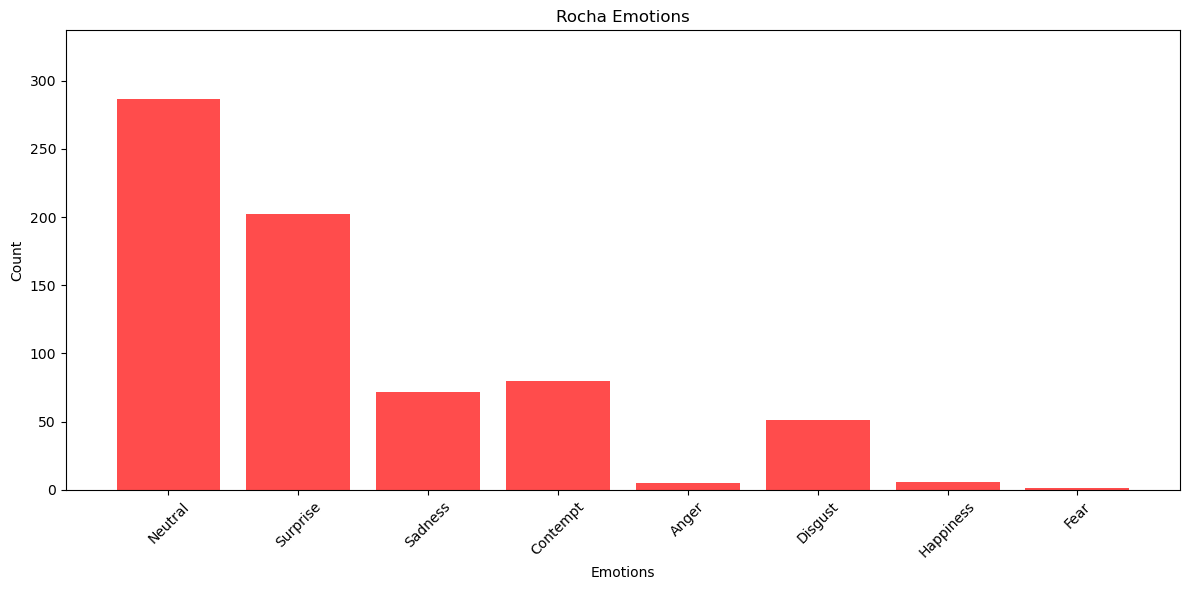

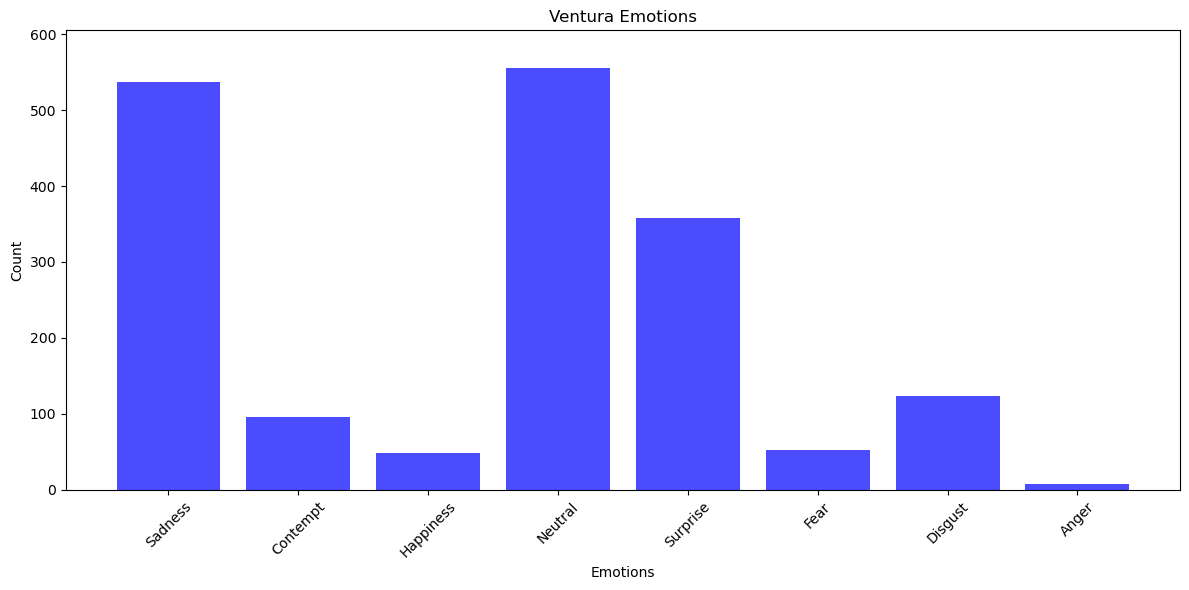

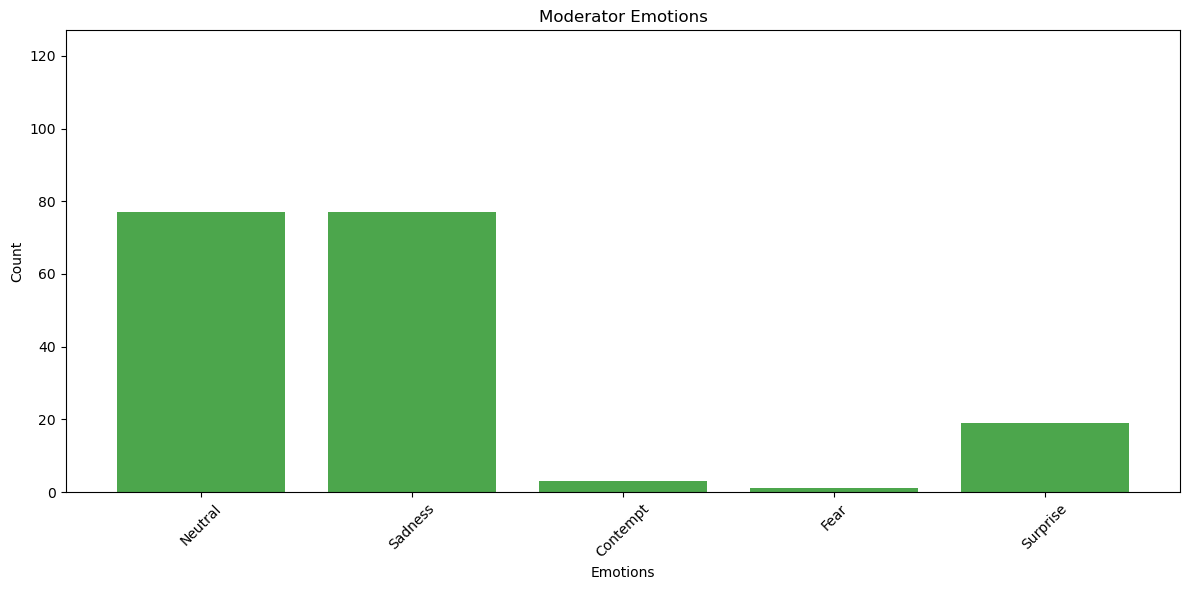

In [55]:
df_both_candidates_same_frame = copy.deepcopy(dfs[debate].iloc[C1_modified[0]])

# Get the value from the database of the index obtained from the clustering
df_only_rocha = copy.deepcopy(dfs[debate].iloc[C1_modified[1]])
df_only_ventura = copy.deepcopy(dfs[debate].iloc[C1_modified[2]])
df_moderator = copy.deepcopy(dfs[debate].iloc[C1_modified[5]])

df_only_rocha = remove_translators(df_only_rocha)
df_only_ventura = remove_translators(df_only_ventura)
df_moderator = remove_translators(df_moderator)

ventura1v1, rocha1v1 = get_location_for_each_candidate(df_both_candidates_same_frame)

ventura_emotions = get_emotions(df_only_ventura , ventura1v1, 0)
rocha_emotions = get_emotions(df_only_rocha, rocha1v1, 0)
moderator_emotions = get_emotions(df_moderator, df_moderator, 1)

print("Rocha Emotions:", rocha_emotions)
print("Ventura Emotions:", ventura_emotions)
print("Moderator Emotions:", moderator_emotions)

plot_emotions("Rocha", rocha_emotions, 'r')
plot_emotions("Ventura", ventura_emotions, 'b')
plot_emotions("Moderator", moderator_emotions, 'g')

emotions[debate]['Rocha']=rocha_emotions
emotions[debate]['Ventura']=ventura_emotions
emotions[debate]['Rosa Pinto']=moderator_emotions

<a id="section3.14"></a>

## 3.14 CHEGA-PS

In [56]:
debate = 'chega-ps'

num_clusters = 5
embeddings_umap, cluster_labels = UMAP_with_kmeans(dfs, debate, random_seed, num_clusters)
C1 = plot_clusters(embeddings_umap, cluster_labels, num_clusters)

C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


In [57]:
C1_modified = copy.deepcopy(C1)
cluster_to_plot = 5

print(len(C1_modified[cluster_to_plot-1]))

# Remove outliers
del C1_modified[4][0:7]

# Plot specific cluster (if needed)
# plot_specific_cluster(cluster_to_plot-1, C1_modified, debate, 100)

# Define cluster names
cluster_names = {
    1: 'Pedro vs Ventura',
    2: 'Ventura',
    3: 'Panorama', 
    4: 'Pedro',
    5: 'Moderator',
}

# Remove the clusters that correspond to the panorama and txhe moderator
C1_modified = remove_clusters(C1_modified, cluster_names, ['Panorama'])

# Update cluster names
cluster_names = {
    1: 'Pedro vs Ventura',
    2: 'Ventura',
    3: 'Pedro',
    4: 'Moderator',
}

119


Ventura Emotions: defaultdict(<class 'int'>, {'Contempt': 144, 'Neutral': 580, 'Sadness': 283, 'Surprise': 663, 'Disgust': 19, 'Happiness': 38, 'Anger': 6, 'Fear': 7})
Pedro Emotions: defaultdict(<class 'int'>, {'Neutral': 962, 'Sadness': 317, 'Surprise': 194, 'Disgust': 31, 'Anger': 24, 'Fear': 6, 'Contempt': 12, 'Happiness': 2})
Moderator Emotions: defaultdict(<class 'int'>, {'Disgust': 26, 'Neutral': 17, 'Surprise': 39, 'Sadness': 21, 'Anger': 1, 'Contempt': 1})


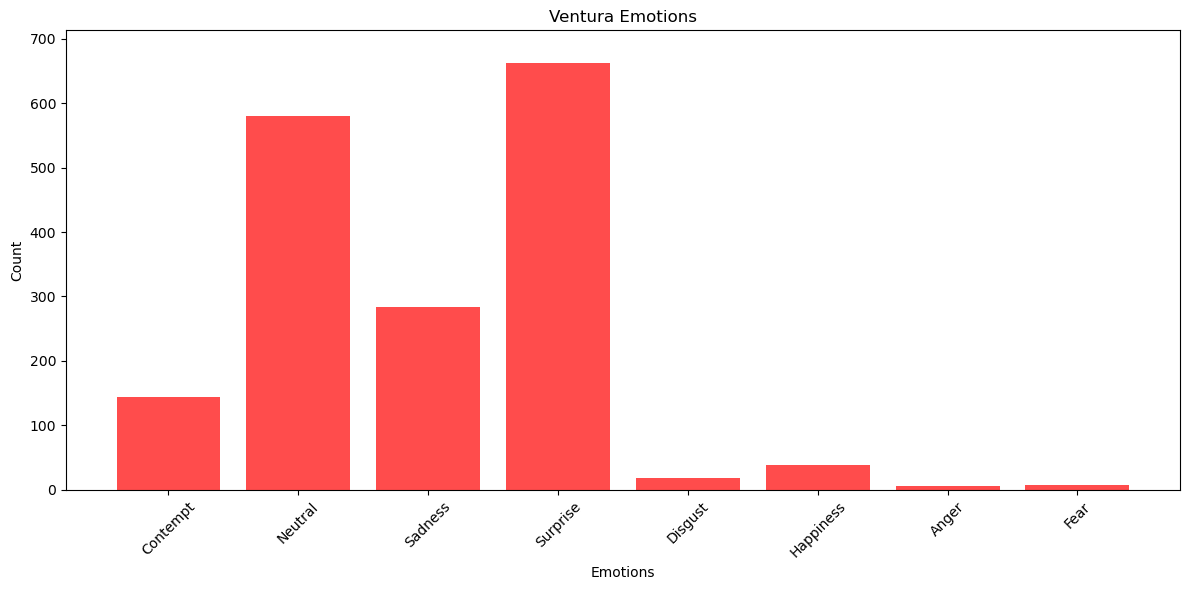

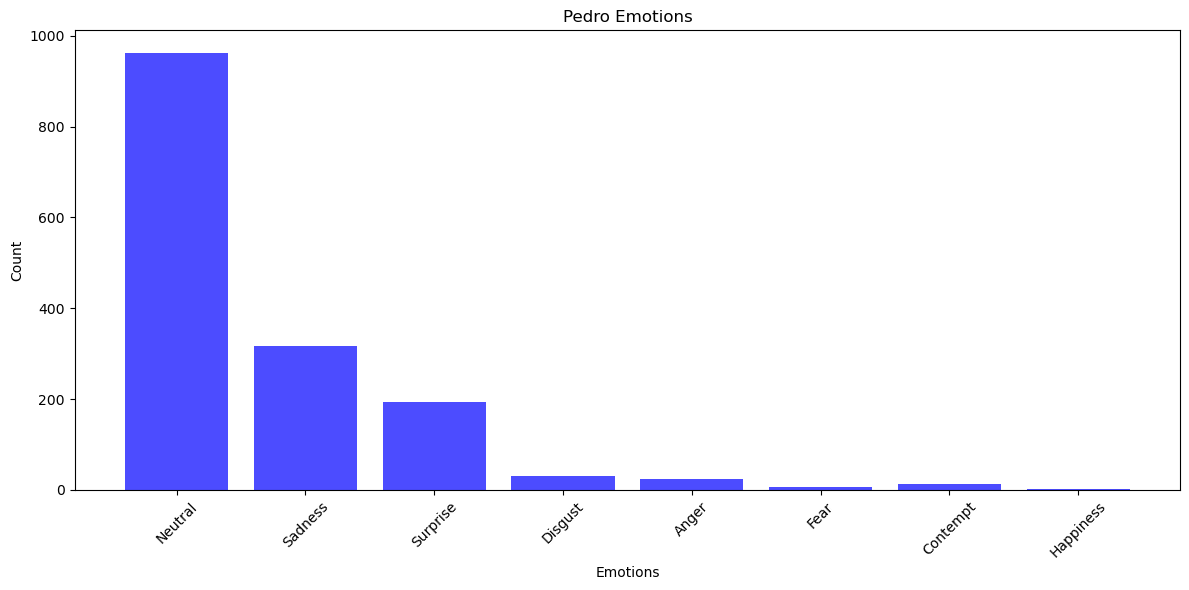

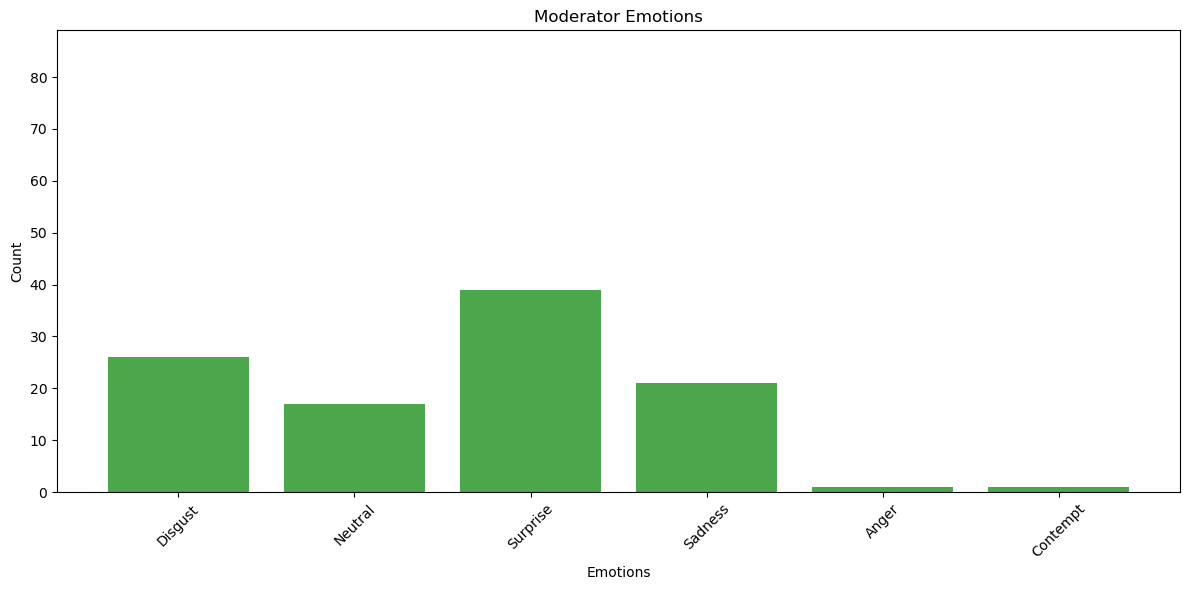

In [58]:
df_both_candidates_same_frame = copy.deepcopy(dfs[debate].iloc[C1_modified[0]])

# Get the value from the database of the index obtained from the clustering
df_only_ventura = copy.deepcopy(dfs[debate].iloc[C1_modified[1]])
df_only_pedro = copy.deepcopy(dfs[debate].iloc[C1_modified[2]])
df_moderator = copy.deepcopy(dfs[debate].iloc[C1_modified[3]])

df_both_candidates_same_frame = remove_translator1v1(df_both_candidates_same_frame)
df_only_ventura = remove_translator(df_only_ventura)
df_only_pedro = remove_translator(df_only_pedro)
df_moderator = remove_translator(df_moderator)

pedro1v1, ventura1v1 = get_location_for_each_candidate(df_both_candidates_same_frame)

pedro_emotions = get_emotions(df_only_pedro , pedro1v1, 0)
ventura_emotions = get_emotions(df_only_ventura, ventura1v1, 0)
moderator_emotions = get_emotions(df_moderator, df_moderator, 1)

print("Ventura Emotions:", ventura_emotions)
print("Pedro Emotions:", pedro_emotions)
print("Moderator Emotions:", moderator_emotions)

plot_emotions("Ventura", ventura_emotions, 'r')
plot_emotions("Pedro", pedro_emotions, 'b')
plot_emotions("Moderator", moderator_emotions, 'g')

emotions[debate]['Pedro']=pedro_emotions
emotions[debate]['Ventura']=ventura_emotions
emotions[debate]['Sara Pinto']=moderator_emotions

<a id="section3.15"></a>

## 3.15 IL-BE

In [59]:
debate = 'il-be'

num_clusters = 5
embeddings_umap, cluster_labels = UMAP_with_kmeans(dfs, debate, random_seed, num_clusters)
C1 = plot_clusters(embeddings_umap, cluster_labels, num_clusters)

C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


In [60]:
C1_modified = copy.deepcopy(C1)
cluster_to_plot = 5

print(len(C1_modified[cluster_to_plot-1]))

# Remove outliers
del C1_modified[3][0:2]

# Plot specific cluster (if needed)
# plot_specific_cluster(cluster_to_plot-1, C1_modified, debate, 100)

# Define cluster names
cluster_names = {
    1: 'Panorama',
    2: 'Mortágua vs Rocha',
    3: 'Rocha', 
    4: 'Mortágua',
    5: 'Moderator',
}

# Remove the clusters that correspond to the panorama and txhe moderator
C1_modified = remove_clusters(C1_modified, cluster_names, ['Panorama'])

# Update cluster names
cluster_names = {
    1: 'Mortágua vs Rocha',
    2: 'Rocha', 
    3: 'Mortágua',
    4: 'Moderator',
}

117


Rocha Emotions: defaultdict(<class 'int'>, {'Neutral': 268, 'Surprise': 193, 'Sadness': 68, 'Fear': 14, 'Disgust': 23, 'Contempt': 15, 'Anger': 2, 'Happiness': 2})
Mortagua Emotions: defaultdict(<class 'int'>, {'Sadness': 47, 'Surprise': 240, 'Neutral': 73, 'Happiness': 2, 'Anger': 30, 'Contempt': 30, 'Disgust': 10, 'Fear': 1})
Moderator Emotions: defaultdict(<class 'int'>, {'Surprise': 39, 'Disgust': 35, 'Neutral': 99, 'Fear': 42, 'Sadness': 79, 'Anger': 5})


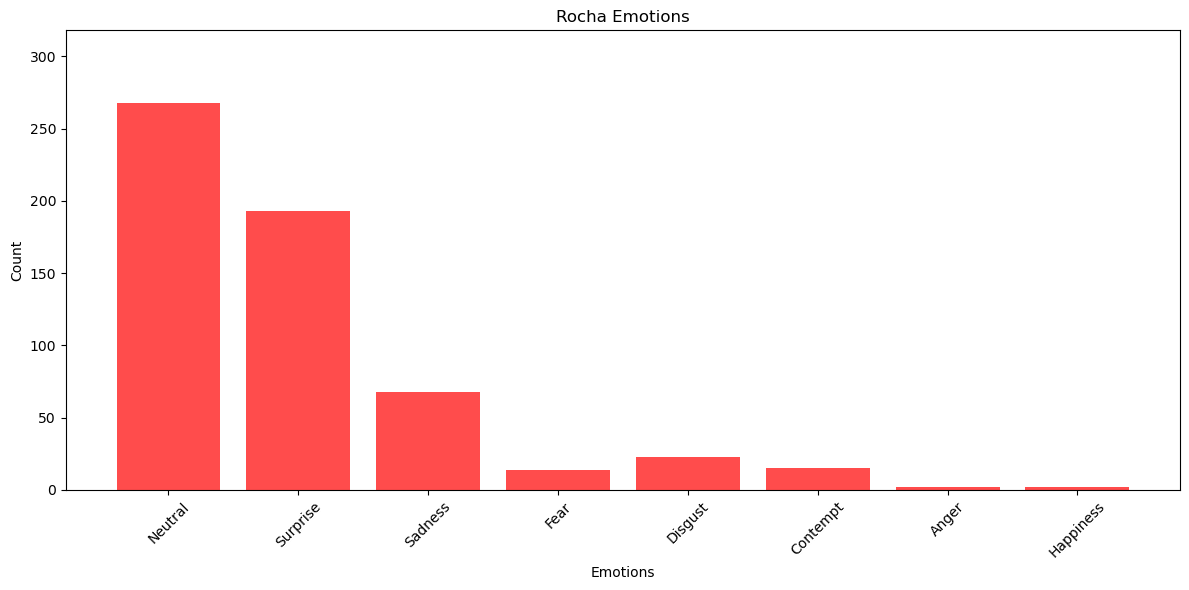

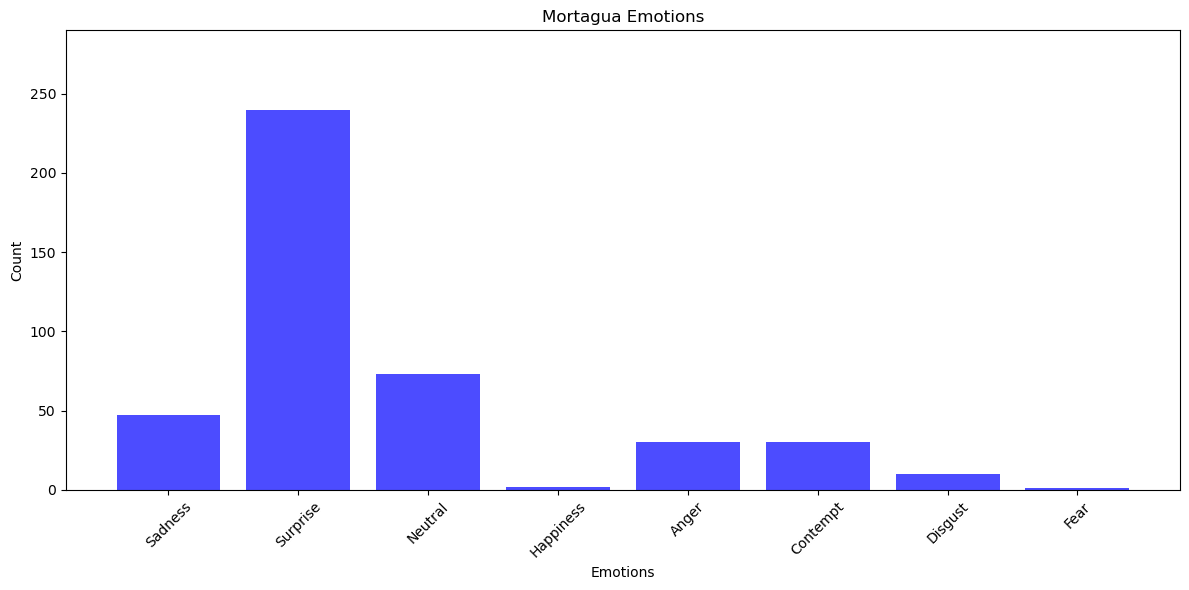

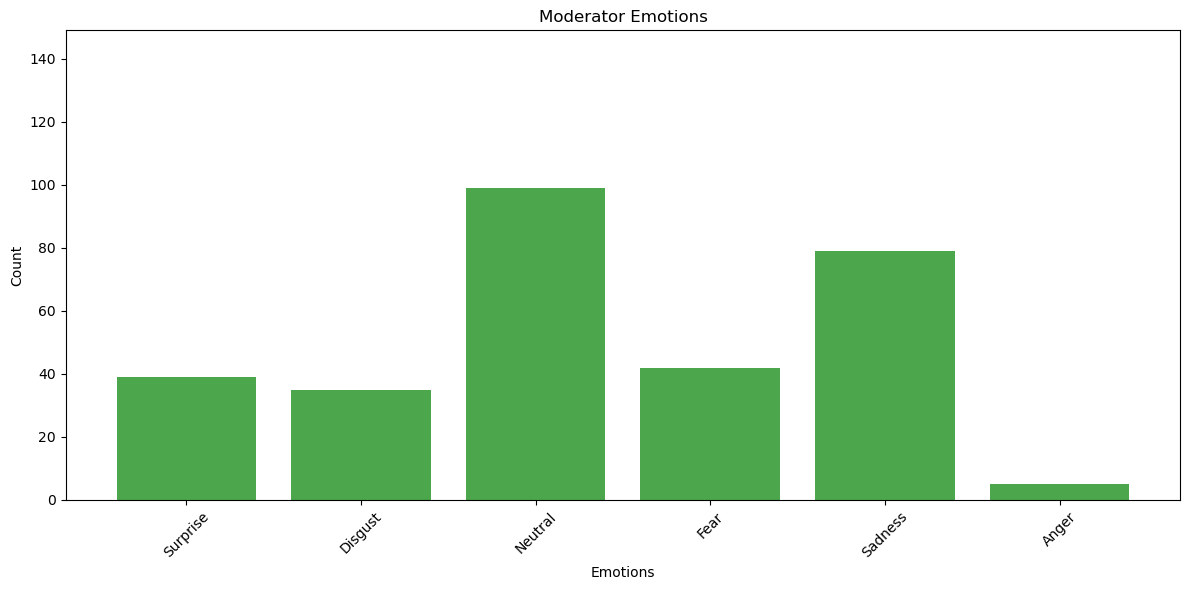

In [61]:
df_both_candidates_same_frame = copy.deepcopy(dfs[debate].iloc[C1_modified[0]])

# Get the value from the database of the index obtained from the clustering
df_only_rocha = copy.deepcopy(dfs[debate].iloc[C1_modified[1]])
df_only_mortagua = copy.deepcopy(dfs[debate].iloc[C1_modified[2]])
df_moderator = copy.deepcopy(dfs[debate].iloc[C1_modified[3]])

df_both_candidates_same_frame = remove_translator1v1(df_both_candidates_same_frame)
df_only_rocha = remove_translator(df_only_rocha)
df_only_mortagua = remove_translator(df_only_mortagua)
df_moderator = remove_translator(df_moderator)

mortagua1v1, rocha1v1 = get_location_for_each_candidate(df_both_candidates_same_frame)

mortagua_emotions = get_emotions(df_only_mortagua , mortagua1v1, 0)
rocha_emotions = get_emotions(df_only_rocha, rocha1v1, 0)
moderator_emotions = get_emotions(df_moderator, df_moderator, 1)

print("Rocha Emotions:", rocha_emotions)
print("Mortagua Emotions:", mortagua_emotions)
print("Moderator Emotions:", moderator_emotions)

plot_emotions("Rocha", rocha_emotions, 'r')
plot_emotions("Mortagua", mortagua_emotions, 'b')
plot_emotions("Moderator", moderator_emotions, 'g')

emotions[debate]['Rocha']=rocha_emotions
emotions[debate]['Mortagua']=mortagua_emotions
emotions[debate]['Joao Marinheiro']=moderator_emotions

<a id="section3.16"></a>

## 3.16 IL-CDU

In [62]:
debate = 'il-cdu'

num_clusters = 5
embeddings_umap, cluster_labels = UMAP_with_kmeans(dfs, debate, random_seed, num_clusters)
C1 = plot_clusters(embeddings_umap, cluster_labels, num_clusters)

C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


In [63]:
C1_modified = copy.deepcopy(C1)
cluster_to_plot = 5

print(len(C1_modified[cluster_to_plot-1]))

# Plot specific cluster (if needed)
# plot_specific_cluster(cluster_to_plot-1, C1_modified, debate, 100)

# Define cluster names
cluster_names = {
    1: 'Raimundo vs Rocha',
    2: 'Raimundo',
    3: 'Rocha', 
    4: 'Panorama',
    5: 'Moderator',
}

# Remove the clusters that correspond to the panorama and txhe moderator
C1_modified = remove_clusters(C1_modified, cluster_names, ['Panorama'])

# Update cluster names
cluster_names = {
    1: 'Raimundo vs Rocha',
    2: 'Raimundo',
    3: 'Rocha', 
    4: 'Moderator',
}

171


Rocha Emotions: defaultdict(<class 'int'>, {'Contempt': 165, 'Happiness': 2, 'Sadness': 147, 'Neutral': 393, 'Surprise': 266, 'Anger': 75, 'Disgust': 70, 'Fear': 4})
Raimundo Emotions: defaultdict(<class 'int'>, {'Neutral': 683, 'Disgust': 66, 'Sadness': 122, 'Surprise': 222, 'Anger': 46, 'Fear': 6, 'Contempt': 53, 'Happiness': 5})
Moderator Emotions: defaultdict(<class 'int'>, {'Contempt': 49, 'Disgust': 12, 'Surprise': 53, 'Anger': 8, 'Neutral': 33, 'Happiness': 16, 'Sadness': 1})


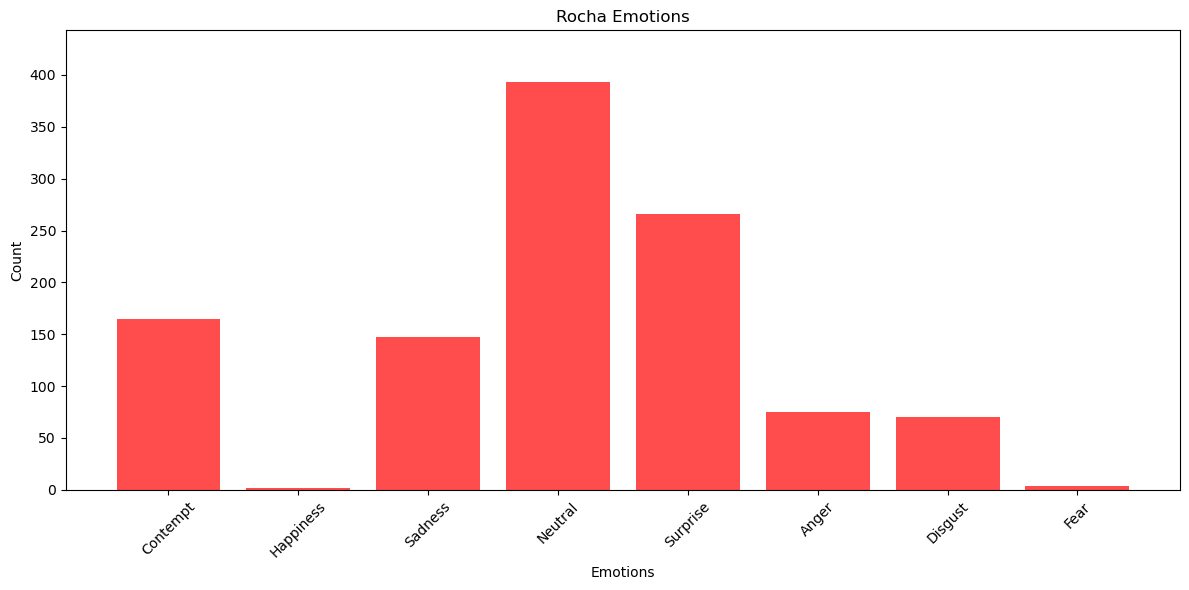

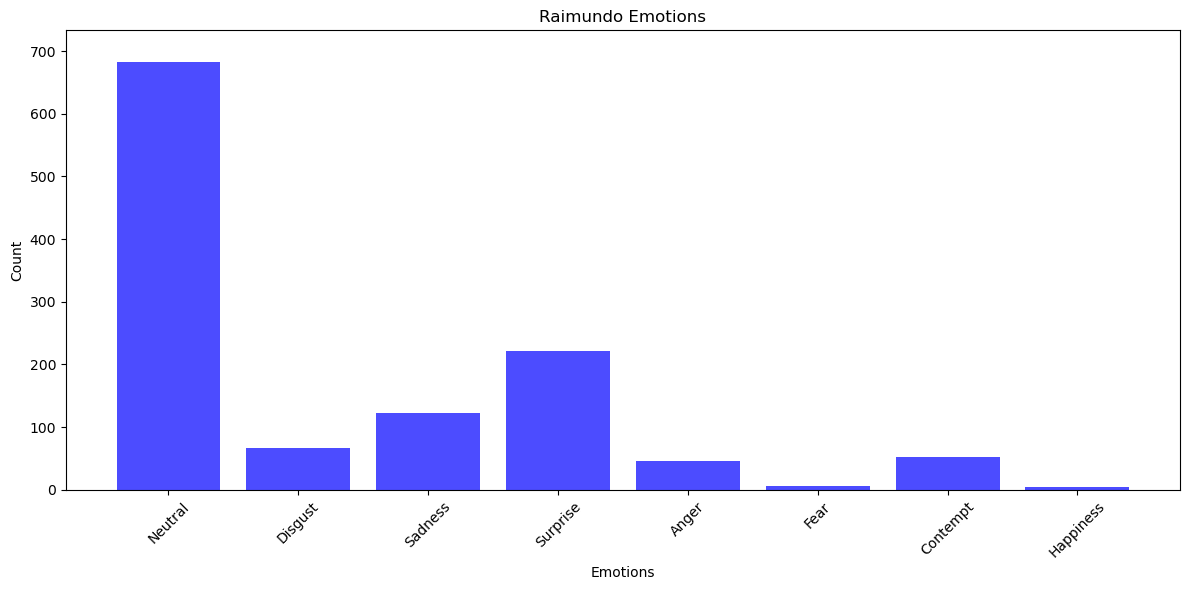

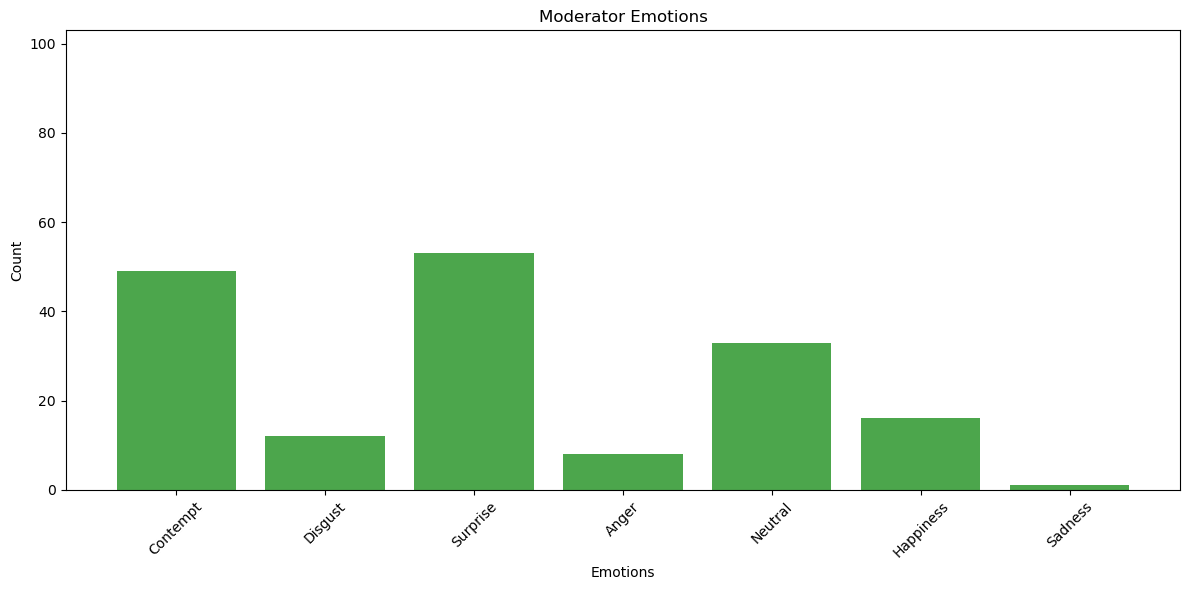

In [64]:
df_both_candidates_same_frame = copy.deepcopy(dfs[debate].iloc[C1_modified[0]])

# Get the value from the database of the index obtained from the clustering
df_only_rocha = copy.deepcopy(dfs[debate].iloc[C1_modified[2]])
df_only_raimundo = copy.deepcopy(dfs[debate].iloc[C1_modified[1]])
df_moderator = copy.deepcopy(dfs[debate].iloc[C1_modified[3]])

df_both_candidates_same_frame = remove_translator1v1(df_both_candidates_same_frame)
df_only_rocha = remove_translator(df_only_rocha)
df_only_raimundo = remove_translator(df_only_raimundo)
df_moderator = remove_translator(df_moderator)

raimundo1v1, rocha1v1 = get_location_for_each_candidate(df_both_candidates_same_frame)

raimundo_emotions = get_emotions(df_only_raimundo , raimundo1v1, 0)
rocha_emotions = get_emotions(df_only_rocha, rocha1v1, 0)
moderator_emotions = get_emotions(df_moderator, df_moderator, 1)

print("Rocha Emotions:", rocha_emotions)
print("Raimundo Emotions:", raimundo_emotions)
print("Moderator Emotions:", moderator_emotions)

plot_emotions("Rocha", rocha_emotions, 'r')
plot_emotions("Raimundo", raimundo_emotions, 'b')
plot_emotions("Moderator", moderator_emotions, 'g')

emotions[debate]['Rocha']=rocha_emotions
emotions[debate]['Raimundo']=raimundo_emotions
emotions[debate]['Joao Adelino Faria']=moderator_emotions

<a id="section3.17"></a>

## 3.17 IL-PS

In [65]:
debate = 'il-ps'

num_clusters = 5
embeddings_umap, cluster_labels = UMAP_with_kmeans(dfs, debate, random_seed, num_clusters)
C1 = plot_clusters(embeddings_umap, cluster_labels, num_clusters)

C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


In [66]:
C1_modified = copy.deepcopy(C1)
cluster_to_plot = 5

print(len(C1_modified[cluster_to_plot-1]))

# Plot specific cluster (if needed)
# plot_specific_cluster(cluster_to_plot-1, C1_modified, debate, 100)

# Define cluster names
cluster_names = {
    1: 'Pedro vs Rocha',
    2: 'Pedro',
    3: 'Moderator', 
    4: 'Rocha',
    5: 'Panorama',
}

# Remove the clusters that correspond to the panorama and txhe moderator
C1_modified = remove_clusters(C1_modified, cluster_names, ['Panorama'])

# Update cluster names
cluster_names = {
    1: 'Pedro vs Rocha',
    2: 'Pedro',
    3: 'Moderator', 
    4: 'Rocha',
}

114


Rocha Emotions: defaultdict(<class 'int'>, {'Surprise': 49, 'Disgust': 4, 'Neutral': 56, 'Anger': 15, 'Sadness': 5, 'Contempt': 2})
Pedro Emotions: defaultdict(<class 'int'>, {'Neutral': 876, 'Contempt': 201, 'Sadness': 251, 'Surprise': 186, 'Happiness': 8, 'Disgust': 53, 'Anger': 14, 'Fear': 1})
Moderator Emotions: defaultdict(<class 'int'>, {'Contempt': 55, 'Sadness': 18, 'Neutral': 166, 'Surprise': 58, 'Disgust': 12, 'Happiness': 3})


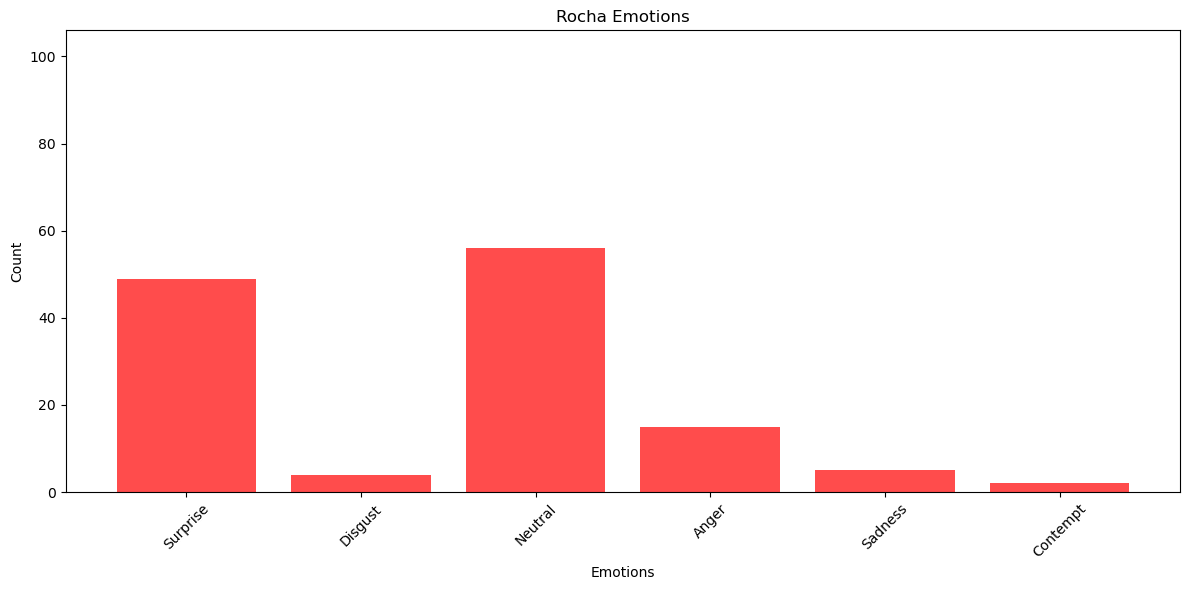

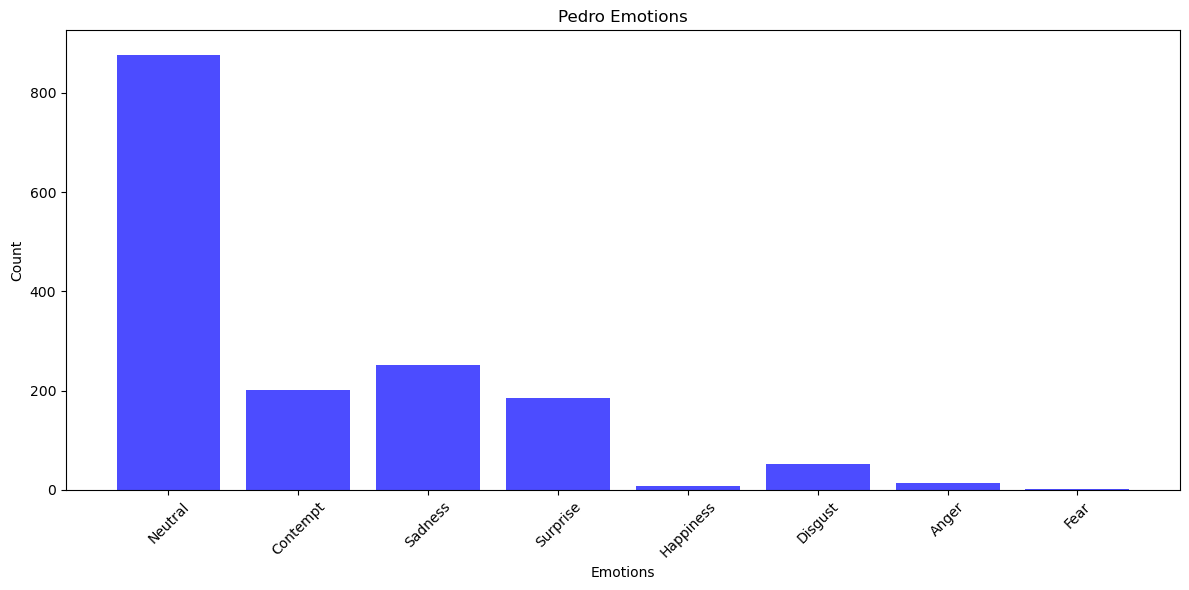

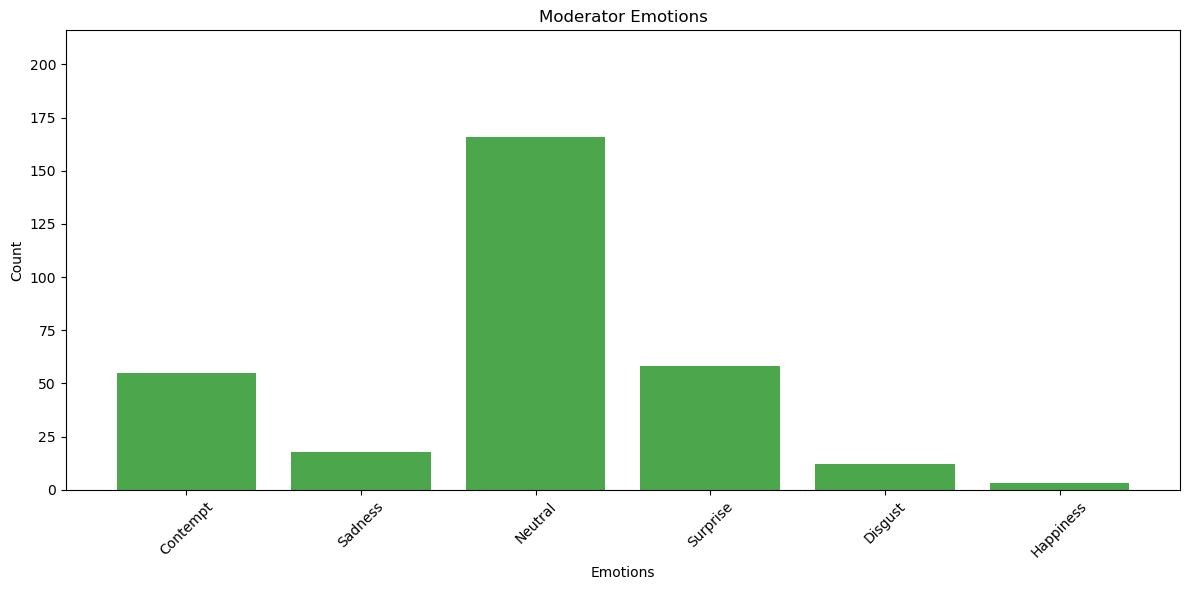

In [67]:
df_both_candidates_same_frame = copy.deepcopy(dfs[debate].iloc[C1_modified[0]])

# Get the value from the database of the index obtained from the clustering
df_only_rocha = copy.deepcopy(dfs[debate].iloc[C1_modified[3]])
df_only_pedro = copy.deepcopy(dfs[debate].iloc[C1_modified[1]])
df_moderator = copy.deepcopy(dfs[debate].iloc[C1_modified[2]])

pedro1v1, rocha1v1 = get_location_for_each_candidate(df_both_candidates_same_frame)

pedro_emotions = get_emotions(df_only_pedro , pedro1v1, 0)
rocha_emotions = get_emotions(df_only_rocha, rocha1v1, 0)
moderator_emotions = get_emotions(df_moderator, df_moderator, 1)

print("Rocha Emotions:", rocha_emotions)
print("Pedro Emotions:", pedro_emotions)
print("Moderator Emotions:", moderator_emotions)

plot_emotions("Rocha", rocha_emotions, 'r')
plot_emotions("Pedro", pedro_emotions, 'b')
plot_emotions("Moderator", moderator_emotions, 'g')

emotions[debate]['Rocha']=rocha_emotions
emotions[debate]['Pedro']=pedro_emotions
emotions[debate]['Clara de Sousa']=moderator_emotions

<a id="section3.18"></a>

## 3.18 LIVRE-BE

In [68]:
debate = 'livre-be'

num_clusters = 5
embeddings_umap, cluster_labels = UMAP_with_kmeans(dfs, debate, random_seed, num_clusters)
C1 = plot_clusters(embeddings_umap, cluster_labels, num_clusters)

C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


In [69]:
C1_modified = copy.deepcopy(C1)
cluster_to_plot = 5

print(len(C1_modified[cluster_to_plot-1]))

# Remove outliers
del C1_modified[1][0:4]

# Plot specific cluster (if needed)
# plot_specific_cluster(cluster_to_plot-1, C1_modified, debate, 100)



# Define cluster names
cluster_names = {
    1: 'Mortágua vs Tavares',
    2: 'Mortágua',
    3: 'Tavares', 
    4: 'Panorama',
    5: 'Moderator',
}

# Remove the clusters that correspond to the panorama and txhe moderator
C1_modified = remove_clusters(C1_modified, cluster_names, ['Panorama'])

# Update cluster names
cluster_names = {
    1: 'Mortágua vs Tavares',
    2: 'Mortágua',
    3: 'Tavares', 
    4: 'Moderator',
}

77


Tavares Emotions: defaultdict(<class 'int'>, {'Neutral': 245, 'Fear': 5, 'Surprise': 285, 'Sadness': 17, 'Happiness': 5, 'Contempt': 52, 'Anger': 15, 'Disgust': 10})
Mortagua Emotions: defaultdict(<class 'int'>, {'Neutral': 37, 'Disgust': 29, 'Happiness': 20, 'Surprise': 396, 'Sadness': 51, 'Fear': 16, 'Contempt': 34, 'Anger': 2})
Moderator Emotions: defaultdict(<class 'int'>, {'Disgust': 13, 'Happiness': 2, 'Contempt': 12, 'Neutral': 13, 'Sadness': 12, 'Surprise': 23, 'Anger': 2})


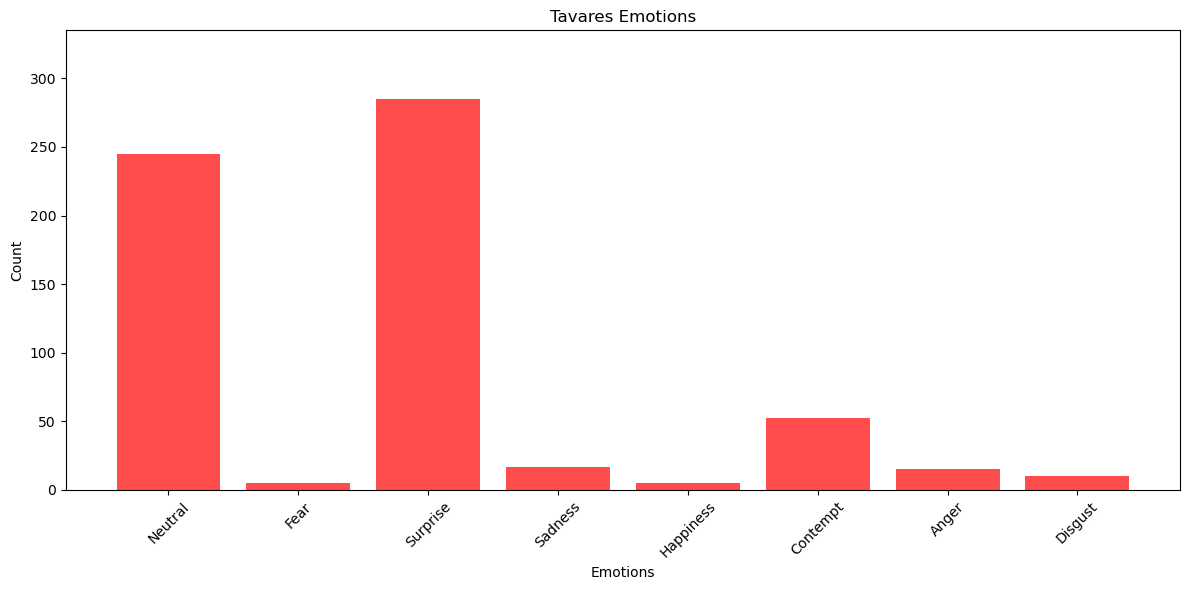

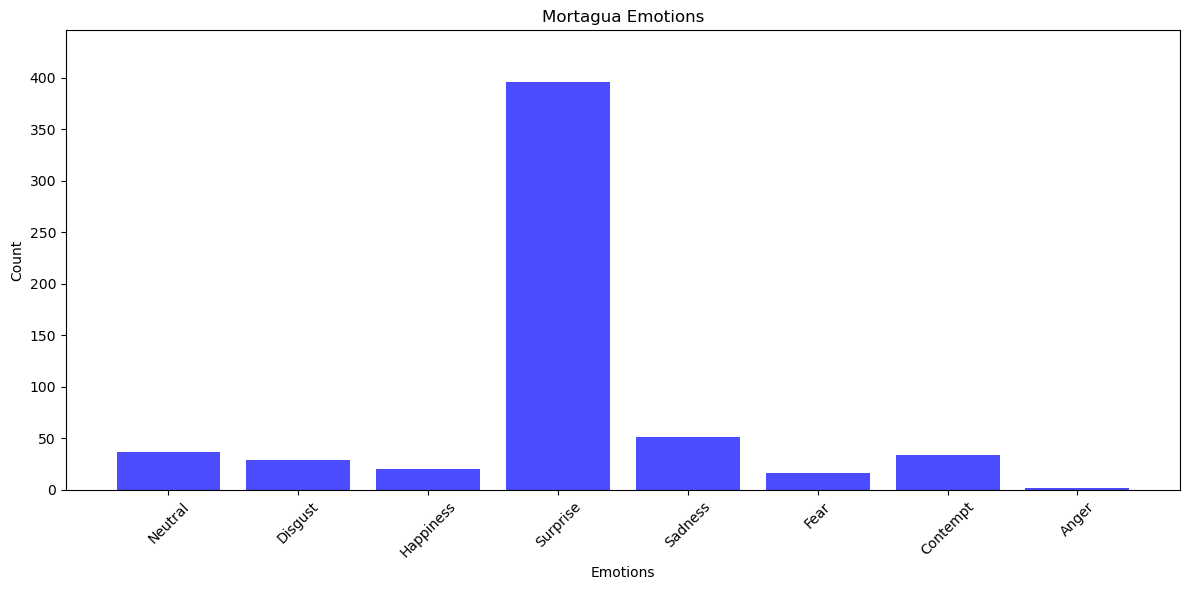

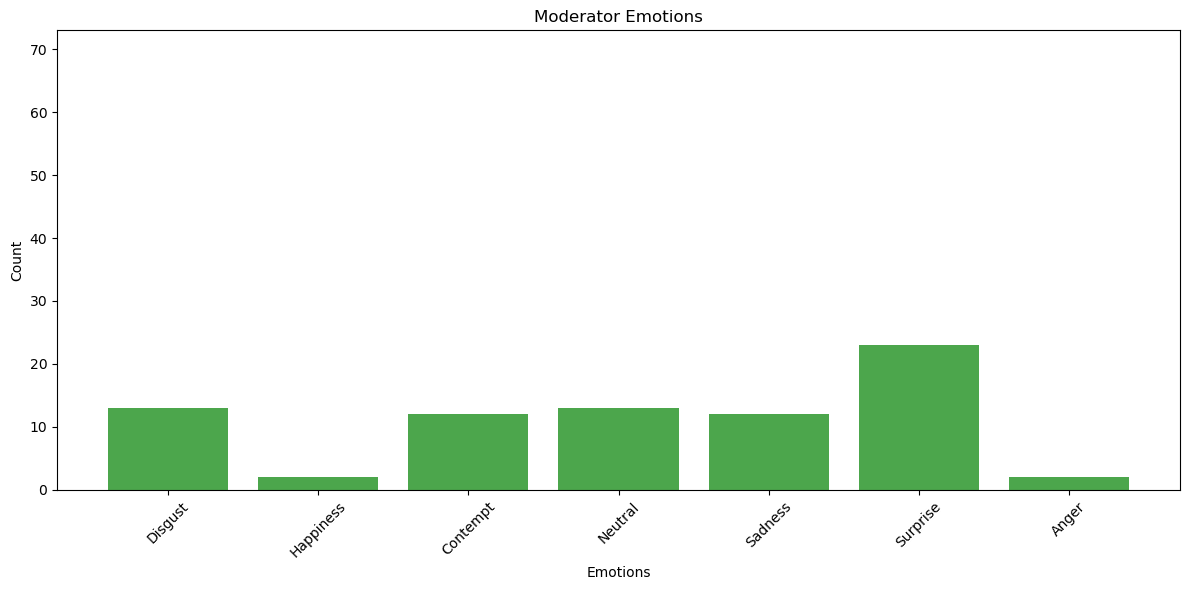

In [70]:
df_both_candidates_same_frame = copy.deepcopy(dfs[debate].iloc[C1_modified[0]])

# Get the value from the database of the index obtained from the clustering
df_only_tavares = copy.deepcopy(dfs[debate].iloc[C1_modified[2]])
df_only_mortagua = copy.deepcopy(dfs[debate].iloc[C1_modified[1]])
df_moderator = copy.deepcopy(dfs[debate].iloc[C1_modified[3]])

mortagua1v1, tavares1v1 = get_location_for_each_candidate(df_both_candidates_same_frame)

mortagua_emotions = get_emotions(df_only_mortagua , mortagua1v1, 0)
tavares_emotions = get_emotions(df_only_tavares, tavares1v1, 0)
moderator_emotions = get_emotions(df_moderator, df_moderator, 1)

print("Tavares Emotions:", tavares_emotions)
print("Mortagua Emotions:", mortagua_emotions)
print("Moderator Emotions:", moderator_emotions)

plot_emotions("Tavares", tavares_emotions, 'r')
plot_emotions("Mortagua", mortagua_emotions, 'b')
plot_emotions("Moderator", moderator_emotions, 'g')

emotions[debate]['Tavares']=tavares_emotions
emotions[debate]['Mortagua']=mortagua_emotions
emotions[debate]['Rosa Pinto']=moderator_emotions

<a id="section3.19"></a>

## 3.19 LIVRE-CDU

In [71]:
debate = 'livre-cdu'

num_clusters = 6
embeddings_umap, cluster_labels = UMAP_with_kmeans(dfs, debate, random_seed, num_clusters)
C1 = plot_clusters(embeddings_umap, cluster_labels, num_clusters)

C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


In [72]:
C1_modified = copy.deepcopy(C1)
cluster_to_plot = 2

print(len(C1_modified[cluster_to_plot-1]))

# Remove outliers
del C1_modified[2][0:6]

# Plot specific cluster (if needed)
# plot_specific_cluster(cluster_to_plot-1, C1_modified, debate, 100)

# Force merging clusters
merged_sorted_values = sorted(C1_modified[1] + C1_modified[4])
C1_modified[1] = merged_sorted_values

# Define cluster names
cluster_names = {
    1: 'Raimundo vs Tavares',
    2: 'Tavares',
    3: 'Raimundo', 
    4: 'Moderator',
    5: 'Panorama',
}

# Remove the clusters that correspond to the panorama and txhe moderator
C1_modified = remove_clusters(C1_modified, cluster_names, ['Panorama'])

# Update cluster names
cluster_names = {
    1: 'Raimundo vs Tavares',
    2: 'Tavares',
    3: 'Raimundo', 
    4: 'Moderator',
}

514


Tavares Emotions: defaultdict(<class 'int'>, {'Neutral': 448, 'Fear': 122, 'Surprise': 709, 'Sadness': 365, 'Disgust': 37, 'Contempt': 16, 'Anger': 63, 'Happiness': 7})
Raimundo Emotions: defaultdict(<class 'int'>, {'Neutral': 194, 'Anger': 44, 'Sadness': 81, 'Surprise': 462, 'Disgust': 27, 'Fear': 8, 'Happiness': 2, 'Contempt': 3})
Moderator Emotions: defaultdict(<class 'int'>, {'Contempt': 6, 'Neutral': 36, 'Surprise': 23, 'Happiness': 2, 'Sadness': 64, 'Anger': 20, 'Disgust': 1, 'Fear': 2})


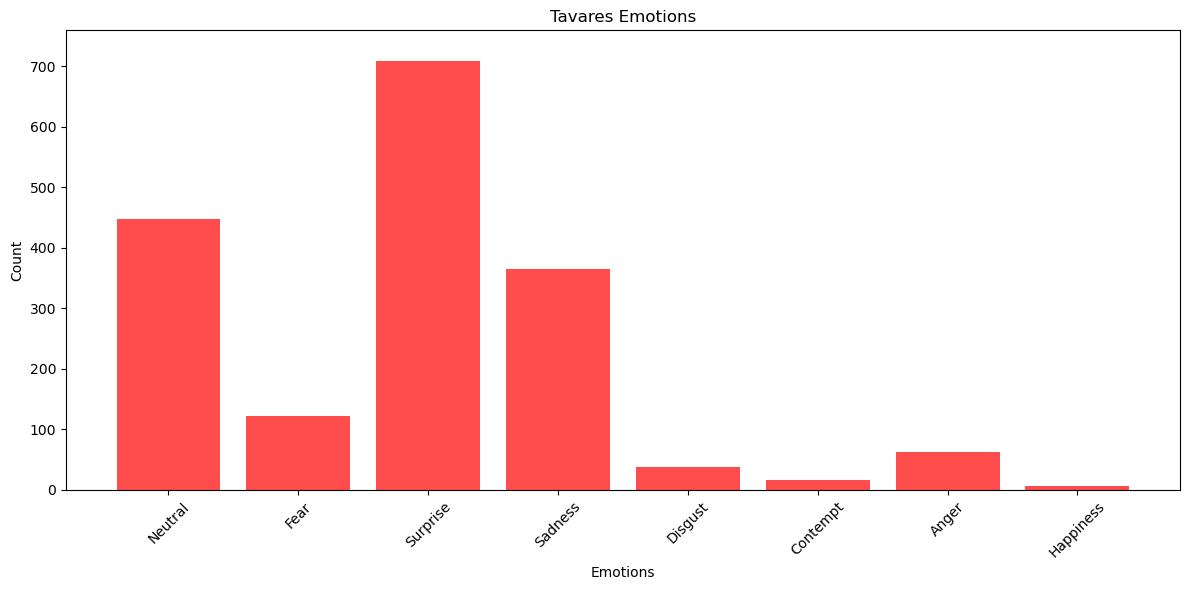

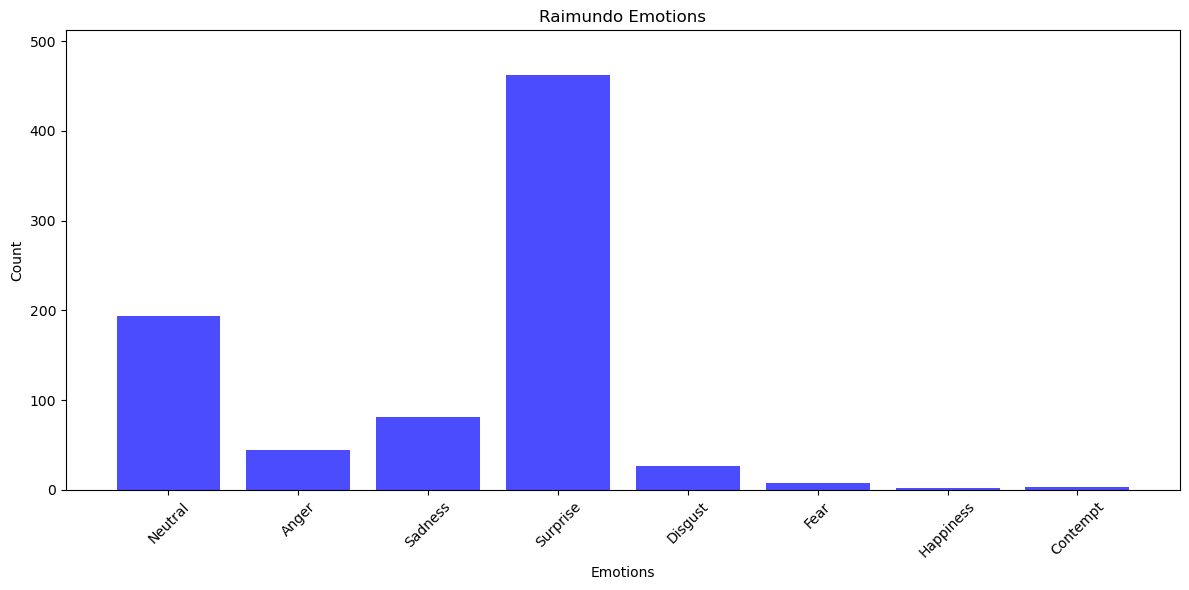

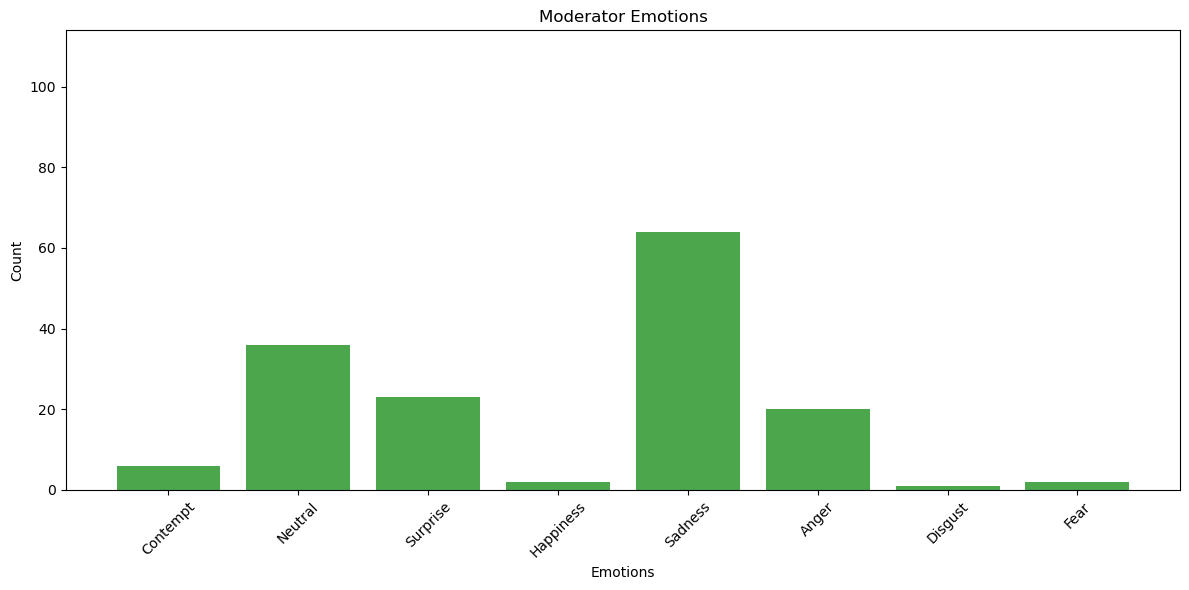

In [73]:
df_both_candidates_same_frame = copy.deepcopy(dfs[debate].iloc[C1_modified[0]])

# Get the value from the database of the index obtained from the clustering
df_only_tavares = copy.deepcopy(dfs[debate].iloc[C1_modified[1]])
df_only_raimundo = copy.deepcopy(dfs[debate].iloc[C1_modified[2]])
df_moderator = copy.deepcopy(dfs[debate].iloc[C1_modified[3]])

df_both_candidates_same_frame = remove_translator1v1(df_both_candidates_same_frame)
df_only_tavares = remove_translator(df_only_tavares)
df_only_raimundo = remove_translator(df_only_raimundo)
df_moderator = remove_translator(df_moderator)

raimundo1v1, tavares1v1 = get_location_for_each_candidate(df_both_candidates_same_frame)

raimundo_emotions = get_emotions(df_only_raimundo , raimundo1v1, 0)
tavares_emotions = get_emotions(df_only_tavares, tavares1v1, 0)
moderator_emotions = get_emotions(df_moderator, df_moderator, 1)

print("Tavares Emotions:", tavares_emotions)
print("Raimundo Emotions:", raimundo_emotions)
print("Moderator Emotions:", moderator_emotions)

plot_emotions("Tavares", tavares_emotions, 'r')
plot_emotions("Raimundo", raimundo_emotions, 'b')
plot_emotions("Moderator", moderator_emotions, 'g')

emotions[debate]['Tavares']=tavares_emotions
emotions[debate]['Raimundo']=raimundo_emotions
emotions[debate]['Joao Marinheiro']=moderator_emotions

<a id="section3.20"></a>

## 3.20 LIVRE-CHEGA

In [74]:
debate = 'livre-chega'

num_clusters = 6
embeddings_umap, cluster_labels = UMAP_with_kmeans(dfs, debate, random_seed, num_clusters)
C1 = plot_clusters(embeddings_umap, cluster_labels, num_clusters)

C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


In [75]:
C1_modified = copy.deepcopy(C1)
cluster_to_plot = 6

print(len(C1_modified[cluster_to_plot-1]))

# Remove outliers
del C1_modified[0][0:7]
del C1_modified[5][0:2]

# Plot specific cluster (if needed)
# plot_specific_cluster(cluster_to_plot-1, C1_modified, debate, 100)

# Define cluster names
cluster_names = {
    1: 'Ventura',
    2: 'Tavares vs Ventura',
    3: 'Tavares', 
    4: 'Panorama',
    5: 'Ventura2',
    6: 'Moderator'
}

# Force merging clusters
merged_sorted_values = sorted(C1_modified[0] + C1_modified[4])
C1_modified[0] = merged_sorted_values

# Remove irrelevant clusters
C1_modified = remove_clusters(C1_modified, cluster_names, ['Panorama', 'Ventura2'])

# Update cluster names
cluster_names = {
    1: 'Ventura',
    2: 'Tavares vs Ventura',
    3: 'Tavares', 
    4: 'Moderator'
}



128


Ventura Emotions: defaultdict(<class 'int'>, {'Sadness': 503, 'Neutral': 398, 'Disgust': 61, 'Surprise': 784, 'Fear': 12, 'Anger': 16, 'Happiness': 86, 'Contempt': 160})
Tavares Emotions: defaultdict(<class 'int'>, {'Disgust': 30, 'Contempt': 58, 'Neutral': 165, 'Surprise': 509, 'Sadness': 169, 'Anger': 5, 'Happiness': 17, 'Fear': 1})
Moderator Emotions: defaultdict(<class 'int'>, {'Anger': 5, 'Happiness': 2, 'Neutral': 24, 'Contempt': 1, 'Surprise': 94})


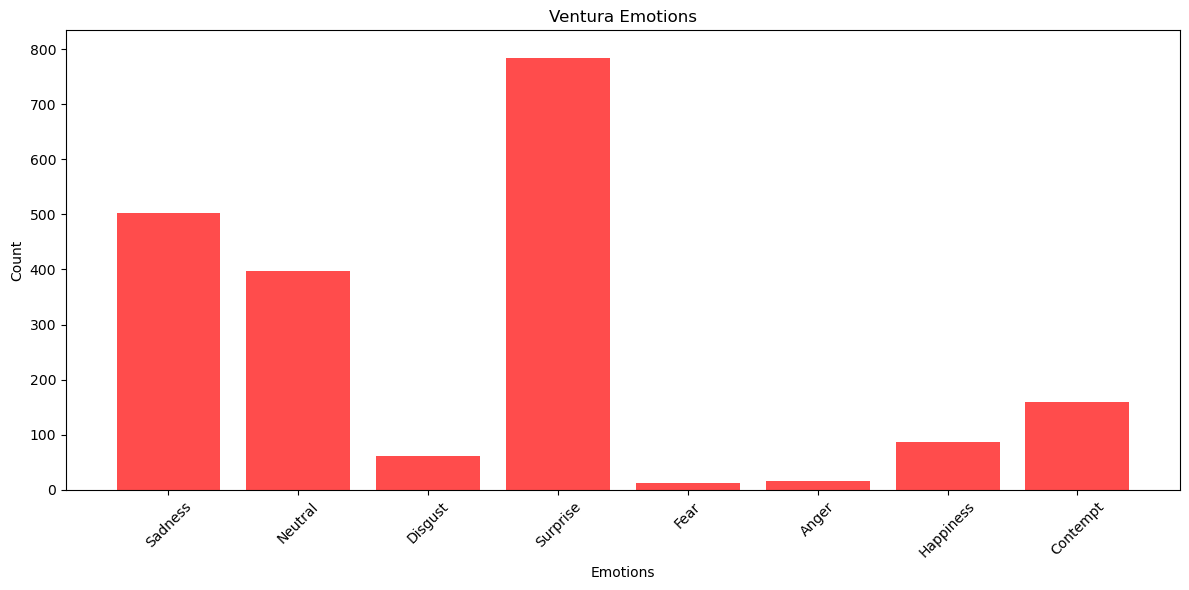

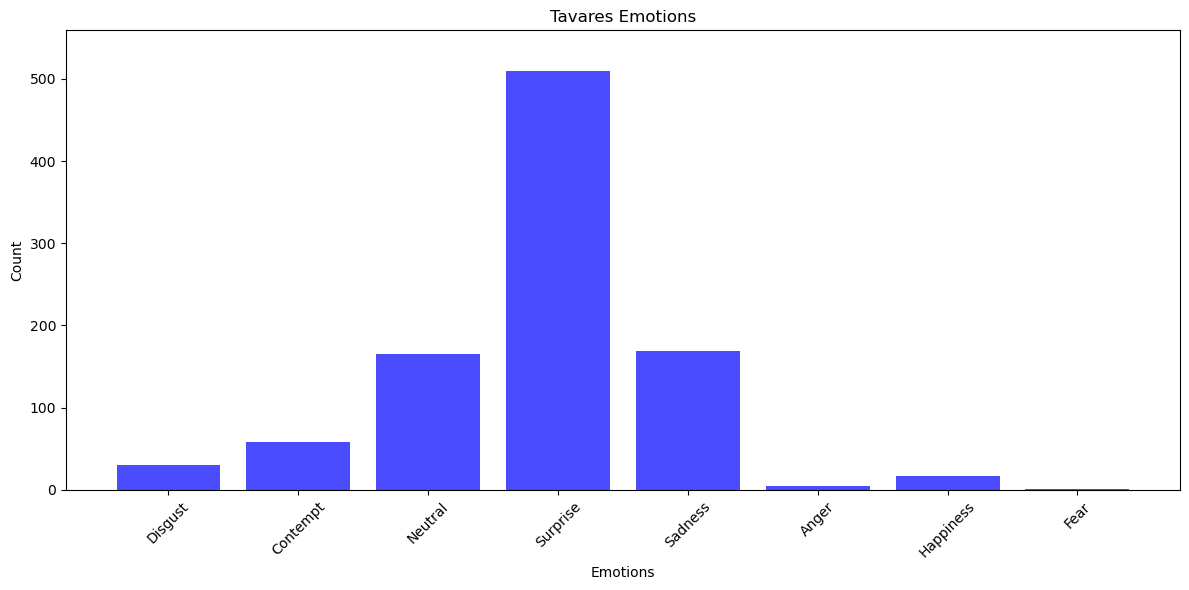

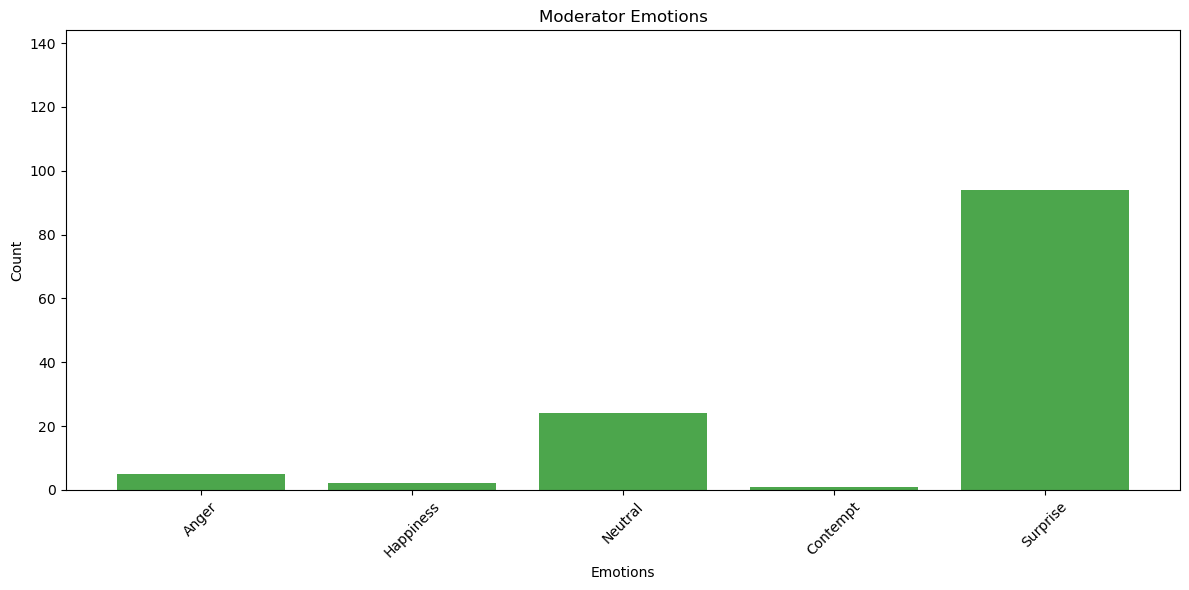

In [76]:
df_both_candidates_same_frame = copy.deepcopy(dfs[debate].iloc[C1_modified[0]])

# Get the value from the database of the index obtained from the clustering
df_only_ventura = copy.deepcopy(dfs[debate].iloc[C1_modified[1]])
df_only_tavares = copy.deepcopy(dfs[debate].iloc[C1_modified[2]])
df_moderator = copy.deepcopy(dfs[debate].iloc[C1_modified[3]])

df_both_candidates_same_frame = remove_translator1v1(df_both_candidates_same_frame)
df_only_ventura = remove_translator(df_only_ventura)
df_only_tavares = remove_translator(df_only_tavares)
df_moderator = remove_translator(df_moderator)

tavares1v1, ventura1v1 = get_location_for_each_candidate(df_both_candidates_same_frame)

tavares_emotions = get_emotions(df_only_tavares , tavares1v1, 0)
ventura_emotions = get_emotions(df_only_ventura, ventura1v1, 0)
moderator_emotions = get_emotions(df_moderator, df_moderator, 1)

print("Ventura Emotions:", ventura_emotions)
print("Tavares Emotions:", tavares_emotions)
print("Moderator Emotions:", moderator_emotions)

plot_emotions("Ventura", ventura_emotions, 'r')
plot_emotions("Tavares", tavares_emotions, 'b')
plot_emotions("Moderator", moderator_emotions, 'g')

emotions[debate]['Ventura']=ventura_emotions
emotions[debate]['Tavares']=tavares_emotions
emotions[debate]['Rosa Pinto']=moderator_emotions

<a id="section3.21"></a>

## 3.21 LIVRE-IL

In [77]:
debate = 'livre-il'

num_clusters = 6
embeddings_umap, cluster_labels = UMAP_with_kmeans(dfs, debate, random_seed, num_clusters)
C1 = plot_clusters(embeddings_umap, cluster_labels, num_clusters)

C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


In [78]:
C1_modified = copy.deepcopy(C1)
cluster_to_plot = 1

print(len(C1_modified[cluster_to_plot-1]))

# Force merging clusters
merged_sorted_values = sorted(C1_modified[0] + C1_modified[4])
C1_modified[0] = merged_sorted_values

# Plot specific cluster (if needed)
# plot_specific_cluster(cluster_to_plot-1, C1_modified, debate, 100)

# Define cluster names
cluster_names = {
    1: 'Tavares vs Rocha',
    2: 'Panorama',
    3: 'Tavares', 
    4: 'Rocha',
    5: 'Tavares vs Rocha',
    6: 'Moderator'
}

# Remove irrelevant clusters
C1_modified = remove_clusters(C1_modified, cluster_names, ['Panorama'])

# Update cluster names
cluster_names = {
    1: 'Tavares vs Rocha',
    2: 'Tavares', 
    3: 'Rocha',
    5: 'Moderator'
}

# plot_specific_cluster(cluster_to_plot-1, C1_modified, debate, 100)


748


Rocha Emotions: defaultdict(<class 'int'>, {'Sadness': 154, 'Contempt': 338, 'Surprise': 154, 'Neutral': 665, 'Disgust': 188, 'Happiness': 7, 'Fear': 24, 'Anger': 26})
Tavares Emotions: defaultdict(<class 'int'>, {'Neutral': 316, 'Surprise': 500, 'Contempt': 56, 'Disgust': 42, 'Happiness': 15, 'Fear': 3, 'Anger': 34, 'Sadness': 8})
Moderator Emotions: defaultdict(<class 'int'>, {'Surprise': 577, 'Contempt': 286, 'Neutral': 456, 'Sadness': 82, 'Disgust': 55, 'Anger': 23, 'Fear': 6, 'Happiness': 15})


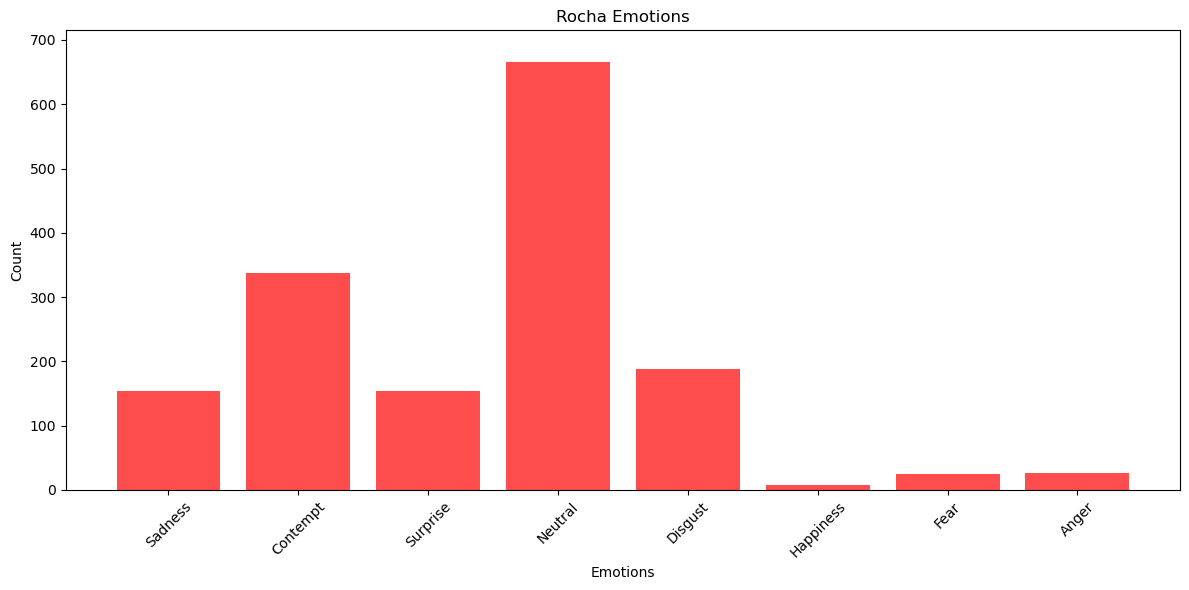

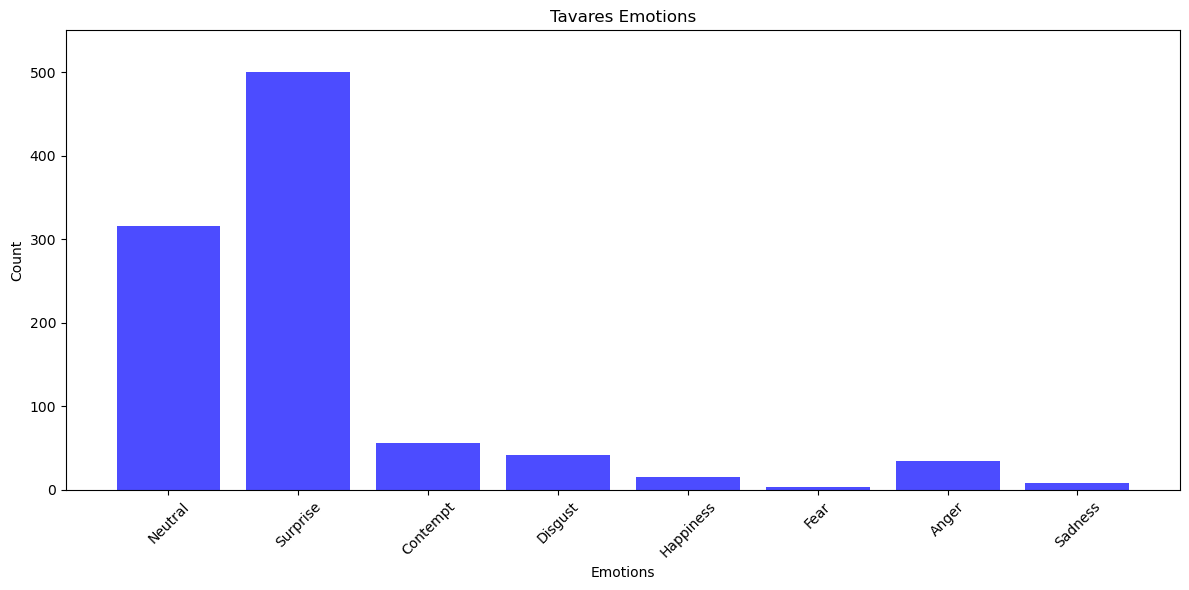

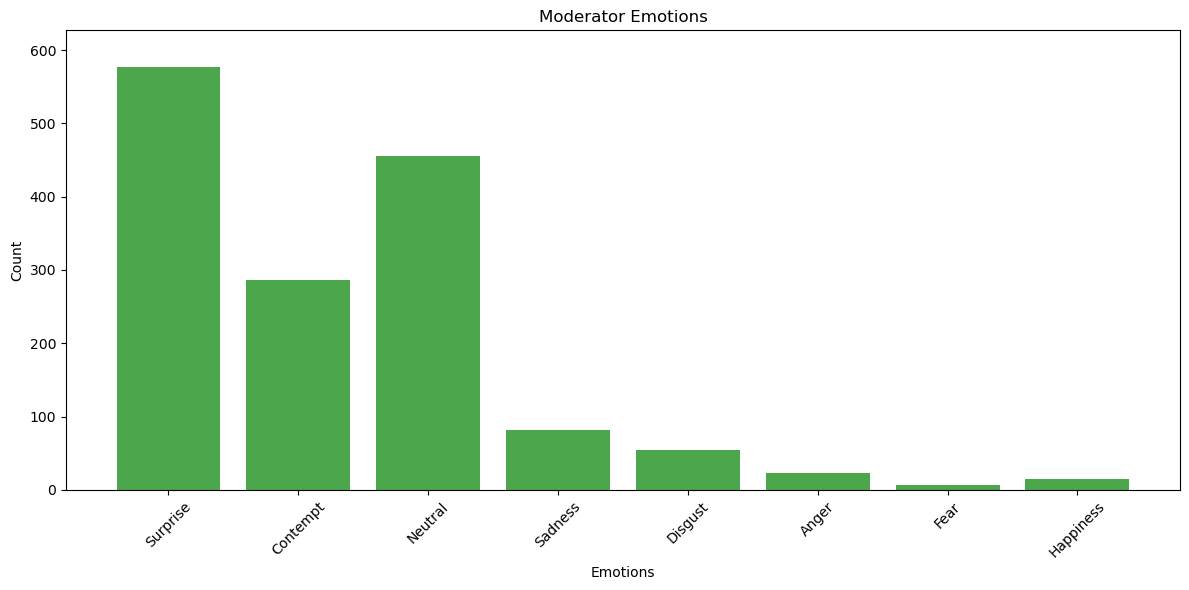

In [79]:
df_both_candidates_same_frame = copy.deepcopy(dfs[debate].iloc[C1_modified[0]])

# Get the value from the database of the index obtained from the clustering
df_only_rocha = copy.deepcopy(dfs[debate].iloc[C1_modified[2]])
df_only_tavares = copy.deepcopy(dfs[debate].iloc[C1_modified[1]])
df_moderator = copy.deepcopy(dfs[debate].iloc[C1_modified[4]])

tavares1v1, rocha1v1 = get_location_for_each_candidate(df_both_candidates_same_frame)

tavares_emotions = get_emotions(df_only_tavares , tavares1v1, 0)
rocha_emotions = get_emotions(df_only_rocha, rocha1v1, 0)
moderator_emotions = get_emotions(df_moderator, df_moderator, 1)

print("Rocha Emotions:", rocha_emotions)
print("Tavares Emotions:", tavares_emotions)
print("Moderator Emotions:", moderator_emotions)

plot_emotions("Rocha", rocha_emotions, 'r')
plot_emotions("Tavares", tavares_emotions, 'b')
plot_emotions("Moderator", moderator_emotions, 'g')

emotions[debate]['Rocha']=rocha_emotions
emotions[debate]['Tavares']=tavares_emotions
emotions[debate]['Joao Marinheiro']=moderator_emotions

<a id="section3.22"></a>

## 3.22 LIVRE-PS

In [80]:
debate = 'livre-ps'

num_clusters = 7
embeddings_umap, cluster_labels = UMAP_with_kmeans(dfs, debate, random_seed, num_clusters)
C1 = plot_clusters(embeddings_umap, cluster_labels, num_clusters)

C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


In [81]:
C1_modified = copy.deepcopy(C1)
cluster_to_plot = 4

print(len(C1_modified[cluster_to_plot-1]))

# Remove outliers
del C1_modified[1][0:2]

# Force merging clusters
merged_sorted_values = sorted(C1_modified[4] + C1_modified[5])
C1_modified[4] = merged_sorted_values

# Plot specific cluster (if needed)
# plot_specific_cluster(cluster_to_plot-1, C1_modified, debate, 100)

# Define cluster names
cluster_names = {
    1: 'Panorama',
    2: 'Pedro',
    3: 'Pedro vs Tavares', 
    4: 'Tavares',
    5: 'Moderator',
    6: 'Irrelevant',
}

# Remove the irrelevant clusters 
C1_modified = remove_clusters(C1_modified, cluster_names, ['Panorama', 'Irrelevant'])

# Update cluster names
cluster_names = {
    1: 'Pedro',
    2: 'Pedro vs Tavares', 
    3: 'Tavares',
    4: 'Moderator',
}

208


Tavares Emotions: defaultdict(<class 'int'>, {'Contempt': 80, 'Happiness': 25, 'Neutral': 384, 'Anger': 171, 'Surprise': 248, 'Fear': 41, 'Disgust': 56, 'Sadness': 117})
Pedro Emotions: defaultdict(<class 'int'>, {'Neutral': 758, 'Sadness': 248, 'Anger': 20, 'Contempt': 21, 'Surprise': 63, 'Fear': 3, 'Disgust': 7, 'Happiness': 2})
Moderator Emotions: defaultdict(<class 'int'>, {'Surprise': 65, 'Neutral': 11, 'Disgust': 12, 'Contempt': 8, 'Happiness': 15, 'Anger': 4, 'Sadness': 4})


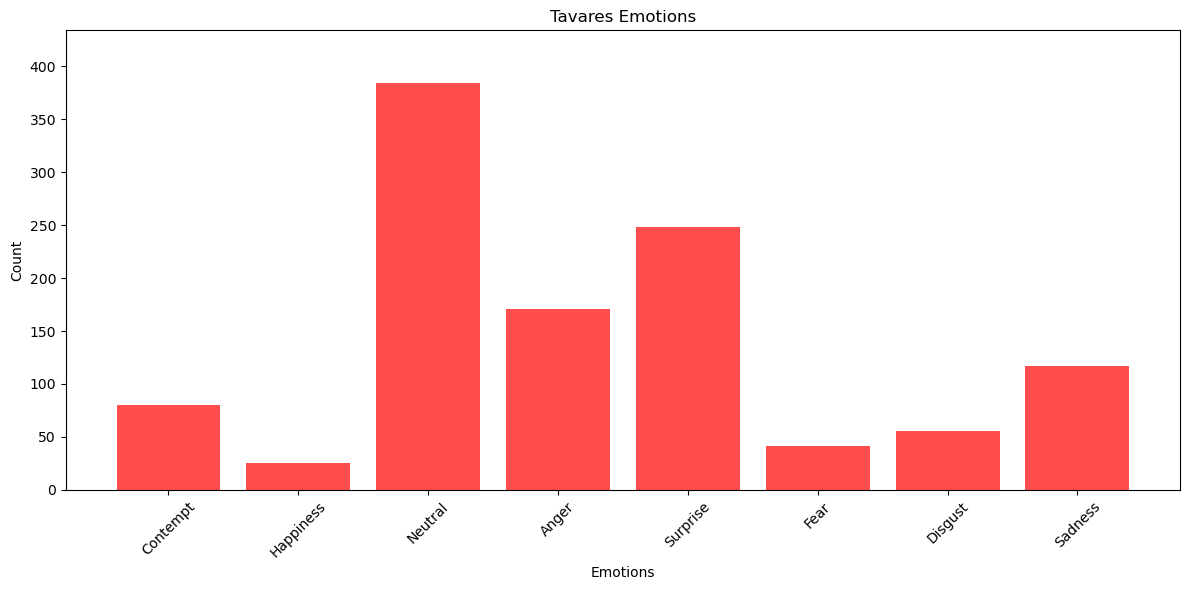

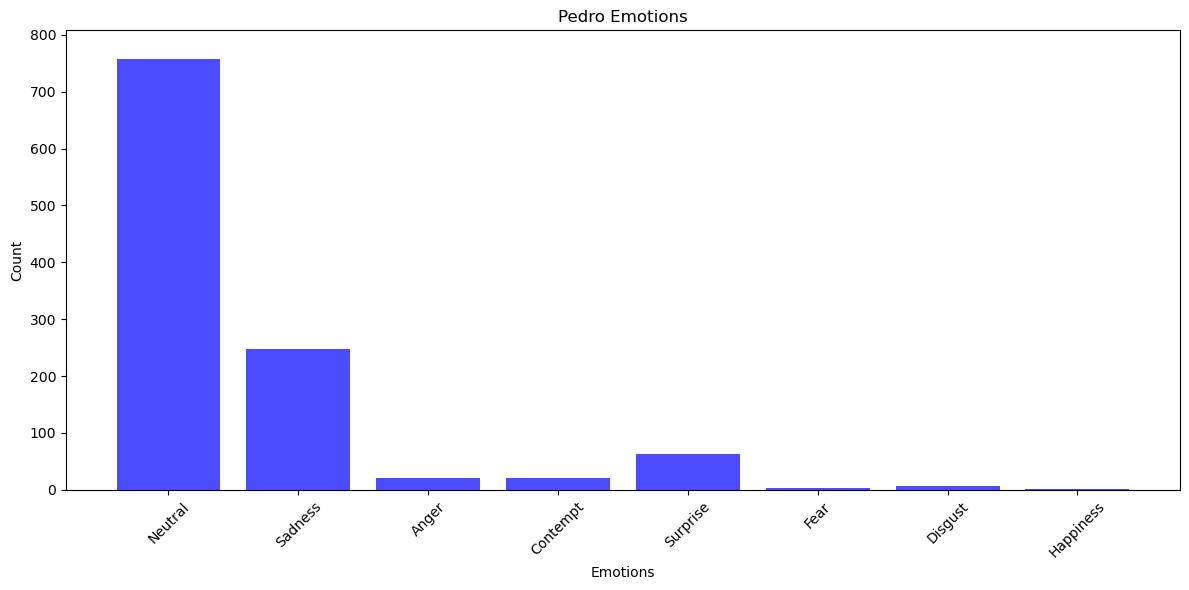

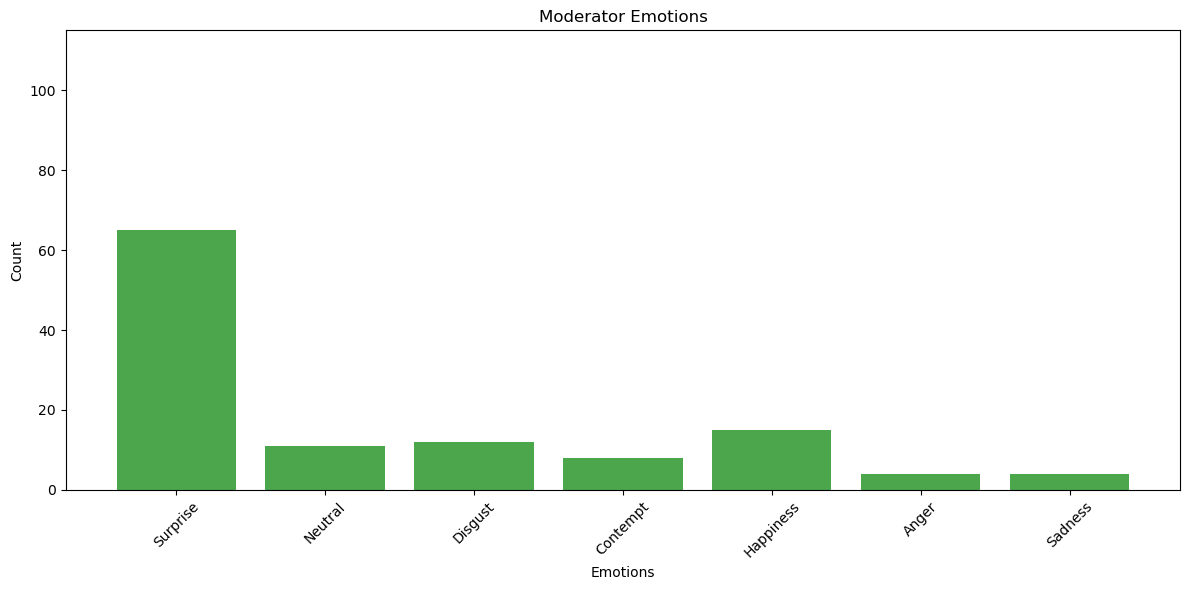

In [82]:
df_both_candidates_same_frame = copy.deepcopy(dfs[debate].iloc[C1_modified[1]])

# Get the value from the database of the index obtained from the clustering
df_only_tavares = copy.deepcopy(dfs[debate].iloc[C1_modified[2]])
df_only_pedro = copy.deepcopy(dfs[debate].iloc[C1_modified[0]])
df_moderator = copy.deepcopy(dfs[debate].iloc[C1_modified[3]])

df_both_candidates_same_frame = remove_translator1v1(df_both_candidates_same_frame)
df_only_tavares = remove_translator(df_only_tavares)
df_only_pedro = remove_translator(df_only_pedro)
df_moderator = remove_translator(df_moderator)

pedro1v1, tavares1v1 = get_location_for_each_candidate(df_both_candidates_same_frame)

pedro_emotions = get_emotions(df_only_pedro , pedro1v1, 0)
tavares_emotions = get_emotions(df_only_tavares, tavares1v1, 0)
moderator_emotions = get_emotions(df_moderator, df_moderator, 1)

print("Tavares Emotions:", tavares_emotions)
print("Pedro Emotions:", pedro_emotions)
print("Moderator Emotions:", moderator_emotions)

plot_emotions("Tavares", tavares_emotions, 'r')
plot_emotions("Pedro", pedro_emotions, 'b')
plot_emotions("Moderator", moderator_emotions, 'g')

emotions[debate]['Tavares']=tavares_emotions
emotions[debate]['Pedro']=pedro_emotions
emotions[debate]['Joao Adelino Faria']=moderator_emotions

<a id="section3.23"></a>

## 3.23 PAN-BE

In [83]:
debate = 'pan-be'

num_clusters = 7
embeddings_umap, cluster_labels = UMAP_with_kmeans(dfs, debate, random_seed, num_clusters)
C1 = plot_clusters(embeddings_umap, cluster_labels, num_clusters)

C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


In [84]:
C1_modified = copy.deepcopy(C1)
cluster_to_plot = 7

print(len(C1_modified[cluster_to_plot-1]))

# Plot specific cluster (if needed)
# plot_specific_cluster(cluster_to_plot-1, C1_modified, debate, 100)

# Force merging clusters
merged_sorted_values = sorted(C1_modified[1] + C1_modified[4])
C1_modified[1] = merged_sorted_values

merged_sorted_values2 = sorted(C1_modified[0] + C1_modified[6])
C1_modified[0] = merged_sorted_values2

# Define cluster names
cluster_names = {
    1: 'Mortagua',
    2: 'Mortagua vs Ines',
    3: 'Ines', 
    4: 'Panorama',
    5: 'Moderator',
}

# Remove the irrelevant clusters 
C1_modified = remove_clusters(C1_modified, cluster_names, ['Panorama'])

# Update cluster names
cluster_names = {
    1: 'Mortagua',
    2: 'Mortagua vs Ines',
    3: 'Ines', 
    4: 'Moderator',
}

115


Ines Emotions: defaultdict(<class 'int'>, {'Surprise': 328, 'Disgust': 293, 'Fear': 3, 'Sadness': 64, 'Anger': 46, 'Neutral': 163, 'Contempt': 7, 'Happiness': 2})
Mortagua Emotions: defaultdict(<class 'int'>, {'Surprise': 863, 'Sadness': 30, 'Contempt': 47, 'Neutral': 174, 'Disgust': 71, 'Fear': 11, 'Anger': 8, 'Happiness': 1})
Moderator Emotions: defaultdict(<class 'int'>, {'Neutral': 25, 'Sadness': 21, 'Surprise': 9, 'Contempt': 3, 'Anger': 18, 'Disgust': 2, 'Happiness': 2})


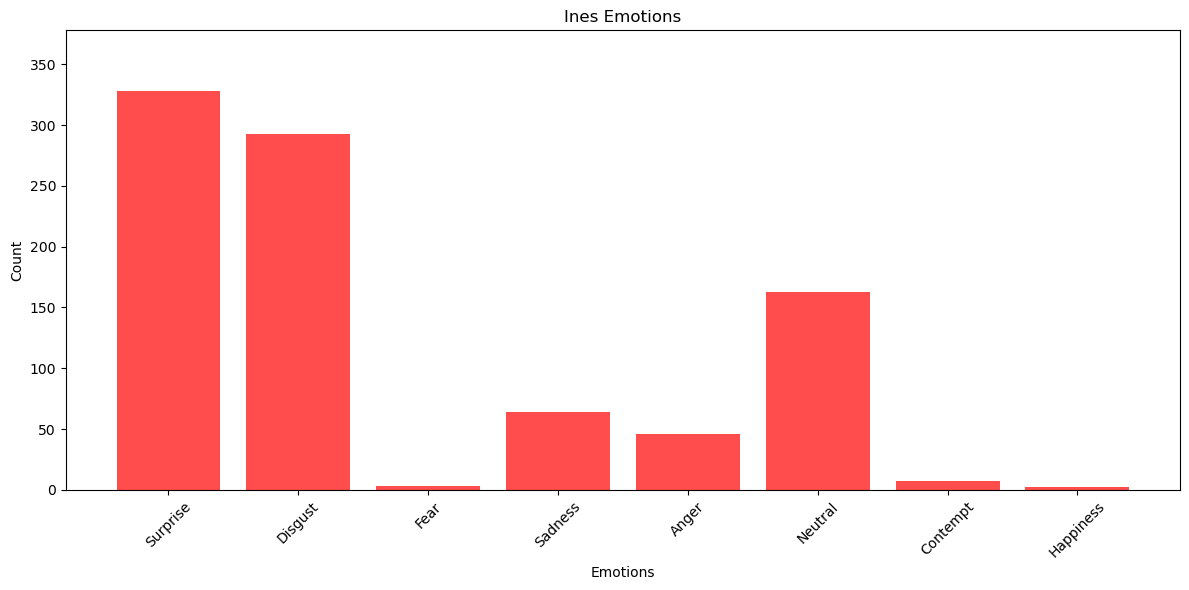

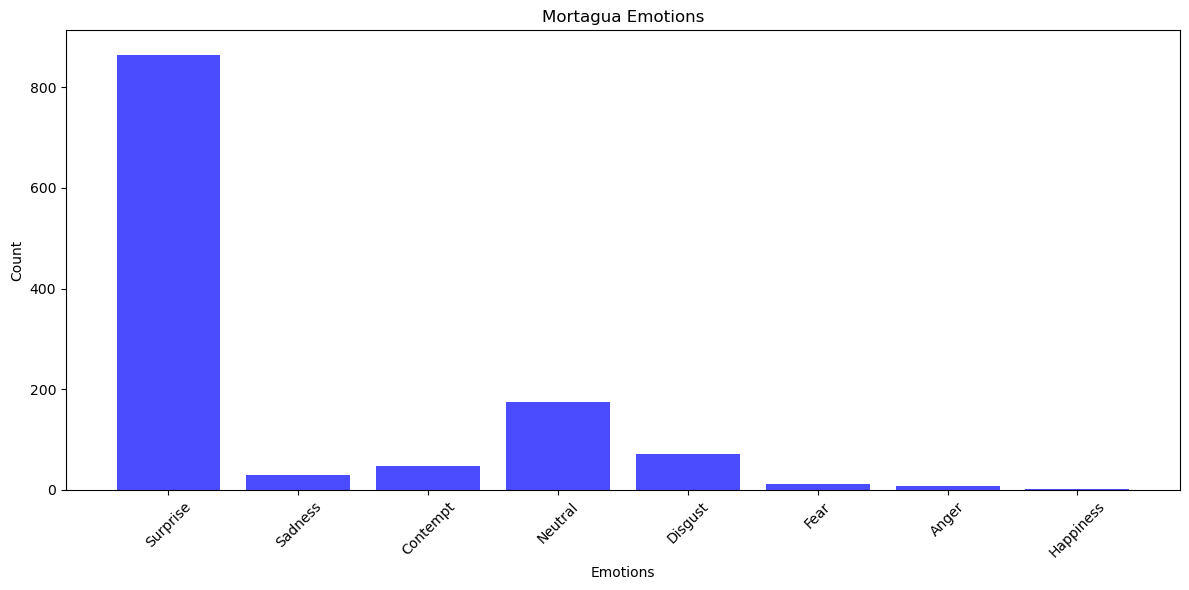

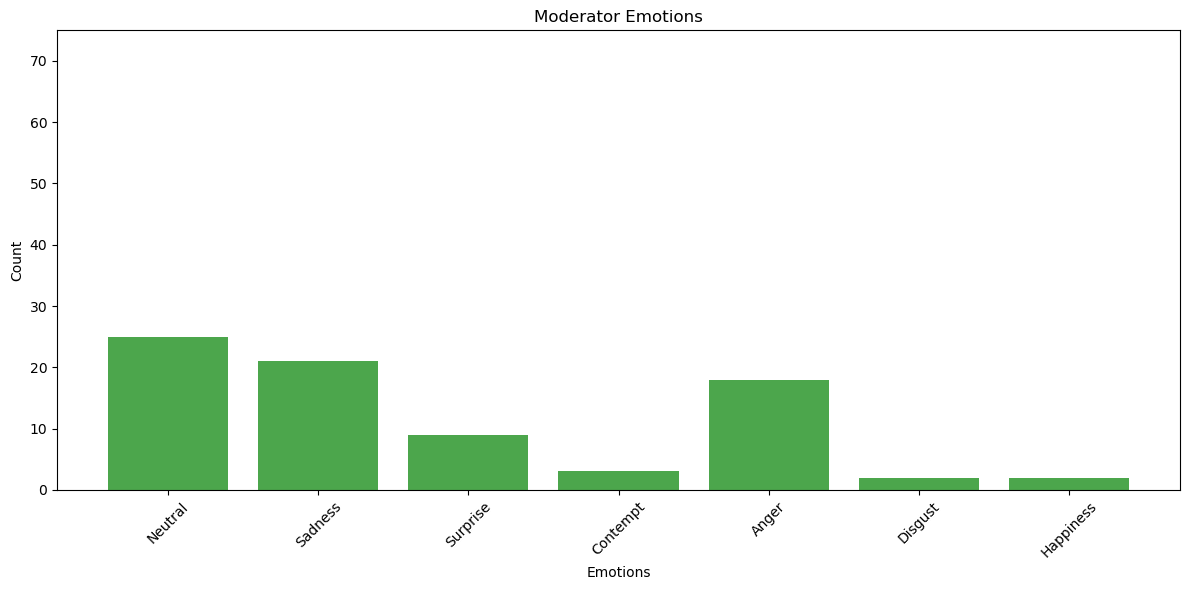

In [85]:
df_both_candidates_same_frame = copy.deepcopy(dfs[debate].iloc[C1_modified[1]])

# Get the value from the database of the index obtained from the clustering
df_only_ines = copy.deepcopy(dfs[debate].iloc[C1_modified[2]])
df_only_mortagua = copy.deepcopy(dfs[debate].iloc[C1_modified[0]])
df_moderator = copy.deepcopy(dfs[debate].iloc[C1_modified[3]])

mortagua1v1, ines1v1 = get_location_for_each_candidate(df_both_candidates_same_frame)

mortagua_emotions = get_emotions(df_only_mortagua , mortagua1v1, 0)
ines_emotions = get_emotions(df_only_ines, ines1v1, 0)
moderator_emotions = get_emotions(df_moderator, df_moderator, 1)

print("Ines Emotions:", ines_emotions)
print("Mortagua Emotions:", mortagua_emotions)
print("Moderator Emotions:", moderator_emotions)

plot_emotions("Ines", ines_emotions, 'r')
plot_emotions("Mortagua", mortagua_emotions, 'b')
plot_emotions("Moderator", moderator_emotions, 'g')

emotions[debate]['Ines']=ines_emotions
emotions[debate]['Mortagua']=mortagua_emotions
emotions[debate]['Joao Marinheiro']=moderator_emotions

<a id="section3.24"></a>

## 3.24 PAN-CDU

In [86]:
debate = 'pan-cdu'

num_clusters = 7
embeddings_umap, cluster_labels = UMAP_with_kmeans(dfs, debate, random_seed, num_clusters)
C1 = plot_clusters(embeddings_umap, cluster_labels, num_clusters)

C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


In [87]:
C1_modified = copy.deepcopy(C1)
cluster_to_plot = 7

print(len(C1_modified[cluster_to_plot-1]))

# Plot specific cluster (if needed)
# plot_specific_cluster(cluster_to_plot-1, C1_modified, debate, 100)

# Force merging clusters
merged_sorted_values = sorted(C1_modified[1] + C1_modified[6])
C1_modified[1] = merged_sorted_values

# Define cluster names
cluster_names = {
    1: 'Ines',
    2: 'Raimundo',
    3: 'Raimundo vs Ines', 
    4: 'Moderator',
    5: 'Panorama',
    6: 'Irrelevant',
}

# Remove the irrelevant clusters 
C1_modified = remove_clusters(C1_modified, cluster_names, ['Panorama', 'Irrelevant'])

# Update cluster names
cluster_names = {
    1: 'Ines',
    2: 'Raimundo',
    3: 'Raimundo vs Ines', 
    4: 'Moderator',
}

30


Ines Emotions: defaultdict(<class 'int'>, {'Neutral': 189, 'Contempt': 7, 'Disgust': 42, 'Sadness': 75, 'Surprise': 377, 'Fear': 24, 'Anger': 2, 'Happiness': 10})
Raimundo Emotions: defaultdict(<class 'int'>, {'Surprise': 285, 'Contempt': 69, 'Disgust': 104, 'Neutral': 297, 'Happiness': 25, 'Sadness': 82, 'Anger': 84, 'Fear': 3})
Moderator Emotions: defaultdict(<class 'int'>, {'Fear': 24, 'Neutral': 213, 'Anger': 7, 'Sadness': 50, 'Disgust': 76, 'Surprise': 43, 'Contempt': 1, 'Happiness': 2})


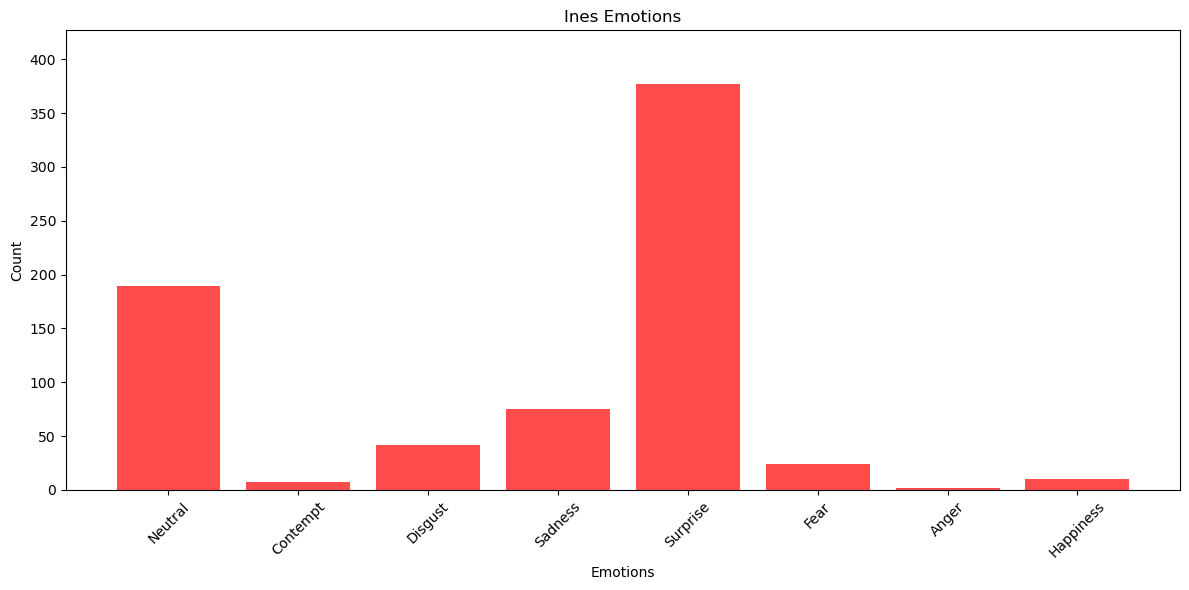

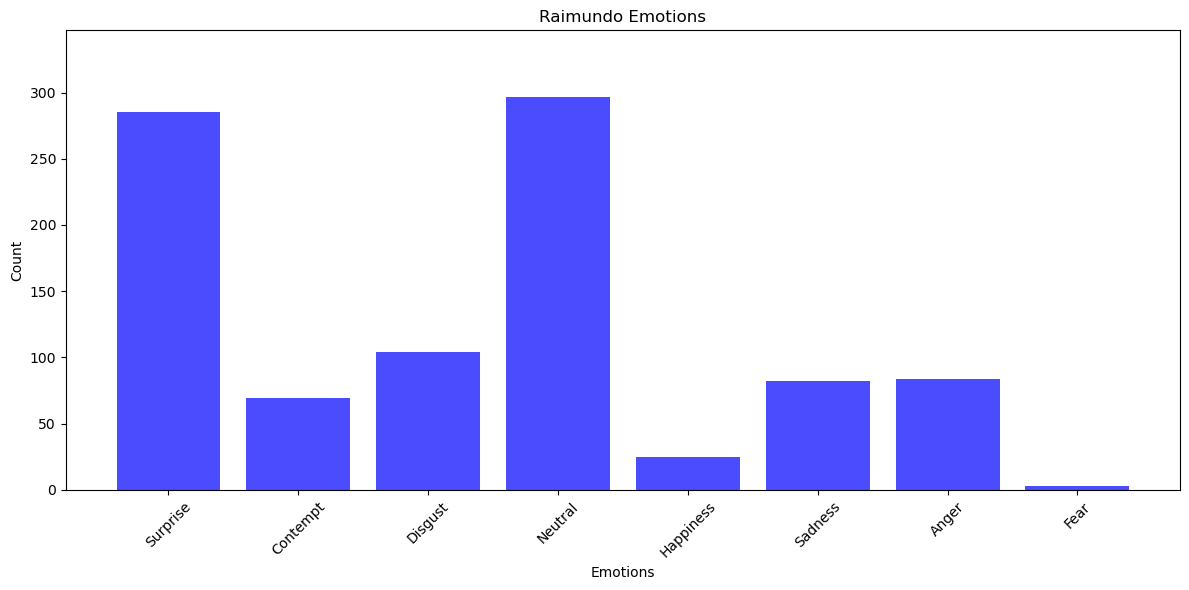

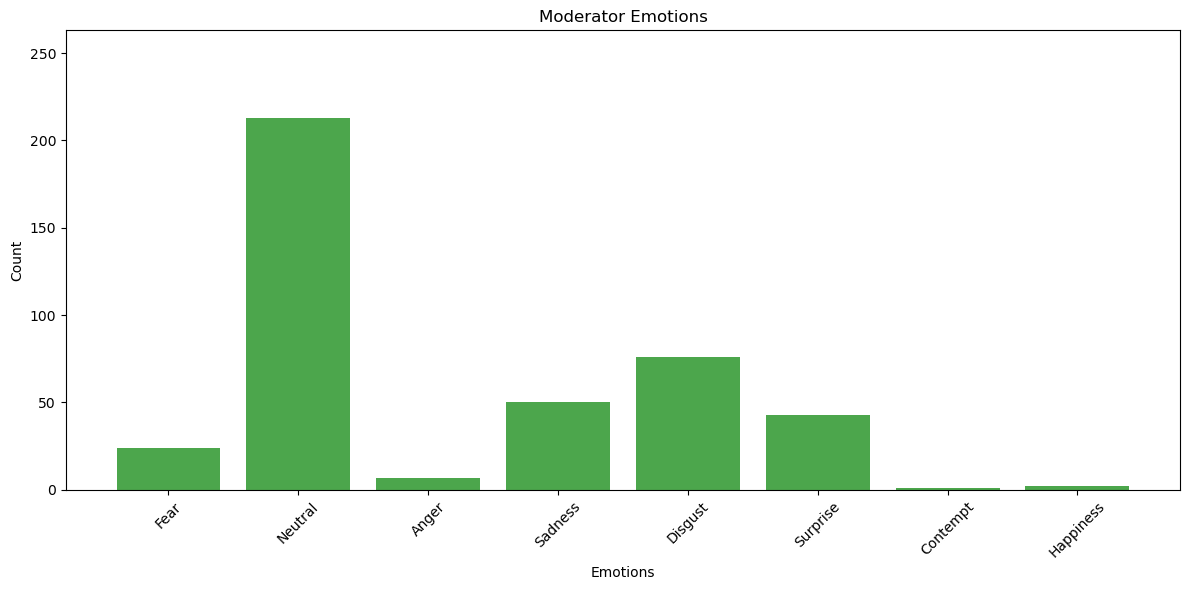

In [88]:
df_both_candidates_same_frame = copy.deepcopy(dfs[debate].iloc[C1_modified[2]])

# Get the value from the database of the index obtained from the clustering
df_only_ines = copy.deepcopy(dfs[debate].iloc[C1_modified[0]])
df_only_raimundo = copy.deepcopy(dfs[debate].iloc[C1_modified[1]])
df_moderator = copy.deepcopy(dfs[debate].iloc[C1_modified[3]])

df_both_candidates_same_frame = remove_translator1v1(df_both_candidates_same_frame)
df_only_ines = remove_translator(df_only_ines)
df_only_raimundo = remove_translator(df_only_raimundo)
df_moderator = remove_translator(df_moderator)

raimundo1v1, ines1v1 = get_location_for_each_candidate(df_both_candidates_same_frame)

raimundo_emotions = get_emotions(df_only_raimundo , raimundo1v1, 0)
ines_emotions = get_emotions(df_only_ines, ines1v1, 0)
moderator_emotions = get_emotions(df_moderator, df_moderator, 1)

print("Ines Emotions:", ines_emotions)
print("Raimundo Emotions:", raimundo_emotions)
print("Moderator Emotions:", moderator_emotions)

plot_emotions("Ines", ines_emotions, 'r')
plot_emotions("Raimundo", raimundo_emotions, 'b')
plot_emotions("Moderator", moderator_emotions, 'g')

emotions[debate]['Ines']=ines_emotions
emotions[debate]['Raimundo']=raimundo_emotions
emotions[debate]['Joao Adelino Faria']=moderator_emotions

<a id="section3.25"></a>

## 3.25 PAN-CHEGA

In [89]:
debate = 'pan-chega'

num_clusters = 6
embeddings_umap, cluster_labels = UMAP_with_kmeans(dfs, debate, random_seed, num_clusters)
C1 = plot_clusters(embeddings_umap, cluster_labels, num_clusters)

C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


In [90]:
C1_modified = copy.deepcopy(C1)
cluster_to_plot = 4

print(len(C1_modified[cluster_to_plot-1]))

#  Remove outliers
del C1_modified[4][0:1]

# Plot specific cluster (if needed)
# plot_specific_cluster(cluster_to_plot-1, C1_modified, debate, 100)

# Define cluster names
cluster_names = {
    1: 'Ventura',
    2: 'Ventura w/ moderator',
    3: 'Ines', 
    4: 'Moderator',
    5: 'Ines vs Ventura',
    6: 'Panorama',
}

# Remove the irrelevant clusters 
C1_modified = remove_clusters(C1_modified, cluster_names, ['Panorama', 'Ventura w/ moderator'])

# Update cluster names
cluster_names = {
    1: 'Ventura',
    2: 'Ines', 
    3: 'Moderator',
    4: 'Ines vs Ventura',
}

236


ventura Emotions: defaultdict(<class 'int'>, {'Neutral': 245, 'Surprise': 277, 'Sadness': 95, 'Anger': 3, 'Happiness': 9, 'Disgust': 5, 'Contempt': 11, 'Fear': 1})
ines Emotions: defaultdict(<class 'int'>, {'Neutral': 108, 'Sadness': 26, 'Fear': 9, 'Disgust': 84, 'Surprise': 377, 'Happiness': 9, 'Anger': 8})
Moderator Emotions: defaultdict(<class 'int'>, {'Contempt': 47, 'Surprise': 101, 'Disgust': 34, 'Neutral': 21, 'Happiness': 15, 'Anger': 18, 'Sadness': 1})


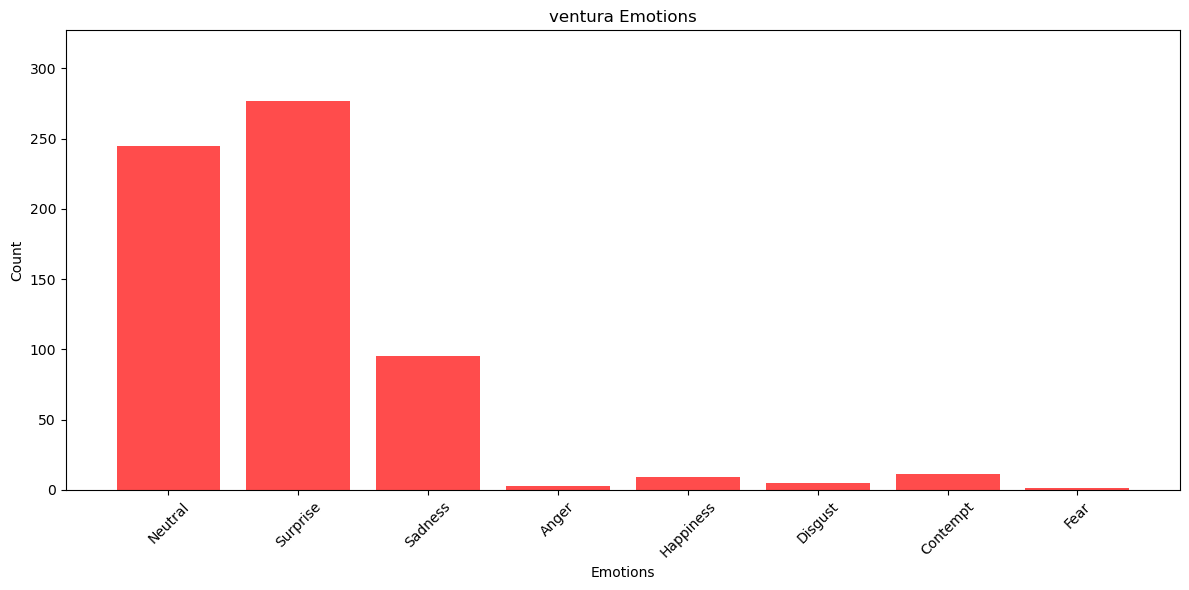

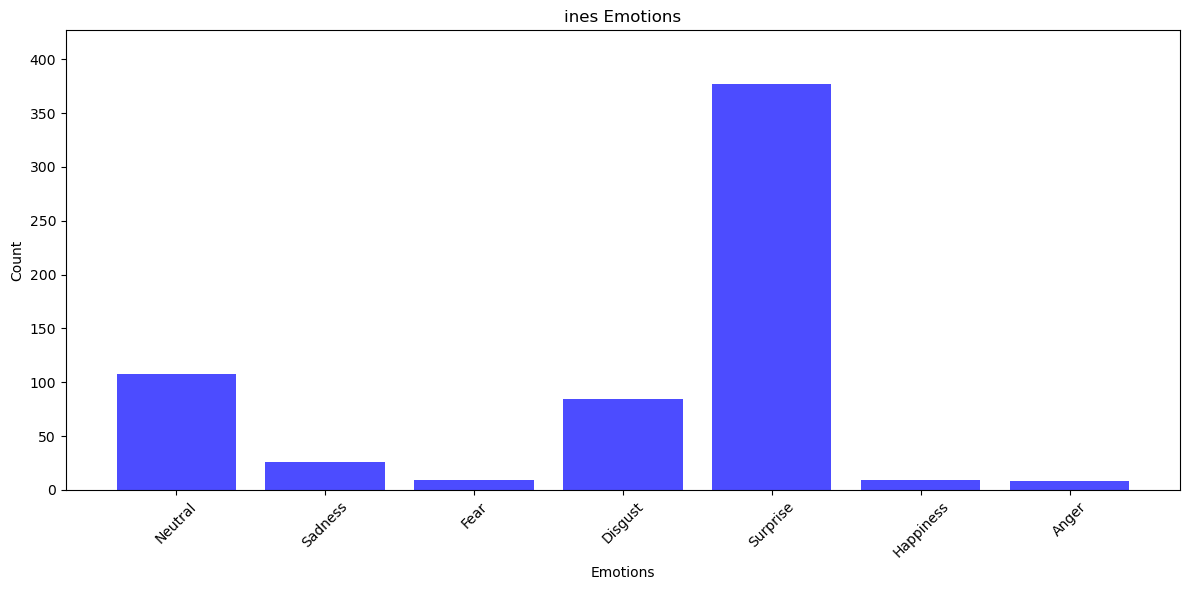

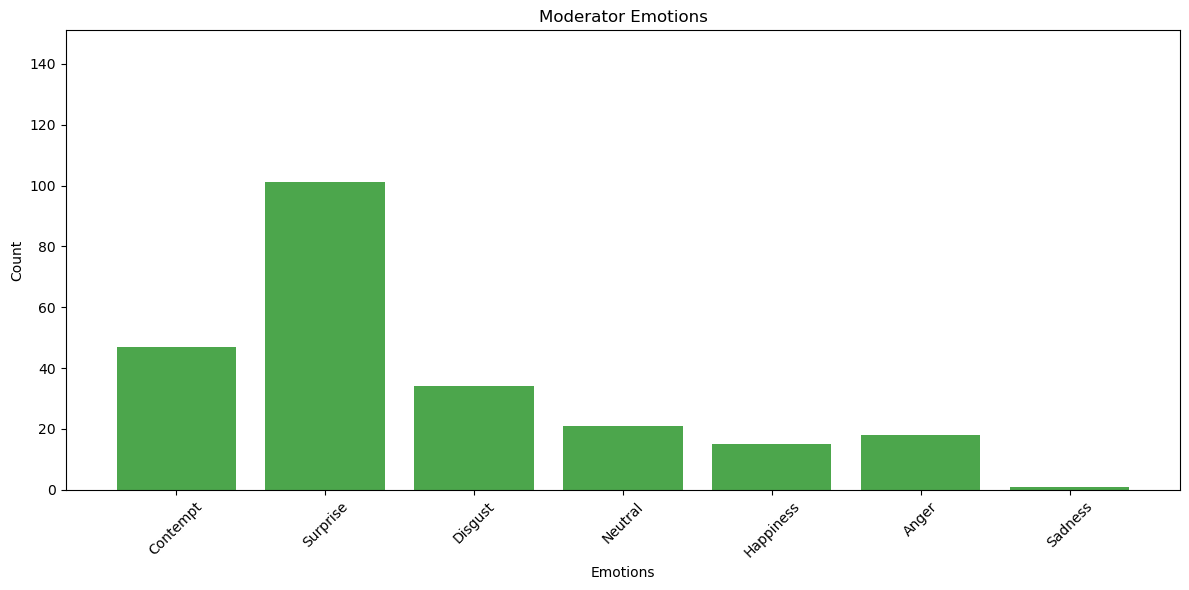

In [91]:
df_both_candidates_same_frame = copy.deepcopy(dfs[debate].iloc[C1_modified[3]])

# Get the value from the database of the index obtained from the clustering
df_only_ventura = copy.deepcopy(dfs[debate].iloc[C1_modified[0]])
df_only_ines = copy.deepcopy(dfs[debate].iloc[C1_modified[1]])
df_moderator = copy.deepcopy(dfs[debate].iloc[C1_modified[2]])

df_both_candidates_same_frame = remove_translator1v1(df_both_candidates_same_frame)
df_only_ventura = remove_translator(df_only_ventura)
df_only_ines = remove_translator(df_only_ines)
df_moderator = remove_translator(df_moderator)

ines1v1, ventura1v1 = get_location_for_each_candidate(df_both_candidates_same_frame)

ines_emotions = get_emotions(df_only_ines , ines1v1, 0)
ventura_emotions = get_emotions(df_only_ventura, ventura1v1, 0)
moderator_emotions = get_emotions(df_moderator, df_moderator, 1)

print("ventura Emotions:", ventura_emotions)
print("ines Emotions:", ines_emotions)
print("Moderator Emotions:", moderator_emotions)

plot_emotions("ventura", ventura_emotions, 'r')
plot_emotions("ines", ines_emotions, 'b')
plot_emotions("Moderator", moderator_emotions, 'g')

emotions[debate]['Ventura']=ventura_emotions
emotions[debate]['Ines']=ines_emotions
emotions[debate]['Joao Adelino Faria']=moderator_emotions

<a id="section3.26"></a>

## 3.26 PAN-IL

In [92]:
debate = 'pan-il'

num_clusters = 5
embeddings_umap, cluster_labels = UMAP_with_kmeans(dfs, debate, random_seed, num_clusters)
C1 = plot_clusters(embeddings_umap, cluster_labels, num_clusters)

C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


In [93]:
C1_modified = copy.deepcopy(C1)
cluster_to_plot = 3

print(len(C1_modified[cluster_to_plot-1]))

# Plot specific cluster (if needed)
# plot_specific_cluster(cluster_to_plot-1, C1_modified, debate, 100)

# Define cluster names
cluster_names = {
    1: 'Rocha',
    2: 'Ines',
    3: 'Ines vs Rocha', 
    4: 'Panorama',
    5: 'Moderator',
}

# Remove the irrelevant clusters 
C1_modified = remove_clusters(C1_modified, cluster_names, ['Panorama'])

# Update cluster names
cluster_names = {
    1: 'Rocha',
    2: 'Ines',
    3: 'Ines vs Rocha', 
    4: 'Moderator',
}

500


Rocha Emotions: defaultdict(<class 'int'>, {'Contempt': 211, 'Happiness': 15, 'Surprise': 155, 'Sadness': 193, 'Neutral': 421, 'Disgust': 154, 'Anger': 5, 'Fear': 65})
Ines Emotions: defaultdict(<class 'int'>, {'Surprise': 360, 'Disgust': 180, 'Sadness': 26, 'Happiness': 14, 'Neutral': 370, 'Contempt': 87, 'Fear': 1, 'Anger': 6})
Moderator Emotions: defaultdict(<class 'int'>, {'Contempt': 7, 'Sadness': 17, 'Happiness': 3, 'Disgust': 10, 'Surprise': 23, 'Neutral': 23, 'Fear': 1, 'Anger': 2})


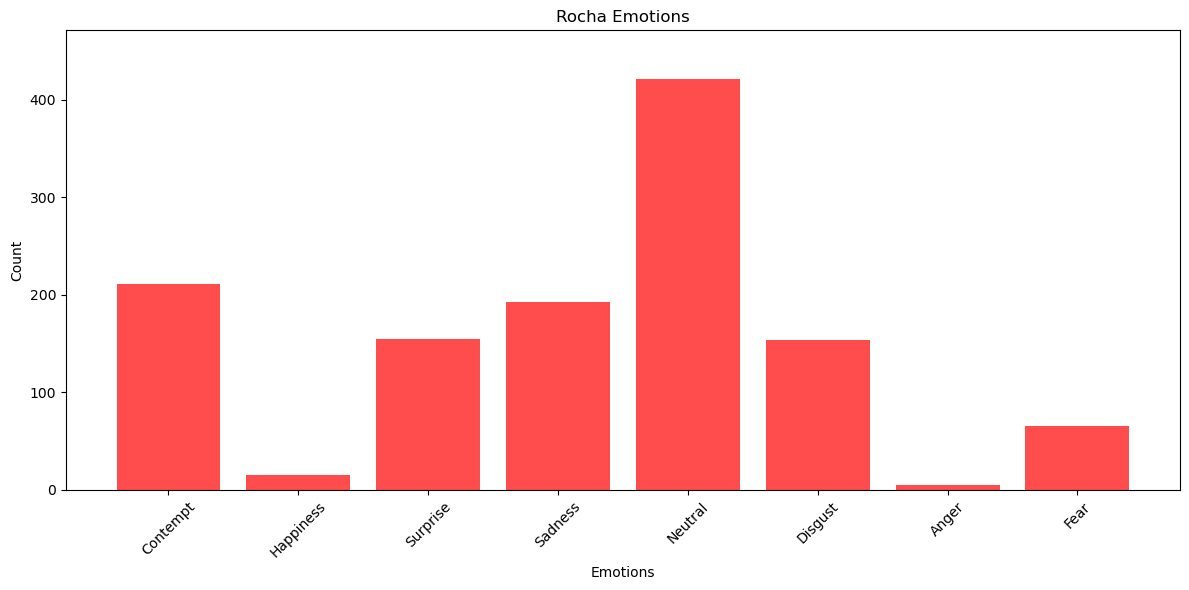

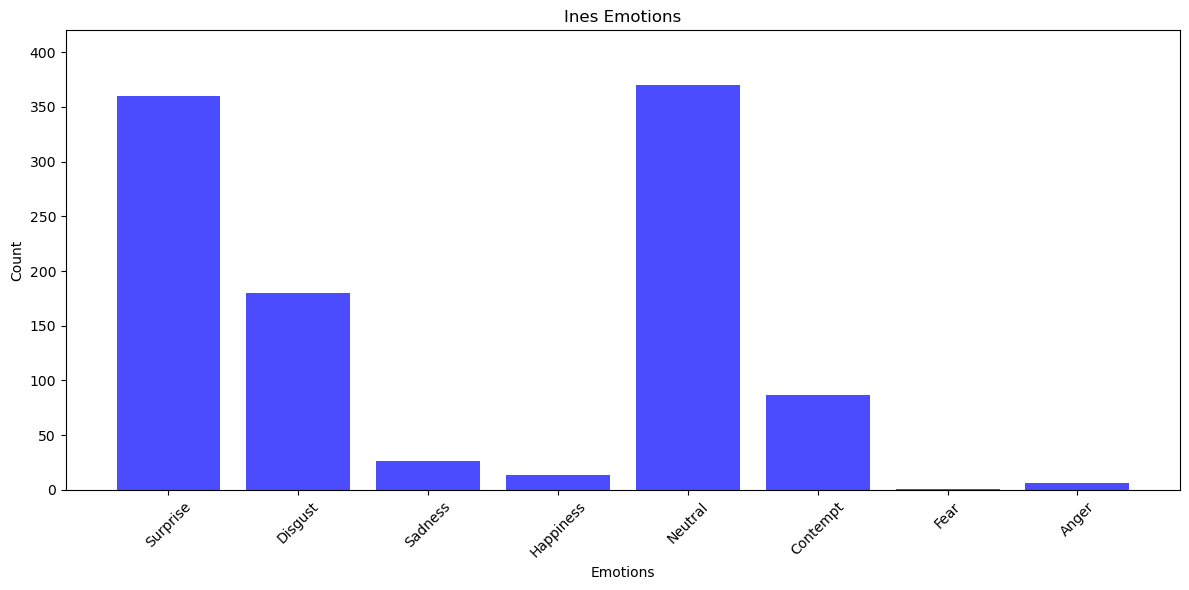

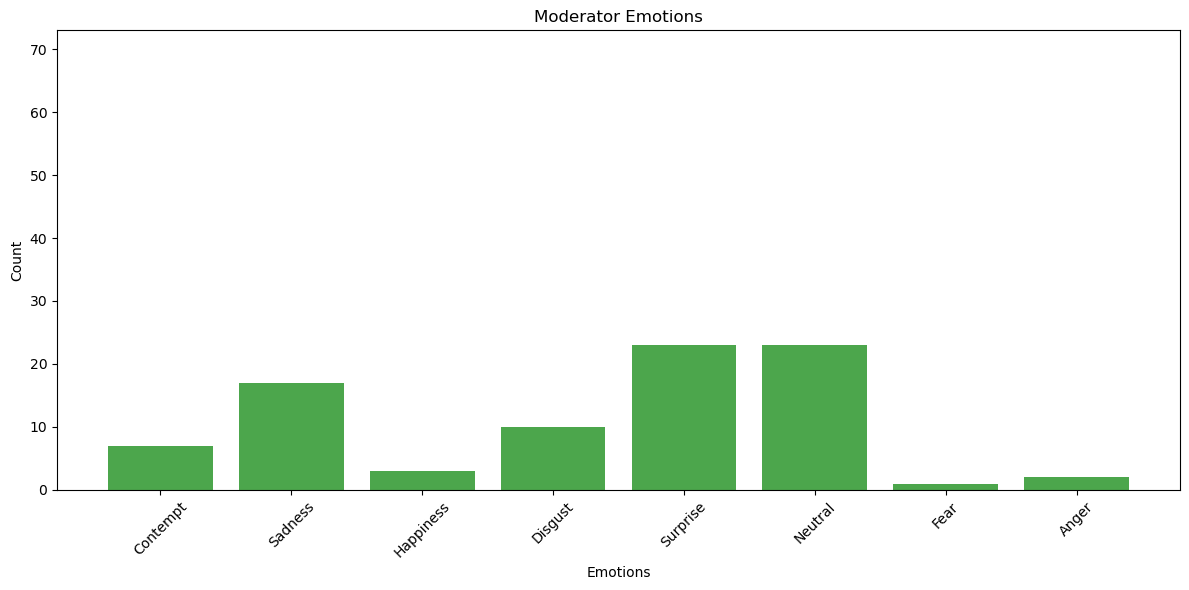

In [94]:
df_both_candidates_same_frame = copy.deepcopy(dfs[debate].iloc[C1_modified[2]])

# Get the value from the database of the index obtained from the clustering
df_only_rocha = copy.deepcopy(dfs[debate].iloc[C1_modified[0]])
df_only_ines = copy.deepcopy(dfs[debate].iloc[C1_modified[1]])
df_moderator = copy.deepcopy(dfs[debate].iloc[C1_modified[3]])

ines1v1, rocha1v1 = get_location_for_each_candidate(df_both_candidates_same_frame)

ines_emotions = get_emotions(df_only_ines , ines1v1, 0)
rocha_emotions = get_emotions(df_only_rocha, rocha1v1, 0)
moderator_emotions = get_emotions(df_moderator, df_moderator, 1)

print("Rocha Emotions:", rocha_emotions)
print("Ines Emotions:", ines_emotions)
print("Moderator Emotions:", moderator_emotions)

plot_emotions("Rocha", rocha_emotions, 'r')
plot_emotions("Ines", ines_emotions, 'b')
plot_emotions("Moderator", moderator_emotions, 'g')

emotions[debate]['Rocha']=rocha_emotions
emotions[debate]['Ines']=ines_emotions
emotions[debate]['Rosa Pinto']=moderator_emotions

<a id="section3.27"></a>

## 3.27 PAN-LIVRE

In [95]:
debate = 'pan-livre'

num_clusters = 5
embeddings_umap, cluster_labels = UMAP_with_kmeans(dfs, debate, random_seed, num_clusters)
C1 = plot_clusters(embeddings_umap, cluster_labels, num_clusters)

C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


In [96]:
C1_modified = copy.deepcopy(C1)
cluster_to_plot = 5

print(len(C1_modified[cluster_to_plot-1]))

# Plot specific cluster (if needed)
# plot_specific_cluster(cluster_to_plot-1, C1_modified, debate, 100)

# Define cluster names
cluster_names = {
    1: 'Tavares vs Ines',
    2: 'Ines',
    3: 'Tavares', 
    4: 'Panorama',
    5: 'Moderator',
}

# Remove the irrelevant clusters 
C1_modified = remove_clusters(C1_modified, cluster_names, ['Panorama'])

# Update cluster names
cluster_names = {
    1: 'Tavares vs Ines',
    2: 'Ines',
    3: 'Tavares', 
    4: 'Moderator',
}

100


Ines Emotions: defaultdict(<class 'int'>, {'Happiness': 22, 'Neutral': 112, 'Sadness': 45, 'Disgust': 197, 'Anger': 16, 'Surprise': 597, 'Fear': 8, 'Contempt': 6})
Tavares Emotions: defaultdict(<class 'int'>, {'Contempt': 26, 'Happiness': 16, 'Disgust': 57, 'Surprise': 502, 'Neutral': 255, 'Anger': 187, 'Fear': 6})
Moderator Emotions: defaultdict(<class 'int'>, {'Surprise': 38, 'Contempt': 19, 'Happiness': 9, 'Disgust': 8, 'Neutral': 21, 'Anger': 3, 'Sadness': 2})


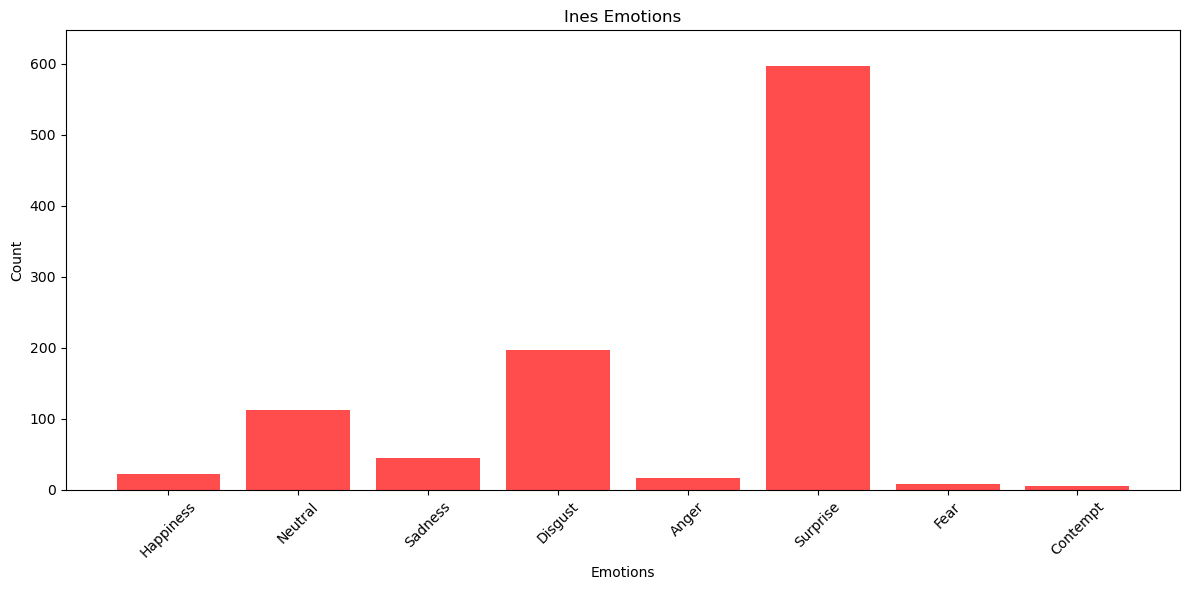

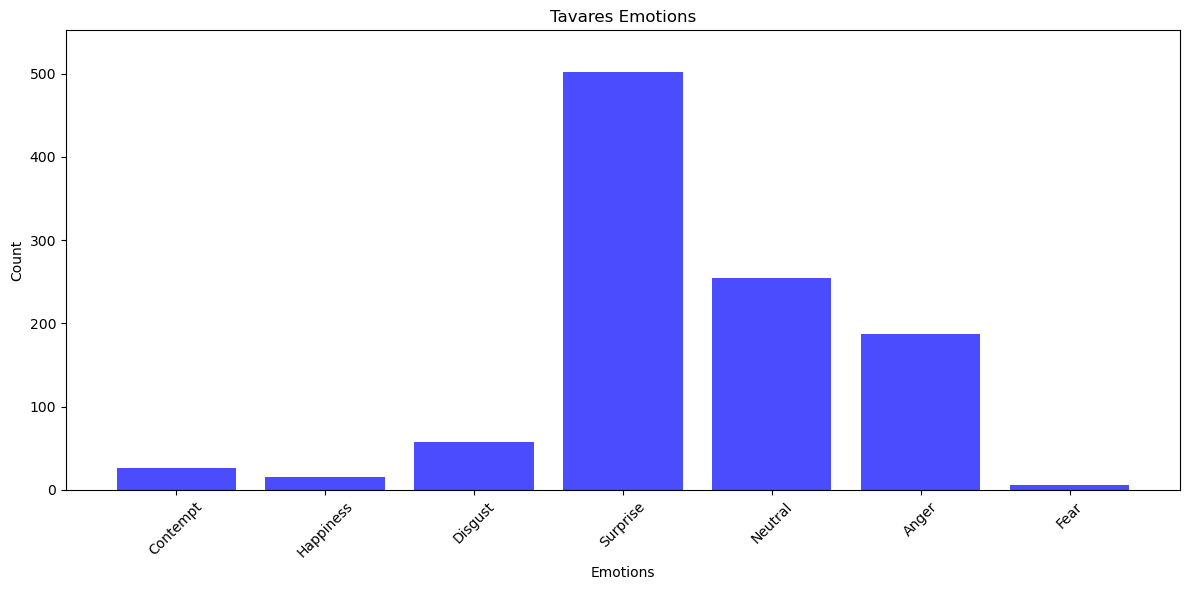

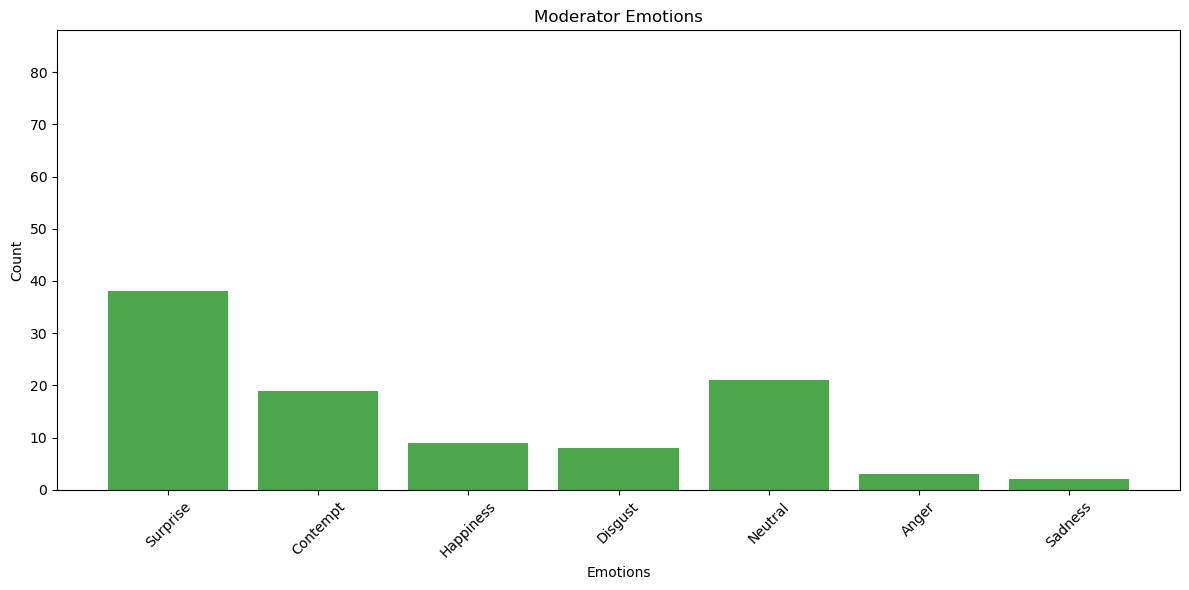

In [97]:
df_both_candidates_same_frame = copy.deepcopy(dfs[debate].iloc[C1_modified[0]])

# Get the value from the database of the index obtained from the clustering
df_only_ines = copy.deepcopy(dfs[debate].iloc[C1_modified[1]])
df_only_tavares = copy.deepcopy(dfs[debate].iloc[C1_modified[2]])
df_moderator = copy.deepcopy(dfs[debate].iloc[C1_modified[3]])

df_both_candidates_same_frame = remove_translator1v1(df_both_candidates_same_frame)
df_only_ines = remove_translator(df_only_ines)
df_only_tavares = remove_translator(df_only_tavares)
df_moderator = remove_translator(df_moderator)

tavares1v1, ines1v1 = get_location_for_each_candidate(df_both_candidates_same_frame)

tavares_emotions = get_emotions(df_only_tavares , tavares1v1, 0)
ines_emotions = get_emotions(df_only_ines, ines1v1, 0)
moderator_emotions = get_emotions(df_moderator, df_moderator, 1)

print("Ines Emotions:", ines_emotions)
print("Tavares Emotions:", tavares_emotions)
print("Moderator Emotions:", moderator_emotions)

plot_emotions("Ines", ines_emotions, 'r')
plot_emotions("Tavares", tavares_emotions, 'b')
plot_emotions("Moderator", moderator_emotions, 'g')

emotions[debate]['Ines']=ines_emotions
emotions[debate]['Tavares']=tavares_emotions
emotions[debate]['Joao Adelino Faria']=moderator_emotions

<a id="section3.28"></a>

## 3.28 PAN-PS

In [98]:
debate = 'pan-ps'

num_clusters = 5
embeddings_umap, cluster_labels = UMAP_with_kmeans(dfs, debate, random_seed, num_clusters)
C1 = plot_clusters(embeddings_umap, cluster_labels, num_clusters)

C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\visio\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


In [99]:
C1_modified = copy.deepcopy(C1)
cluster_to_plot = 1

print(len(C1_modified[cluster_to_plot-1]))

# Remove outliers
del C1_modified[2][0:2]

# Plot specific cluster (if needed)
# plot_specific_cluster(cluster_to_plot-1, C1_modified, debate, 100)

# Define cluster names
cluster_names = {
    1: 'Pedro vs Ines',
    2: 'Ines',
    3: 'Pedro', 
    4: 'Moderator',
    5: 'Panorama',
}

# Remove the irrelevant clusters 
C1_modified = remove_clusters(C1_modified, cluster_names, ['Panorama'])

# Update cluster names
cluster_names = {
    1: 'Pedro vs Ines',
    2: 'Ines',
    3: 'Pedro', 
    4: 'Moderator',
}

117


Ines Emotions: defaultdict(<class 'int'>, {'Surprise': 426, 'Neutral': 95, 'Sadness': 11, 'Fear': 14, 'Disgust': 93, 'Happiness': 12, 'Contempt': 4})
Pedro Emotions: defaultdict(<class 'int'>, {'Neutral': 538, 'Anger': 5, 'Sadness': 33, 'Disgust': 14, 'Surprise': 54, 'Fear': 7, 'Happiness': 2})
Moderator Emotions: defaultdict(<class 'int'>, {'Neutral': 295, 'Surprise': 189, 'Happiness': 21, 'Disgust': 116, 'Contempt': 14, 'Sadness': 27, 'Fear': 2})


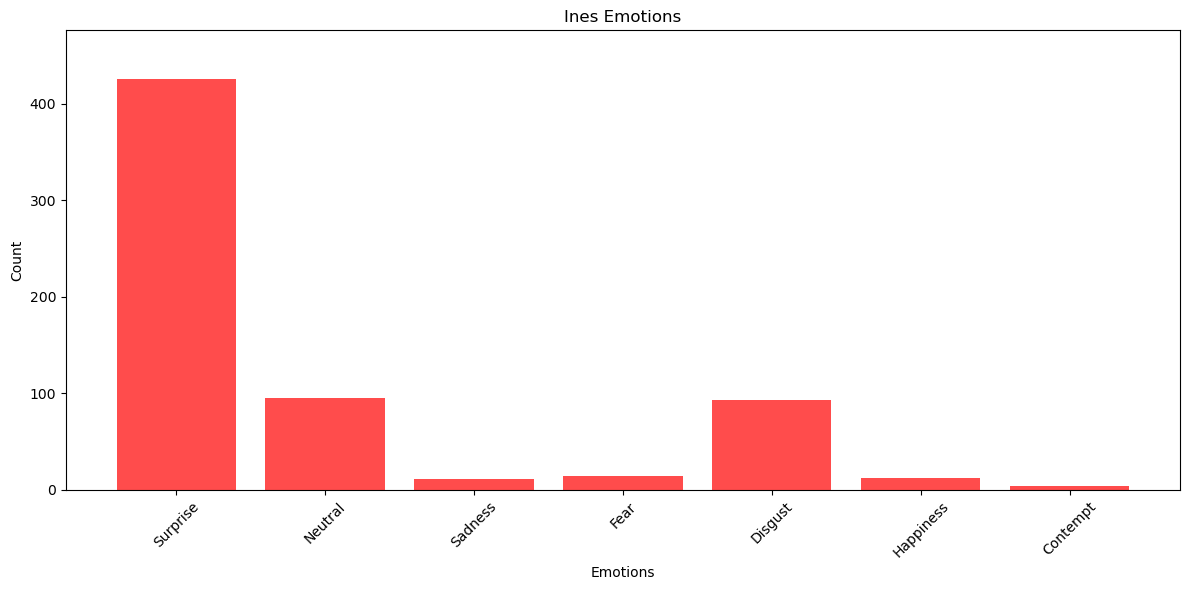

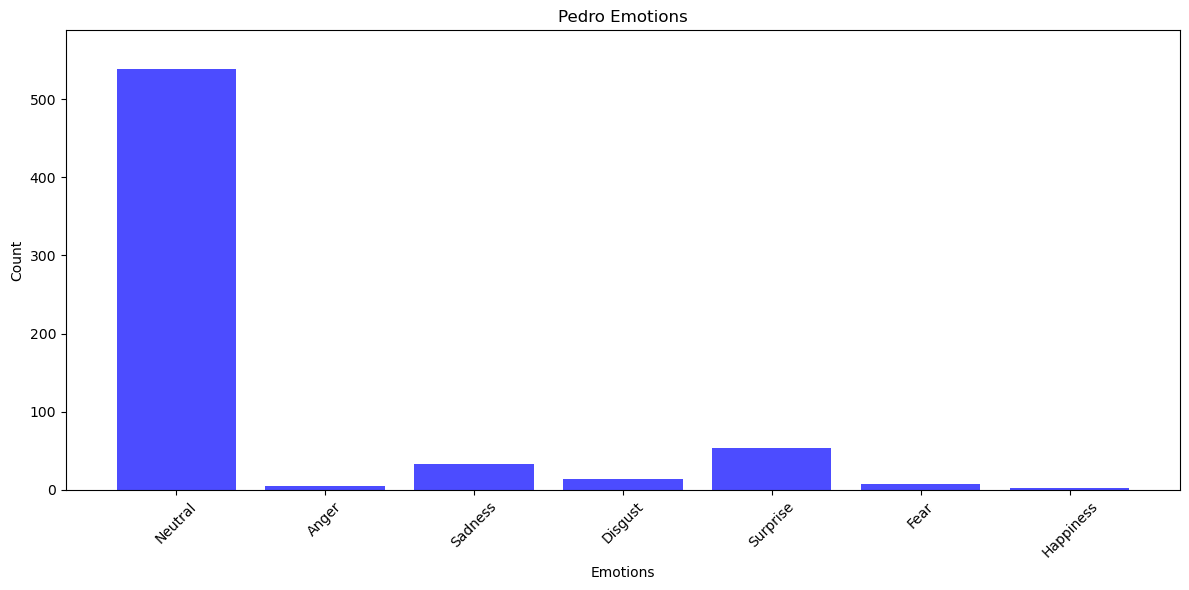

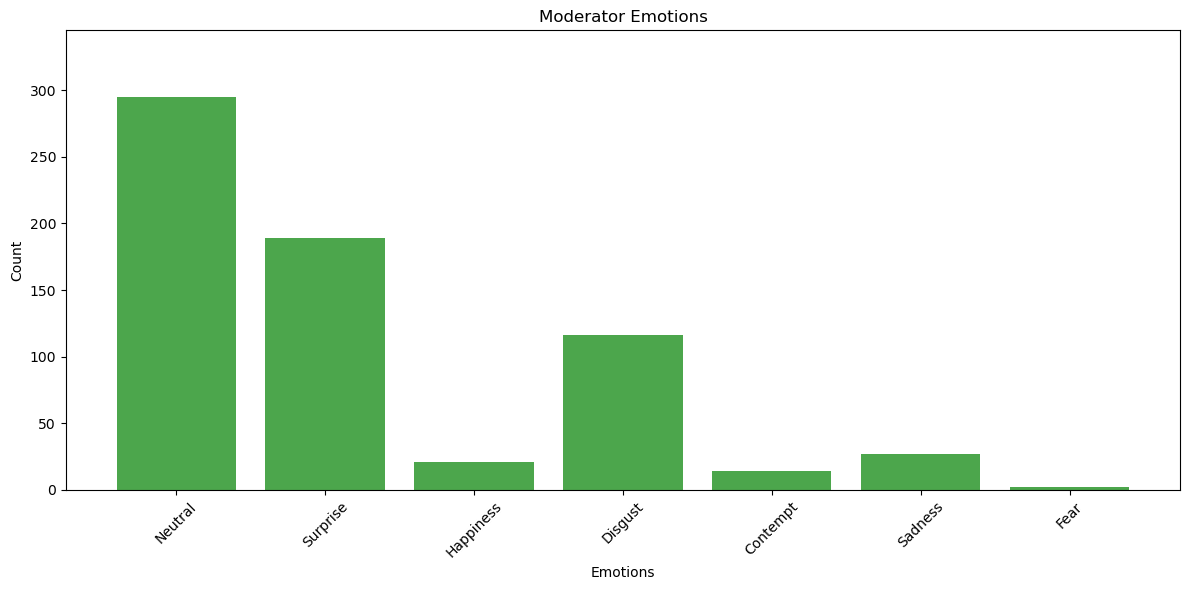

In [100]:
df_both_candidates_same_frame = copy.deepcopy(dfs[debate].iloc[C1_modified[0]])

# Get the value from the database of the index obtained from the clustering
df_only_ines = copy.deepcopy(dfs[debate].iloc[C1_modified[1]])
df_only_pedro = copy.deepcopy(dfs[debate].iloc[C1_modified[2]])
df_moderator = copy.deepcopy(dfs[debate].iloc[C1_modified[3]])

df_both_candidates_same_frame = remove_translator1v1(df_both_candidates_same_frame)
df_only_ines = remove_translator(df_only_ines)
df_only_pedro = remove_translator(df_only_pedro)
df_moderator = remove_translator(df_moderator)

pedro1v1, ines1v1 = get_location_for_each_candidate(df_both_candidates_same_frame)

pedro_emotions = get_emotions(df_only_pedro , pedro1v1, 0)
ines_emotions = get_emotions(df_only_ines, ines1v1, 0)
moderator_emotions = get_emotions(df_moderator, df_moderator, 1)

print("Ines Emotions:", ines_emotions)
print("Pedro Emotions:", pedro_emotions)
print("Moderator Emotions:", moderator_emotions)

plot_emotions("Ines", ines_emotions, 'r')
plot_emotions("Pedro", pedro_emotions, 'b')
plot_emotions("Moderator", moderator_emotions, 'g')

emotions[debate]['Ines']=ines_emotions
emotions[debate]['Pedro']=pedro_emotions
emotions[debate]['Sara Pinto']=moderator_emotions

<a id="section4"></a>

# 4. Emotion Analysis

<a id="section4.1"></a>

## 4.1 Barplot of most frequent emotions per party

In [101]:
person_emotions = defaultdict(lambda: defaultdict(int))
for debate, persons in emotions.items():
    for person, emots in persons.items():
        for emotion, value in emots.items():
            person_emotions[person][emotion] += value

In [102]:
for person, emots in person_emotions.items():
    person_emotions[person] = dict(sorted(person_emotions[person].items(), key=lambda item: item[1], reverse=True))

In [103]:
for person in person_emotions.keys():
    print(person, person_emotions[person])

Montenegro {'Anger': 2379, 'Neutral': 2151, 'Surprise': 2052, 'Sadness': 1659, 'Contempt': 1462, 'Disgust': 816, 'Fear': 283, 'Happiness': 100}
Mortagua {'Surprise': 4139, 'Neutral': 1483, 'Contempt': 929, 'Sadness': 519, 'Anger': 316, 'Disgust': 211, 'Fear': 69, 'Happiness': 69}
Sara Pinto {'Neutral': 669, 'Surprise': 378, 'Disgust': 266, 'Sadness': 134, 'Anger': 56, 'Fear': 43, 'Contempt': 34, 'Happiness': 22}
Raimundo {'Neutral': 3181, 'Surprise': 2273, 'Sadness': 1715, 'Anger': 554, 'Disgust': 506, 'Contempt': 172, 'Fear': 145, 'Happiness': 38}
Joao Adelino Faria {'Neutral': 1021, 'Surprise': 631, 'Sadness': 556, 'Disgust': 320, 'Contempt': 260, 'Fear': 161, 'Anger': 148, 'Happiness': 89}
Ventura {'Surprise': 3810, 'Neutral': 2260, 'Sadness': 2069, 'Contempt': 748, 'Disgust': 254, 'Happiness': 231, 'Fear': 93, 'Anger': 61}
Rocha {'Neutral': 2938, 'Surprise': 1156, 'Sadness': 1153, 'Contempt': 816, 'Disgust': 671, 'Fear': 204, 'Anger': 133, 'Happiness': 40}
Tavares {'Surprise': 3064

In [104]:
mods = ['Sara Pinto', 'Joao Adelino Faria', 'Clara de Sousa', 'Rosa Pinto', 'Joao Marinheiro']

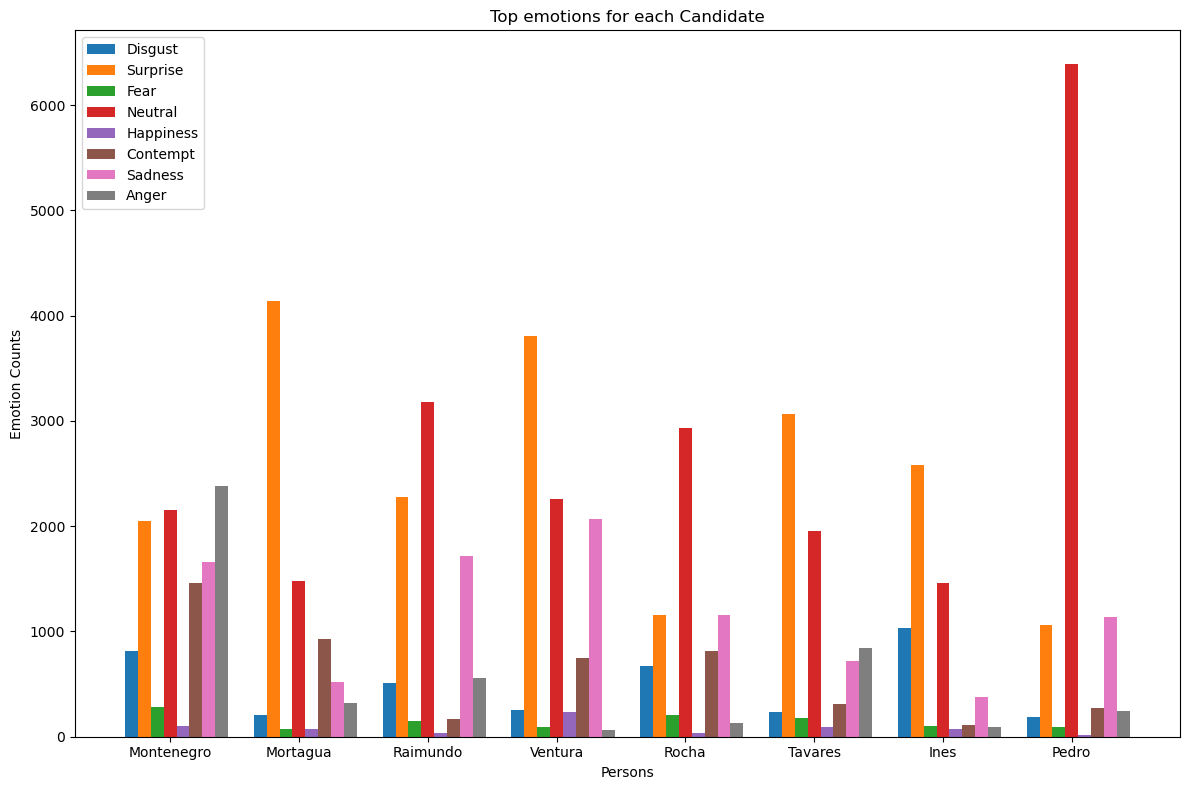

In [105]:
filtered_person_emotions = {person: emotions for person, emotions in person_emotions.items() if person not in mods}

top_emotions = defaultdict(lambda: defaultdict(int))

for person, emots in filtered_person_emotions.items():
    keys = list(emots.keys())#[:5] #uncomment to plot the top5
    for key in keys:
        top_emotions[person][key] = person_emotions[person][key]

persons = list(top_emotions.keys())
unique_emotions = list(set(emotion for person in top_emotions.values() for emotion in person.keys()))

num_persons = len(persons)
num_emotions = len(unique_emotions)

emotion_counts = {emotion: [top_emotions[person].get(emotion, 0) for person in persons] for emotion in unique_emotions}

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Width of each group of bars
bar_width = 0.8 / num_emotions  # Adjust the width of bars

# Position of each person on X-axis
r = np.arange(num_persons)

# Plot each emotion as a separate set of bars
for i, emotion in enumerate(unique_emotions):
    ax.bar(r + i * bar_width, emotion_counts[emotion], width=bar_width, label=emotion, align='edge')

# Adding labels, ticks, and title
ax.set_xlabel('Persons')
ax.set_ylabel('Emotion Counts')
ax.set_title('Top emotions for each Candidate')
ax.set_xticks(r + (num_emotions - 1) * bar_width / 2)
ax.set_xticklabels(persons)
ax.legend()

# Show plot
plt.tight_layout()
plt.show()

<a id="section4.2"></a>

## 4.2 Barplot of least frequent emotion per party

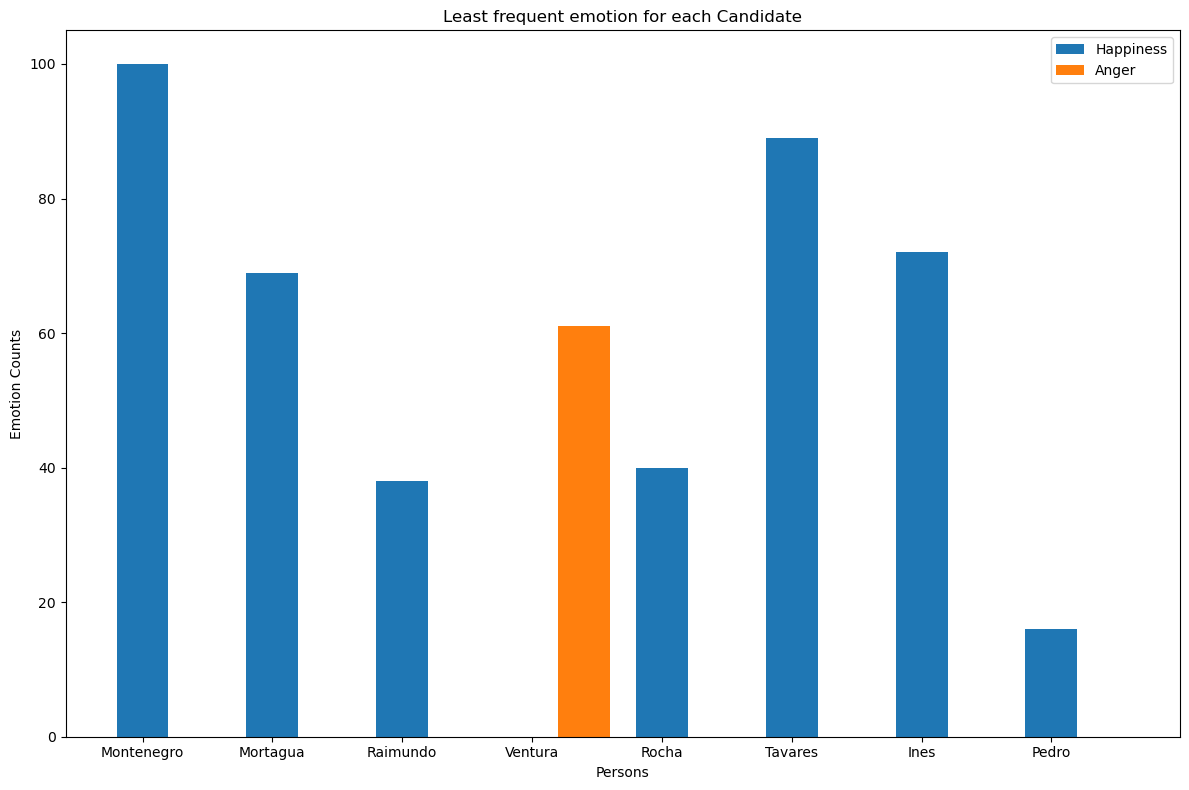

In [106]:
filtered_person_emotions = {person: emotions for person, emotions in person_emotions.items() if person not in mods}

top_emotions = defaultdict(lambda: defaultdict(int))

for person, emots in filtered_person_emotions.items():
    keys = list(emots.keys())[-1:]
    for key in keys:
        top_emotions[person][key] = person_emotions[person][key]

persons = list(top_emotions.keys())
unique_emotions = list(set(emotion for person in top_emotions.values() for emotion in person.keys()))

num_persons = len(persons)
num_emotions = len(unique_emotions)

emotion_counts = {emotion: [top_emotions[person].get(emotion, 0) for person in persons] for emotion in unique_emotions}

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Width of each group of bars
bar_width = 0.8 / num_emotions  # Adjust the width of bars

# Position of each person on X-axis
r = np.arange(num_persons)

# Plot each emotion as a separate set of bars
for i, emotion in enumerate(unique_emotions):
    ax.bar(r + i * bar_width, emotion_counts[emotion], width=bar_width, label=emotion, align='edge')

# Adding labels, ticks, and title
ax.set_xlabel('Persons')
ax.set_ylabel('Emotion Counts')
ax.set_title('Least frequent emotion for each Candidate')
ax.set_xticks(r + (num_emotions - 1) * bar_width / 2)
ax.set_xticklabels(persons)
ax.legend()

# Show plot
plt.tight_layout()

<a id="section4.3"></a>

## 4.3 Barplot of emotions per political ideology

In [107]:
D = ['Montenegro', 'Ventura', 'Rocha']
E = ['Mortagua', 'Raimundo', 'Tavares', 'Ines', 'Pedro']
direita = defaultdict(int)
esquerda = defaultdict(int)

In [108]:
for person, emots in filtered_person_emotions.items():
    for emot in emots:
        if person in D:
            direita[emot] += person_emotions[person][emot]
        elif person in E:
            esquerda[emot] += person_emotions[person][emot]

In [109]:
for emot, val in direita.items():
    direita[emot] = direita[emot]/len(D)
    
for emot, val in esquerda.items():
    esquerda[emot] = esquerda[emot]/len(E)

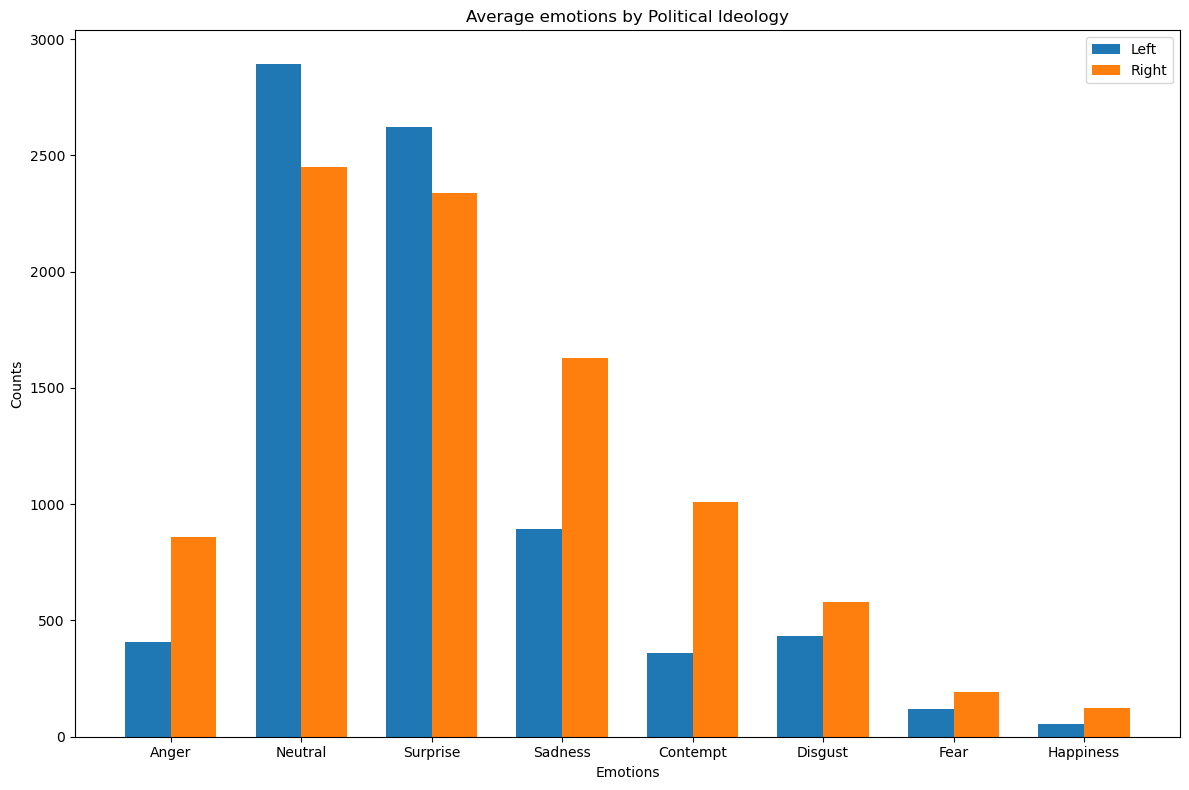

In [110]:
# Extract emotions and their counts
emots = list(direita.keys())  # Assuming both dictionaries have the same keys in the same order

# Width of the bars
bar_width = 0.35

# Positions of bars on x-axis
indices = np.arange(len(emots))

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Create bars for 'direita' and 'esquerda'
bars1 = ax.bar(indices, [esquerda[emotion] for emotion in emots], bar_width, label='Left')
bars2 = ax.bar(indices + bar_width, [direita[emotion] for emotion in emots], bar_width, label='Right')

# Add labels, title, and legend
ax.set_xlabel('Emotions')
ax.set_ylabel('Counts')
ax.set_title('Average emotions by Political Ideology')
ax.set_xticks(indices + bar_width / 2)
ax.set_xticklabels(emots)
ax.legend()

# Show plot
plt.tight_layout()
plt.show()

<a id="section4.4"></a>

## 4.4 Barplot of most frequent emotions per Moderator

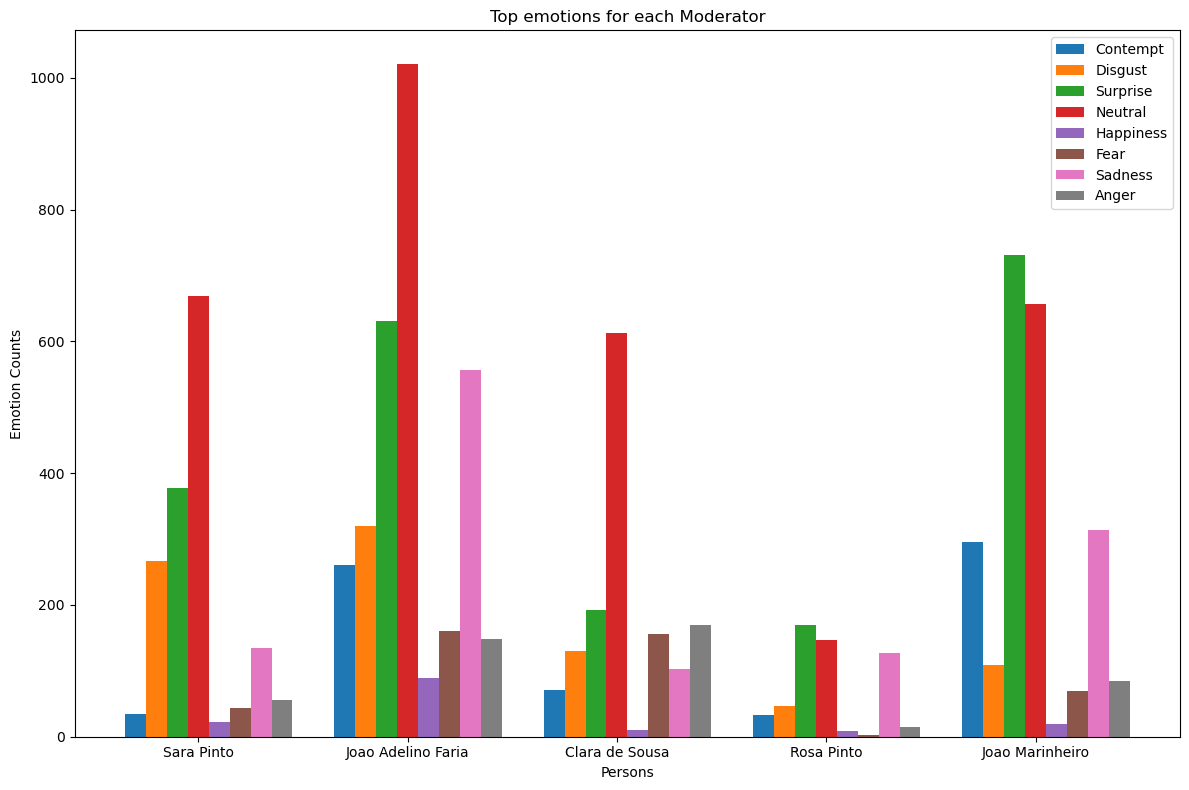

In [111]:
filtered_person_emotions = {person: emots for person, emots in person_emotions.items() if person in mods}

# Prepare to store the top 5 emotions for each remaining candidate
top_emotions = defaultdict(lambda: defaultdict(int))

# Determine top 5 emotions for each remaining candidate and order them
for person, emots in filtered_person_emotions.items():
    keys = list(emots.keys())#[:5] #uncomment to plot top5
    for key in keys:
        top_emotions[person][key] = person_emotions[person][key]

persons = list(top_emotions.keys())
unique_emotions = list(set(emotion for person in top_emotions.values() for emotion in person.keys()))

# Prepare data for plotting
num_persons = len(persons)
num_emotions = len(unique_emotions)

# Create lists to store emotion counts for each person
emotion_counts = {emotion: [top_emotions[person].get(emotion, 0) for person in persons] for emotion in unique_emotions}

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Width of each group of bars
bar_width = 0.8 / num_emotions  # Adjust the width of bars

# Position of each person on X-axis
r = np.arange(num_persons)

# Plot each emotion as a separate set of bars
for i, emotion in enumerate(unique_emotions):
    ax.bar(r + i * bar_width, emotion_counts[emotion], width=bar_width, label=emotion, align='edge')

# Adding labels, ticks, and title
ax.set_xlabel('Persons')
ax.set_ylabel('Emotion Counts')
ax.set_title('Top emotions for each Moderator')
ax.set_xticks(r + (num_emotions - 1) * bar_width / 2)
ax.set_xticklabels(persons)
ax.legend()

# Show plot
plt.tight_layout()
plt.show()

<a id="section4.5"></a>

## 4.5 Pie chart of Moderator appearances

In [112]:
mods_count = defaultdict(int)
person_emotions = defaultdict(lambda: defaultdict(int))
for debate, persons in emotions.items():
    for person in persons.keys():
        if person in mods:
            mods_count[person] += 1

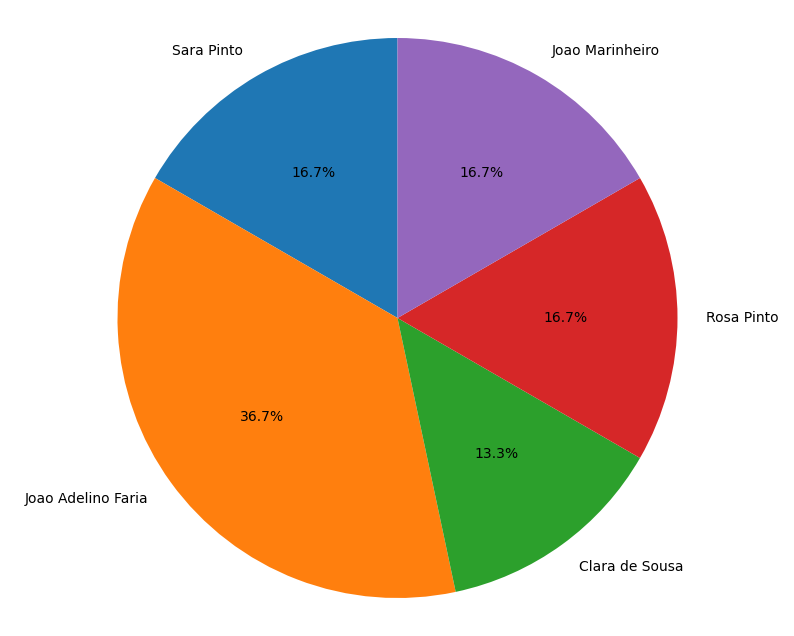

In [113]:
# Prepare data for pie chart
labels = list(mods_count.keys())
sizes = list(mods_count.values())

# Create a pie chart
fig, ax = plt.subplots(figsize=(10,8))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show plot
plt.show()

------------------------------
# Authors
<p style="font-size: 20px; line-height: 1.2;">
<strong>Diogo Miranda (96190)</strong><br>
<strong>João Martins (99983)</strong><br>
<strong>Miguel Bandeira (100035)</strong>
</p>